# About
To understand Competition Metric "DFL Event Detection AP", I prepared some simple label data and some predicted results.<br>
I hope this will help for you! <br>

## references
https://www.kaggle.com/code/hidebu/exploration-of-competition-metric-dfl-ap-jp-en

## Competition metric functions

In [1]:
# Google Colabで、Google Driveをマウント
from google.colab import drive
drive.mount('/content/drive')

#/root/.kaggleを作成して、apiを使えるようにする。
!sudo mkdir /root/.kaggle
!cp /content/drive/MyDrive/.kaggle/kaggle.json /root/.kaggle/kaggle.json

# cdは!が使えない。マジックコマンド%で移動
# %cd /content/drive/MyDrive/Competitions/DFL/
%ls -a

Mounted at /content/drive
./  ../  .config/  drive/  sample_data/


In [2]:
!pip install moviepy==1.0.3
!pip install timm==0.6.5
!pip install transformers
!pip install pytorch_metric_learning
# !pip install SoccerNet
# !pip install tensorboardX

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 388 kB 7.1 MB/s 
     |████████████████████████████████| 26.9 MB 1.2 MB/s 
  Created wheel for moviepy: filename=moviepy-1.0.3-py3-none-any.whl size=110743 sha256=227640b04c009d9aca05b1787ca41412728c16fedf2a49ee9a1abbd13863b938
  Stored in directory: /root/.cache/pip/wheels/56/dc/2b/9cd600d483c04af3353d66623056fc03faed76b7518faae4df
Successfully built moviepy
  Attempting uninstall: moviepy
    Found existing installation: moviepy 0.2.3.5
    Uninstalling moviepy-0.2.3.5:
      Successfully uninstalled moviepy-0.2.3.5
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 512 kB 7.3 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.7 MB 7.6 MB/s 
     |███████████████████

In [3]:
# ========================================
# library
# ========================================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold, KFold,GroupKFold, StratifiedGroupKFold
from sklearn.metrics import mean_squared_error

import logging
from logging import getLogger, INFO, FileHandler,  Formatter,  StreamHandler
import sys
from contextlib import contextmanager
import time
import random
from tqdm import tqdm
import os, sys
import pickle
import gc
import glob
from collections import defaultdict
import math

import torch
import torch.nn as nn
from torch.nn import Parameter
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, Subset
import torch.optim as optim
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts, CosineAnnealingLR, ReduceLROnPlateau

import pytorch_metric_learning
import pytorch_metric_learning.utils.logging_presets as LP
from pytorch_metric_learning.utils import common_functions
from pytorch_metric_learning import losses, miners, samplers, testers, trainers
from pytorch_metric_learning.utils.accuracy_calculator import AccuracyCalculator
from pytorch_metric_learning.utils.inference import InferenceModel

import torchvision
from torchvision.io import read_image
import torchvision.transforms as T
from torchvision.transforms import Resize, RandomHorizontalFlip, ColorJitter, Normalize, Compose, RandomResizedCrop, CenterCrop, ToTensor

import albumentations as A
from albumentations import Resize, Blur, RandomBrightnessContrast, RandomRotate90, CoarseDropout, HorizontalFlip, VerticalFlip, CenterCrop
from albumentations.augmentations.transforms import GaussNoise

# !pip install timm
import timm
sys.path.append('../input/timm-pytorch-image-models/pytorch-image-models-master')
from timm import create_model
from timm.data.mixup import Mixup
# avail_pretrained_models = timm.list_models(pretrained=True)
# len(avail_pretrained_models), avail_pretrained_models

from PIL import Image
import cv2

from transformers import AutoModelForSequenceClassification, AutoTokenizer, AutoModel,AutoConfig
import transformers
from transformers import RobertaModel,RobertaTokenizer
from transformers import AlbertModel,AlbertTokenizer
from transformers import XLNetModel,XLNetTokenizer,XLNetConfig
from transformers import DebertaModel, DebertaTokenizer
from transformers import ElectraModel, ElectraTokenizer, ElectraForSequenceClassification
from transformers import BartModel,BertModel,BertTokenizer
from transformers import AdamW, get_linear_schedule_with_warmup
from transformers import MPNetModel,MPNetTokenizer
from transformers import FunnelBaseModel,FunnelTokenizer,FunnelModel
from transformers import GPT2Model, GPT2Tokenizer, GPT2Config
from transformers import T5EncoderModel,T5Tokenizer
from transformers import get_linear_schedule_with_warmup, get_cosine_schedule_with_warmup
from transformers import BertConfig, BertModel, BertTokenizerFast

from sklearn import datasets
from sklearn.model_selection import StratifiedKFold, GroupKFold
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score

from pandas.testing import assert_index_equal
from typing import Dict, Tuple

from IPython.core.display import Video
from moviepy.video.io.ffmpeg_tools import ffmpeg_extract_subclip, ffmpeg_movie_from_frames

import joblib 
from joblib import parallel, delayed

from scipy.sparse import hstack, vstack, csc_matrix, csr_matrix
import editdistance
import networkx as nx

import sys
# sys.path.append('../input/timm045/')

# import SoccerNet
# from SoccerNet.Downloader import SoccerNetDownloader

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

In [4]:
# ==============================
# CONFIG
# ==============================  
class config:
    EXP = "18"
    EXPLAIN = "1 FOLD MULTI HEAD ARC FACE, 1layer FC"
    EXP_NAME = f"EXP{EXP}"
    
    INPUT = "/kaggle/input/ventilator-pressure-prediction"
    OUTPUT = "/kaggle/working"
    N_FOLD = 1 # 12
    SEED = 420
    NUM_WORKERS = 4
    IS_DEBUG = False
    IS_TRAIN = True
    IS_INFER = False

    LR = 1e-4 # 1e-5 # 8e-6 # [1e-6, 1e-3] # pretrainedなら学習率は下げる
    EPOCHS = 10
    EARLY_STOPPING_ROUND = 3
    STEP_SAVE_MODEL = False
    STEP_SAVE_MODEL_COUNT = 1000
    BATCH_SIZE = 10

    EMBED_SIZE = 256
    HIDDEN_SIZE = 256
    WEIGHT_DECAY = 1e-5 # [0.1, 1e-6]
    # WEIGHT_DECAY = 1e-6

    num_cycles=0.5 # 'cosine'

    # Scheduler Guide : https://www.kaggle.com/code/isbhargav/guide-to-pytorch-learning-rate-scheduling/notebook
    scheduler = 'CosineAnnealingWarmRestarts'# 'CosineAnnealingLR' # ['linear', 'cosine', 'ReduceLROnPlateau', 'CosineAnnealingLR', 'CosineAnnealingWarmRestarts']
    
    # linear_warmup or cosine_warmup :
    num_warmup_steps = 100

    # cosinannealing : 
    T_max = 100 # CosineAnnealingLR : half cycle period of cosine function
    min_lr= 3.0e-7 # [1e-8, 1e-6]

    # cosineannealingwarmrestarts : 
    T_0 = 50 # half cycle period of cosine function
    T_mult = 1
    last_epoch = -1

    NOT_WATCH_PARAM = ['INPUT']

    model_names = ['swin_large_patch4_window7_224', 'beit_large_patch16_224',
                   'swin_base_patch4_window12_384_in22k', 'swin_large_patch4_window12_384_in22k', 'vit_large_patch16_384', 
                   'tf_efficientnet_l2_ns_475', 'tf_efficientnet_l2_ns_475_512', 
                   'tf_efficientnet_b5_ns', 'tf_efficientnet_b6_ns', 'tf_efficientnet_b7_ns']

    target_dic = {'background': 0, 'challenge': 1, 'play': 2, 'throwin': 3} # {e:i for i, e in enumerate(train['event'].unique())}
    target_dic = {'background':0,'challenge':1, 'play':2, 'throwin':3, 'background_challenge':4, 'background_play':5, 'background_throwin':6}
    r_target_dic = {t:event for event, t in target_dic.items()}

    output_length = len(target_dic)

#   'tf_efficientnet_b5_ns':[456,456], 'tf_efficientnet_b6_ns':[528, 528], tf_efficientnet_b7_ns:[600, 600]

    print_freq = 100


In [5]:

# ==================
# Constant
# ==================

TRAIN_PATH = rf"/content/drive/MyDrive/Competitions/DFL/input/train.csv"
INPUT_PATH = rf"/content/drive/MyDrive/Competitions/DFL/input/"
OUTPUT_PATH = f"/content/drive/MyDrive/Competitions/DFL/output/"

SAVE_PATH = f"/content/drive/MyDrive/Competitions/DFL/output/{config.EXP_NAME}"
LOGGER_PATH = f"/content/drive/MyDrive/Competitions/DFL/output/{config.EXP_NAME}/{config.EXP_NAME}.txt"
OOF_SAVE_PATH = f'/content/drive/MyDrive/Competitions/DFL/output/{config.EXP_NAME}/{config.EXP_NAME}.npy'

WEIGHT_PATH = rf"/content/drive/MyDrive/Competitions/DFL/weight/"

os.makedirs(OUTPUT_PATH, exist_ok=True)
os.makedirs(SAVE_PATH, exist_ok=True)

MODEL_PATH_BASE = f"./output/{config.EXP_NAME}"
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

tolerances = {
    "challenge": [0.3, 0.4, 0.5, 0.6, 0.7],
    "play": [0.15, 0.20, 0.25, 0.30, 0.35],
    "throwin": [0.15, 0.20, 0.25, 0.30, 0.35],
}

In [6]:
# ===============
# Functions
# ===============            
def set_seed(seed: int = 42):
    random.seed(seed)
    np.random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True


def setup_logger(out_file=None, stderr=True, stderr_level=logging.INFO, file_level=logging.DEBUG):
    LOGGER.handlers = []
    LOGGER.setLevel(min(stderr_level, file_level))

    if stderr:
        handler = logging.StreamHandler(sys.stderr)
        handler.setFormatter(FORMATTER)
        handler.setLevel(stderr_level)
        LOGGER.addHandler(handler)

    if out_file is not None:
        handler = logging.FileHandler(out_file)
        handler.setFormatter(FORMATTER)
        handler.setLevel(file_level)
        LOGGER.addHandler(handler)

    LOGGER.info("logger set up")
    return LOGGER

# configure model parameter size
def model_parameter_count_torch(model):
    params = 0
    for p in model.parameters():
        params += p.numel()
    LOGGER.info(f' param count : {params}')
    return params


def filter_detections(
        detections: pd.DataFrame, intervals: pd.DataFrame
) -> pd.DataFrame:
    """Drop detections not inside a scoring interval."""
    detection_time = detections.loc[:, 'time'].sort_values().to_numpy()
    intervals = intervals.to_numpy()
    is_scored = np.full_like(detection_time, False, dtype=bool)

    i, j = 0, 0
    while i < len(detection_time) and j < len(intervals):
        time = detection_time[i]
        int_ = intervals[j]

        # If the detection is prior in time to the interval, go to the next detection.
        if time < int_.left:
            i += 1
        # If the detection is inside the interval, keep it and go to the next detection.        
        elif time in int_:
            is_scored[i] = True
            i += 1
        # If the detection is later in time, go to the next interval.
        else:
            j += 1

    return detections.loc[is_scored].reset_index(drop=True)


def match_detections(
        tolerance: float, ground_truths: pd.DataFrame, detections: pd.DataFrame
) -> pd.DataFrame:
    """Match detections to ground truth events. Arguments are taken from a common event x tolerance x video evaluation group."""
    detections_sorted = detections.sort_values('score', ascending=False).dropna()

    is_matched = np.full_like(detections_sorted['event'], False, dtype=bool)
    gts_matched = set()
    for i, det in enumerate(detections_sorted.itertuples(index=False)):
        best_error = tolerance
        best_gt = None

        for gt in ground_truths.itertuples(index=False):
            error = abs(det.time - gt.time)
            if error < best_error and not gt in gts_matched:
                best_gt = gt
                best_error = error
            
        if best_gt is not None:
            is_matched[i] = True
            gts_matched.add(best_gt)

    detections_sorted['matched'] = is_matched

    return detections_sorted


def precision_recall_curve(
        matches: np.ndarray, scores: np.ndarray, p: int
) -> Tuple[np.ndarray, np.ndarray, np.ndarray]:
    if len(matches) == 0:
        return [1], [0], []

    # Sort matches by decreasing confidence
    idxs = np.argsort(scores, kind='stable')[::-1]
    scores = scores[idxs]
    matches = matches[idxs]
    
    distinct_value_indices = np.where(np.diff(scores))[0]
    threshold_idxs = np.r_[distinct_value_indices, matches.size - 1]
    thresholds = scores[threshold_idxs]
    
    # Matches become TPs and non-matches FPs as confidence threshold decreases
    tps = np.cumsum(matches)[threshold_idxs]
    fps = np.cumsum(~matches)[threshold_idxs]
    
    precision = tps / (tps + fps)
    precision[np.isnan(precision)] = 0
    recall = tps / p  # total number of ground truths might be different than total number of matches
    
    # Stop when full recall attained and reverse the outputs so recall is non-increasing.
    last_ind = tps.searchsorted(tps[-1])
    sl = slice(last_ind, None, -1)

    # Final precision is 1 and final recall is 0
    return np.r_[precision[sl], 1], np.r_[recall[sl], 0], thresholds[sl]


def average_precision_score(matches: np.ndarray, scores: np.ndarray, p: int) -> float:
    precision, recall, thresholds = precision_recall_curve(matches, scores, p)
    # Compute step integral
    return -np.sum(np.diff(recall) * np.array(precision)[:-1])


def event_detection_ap(
        solution: pd.DataFrame,
        submission: pd.DataFrame,
        tolerances: Dict[str, float],
) -> float:

    assert_index_equal(solution.columns, pd.Index(['video_id', 'time', 'event']))
    assert_index_equal(submission.columns, pd.Index(['video_id', 'time', 'event', 'score']))

    # Extract scoring intervals.
    intervals = (
        solution
        .query("event in ['start', 'end']")
        .assign(interval=lambda x: x.groupby(['video_id', 'event']).cumcount())
        .pivot(index='interval', columns=['video_id', 'event'], values='time')
        .stack('video_id')
        .swaplevel()
        .sort_index()
        .loc[:, ['start', 'end']]
        .apply(lambda x: pd.Interval(*x, closed='both'), axis=1)
    )

    # Extract ground-truth events.
    ground_truths = (
        solution
        .query("event not in ['start', 'end']")
        .reset_index(drop=True)
    )

    # Map each event class to its prevalence (needed for recall calculation)
    class_counts = ground_truths.value_counts('event').to_dict()

    # Create table for detections with a column indicating a match to a ground-truth event
    detections = submission.assign(matched = False)

    # Remove detections outside of scoring intervals
    detections_filtered = []
    for (det_group, dets), (int_group, ints) in zip(
        detections.groupby('video_id'), intervals.groupby('video_id')
    ):
        assert det_group == int_group
        detections_filtered.append(filter_detections(dets, ints))
    detections_filtered = pd.concat(detections_filtered, ignore_index=True)

    # Create table of event-class x tolerance x video_id values
    aggregation_keys = pd.DataFrame(
        [(ev, tol, vid)
         for ev in tolerances.keys()
         for tol in tolerances[ev]
         for vid in ground_truths['video_id'].unique()],
        columns=['event', 'tolerance', 'video_id'],
    )

    # Create match evaluation groups: event-class x tolerance x video_id
    detections_grouped = (
        aggregation_keys
        .merge(detections_filtered, on=['event', 'video_id'], how='left')
        .groupby(['event', 'tolerance', 'video_id'])
    )
    ground_truths_grouped = (
        aggregation_keys
        .merge(ground_truths, on=['event', 'video_id'], how='left')
        .groupby(['event', 'tolerance', 'video_id'])
    )
    
    # Match detections to ground truth events by evaluation group
    detections_matched = []
    for key in aggregation_keys.itertuples(index=False):
        dets = detections_grouped.get_group(key)
        gts = ground_truths_grouped.get_group(key)
        detections_matched.append(
            match_detections(dets['tolerance'].iloc[0], gts, dets)
        )
    detections_matched = pd.concat(detections_matched)
    print(f"detection_matched: \n {detections_matched}")
    
    # Compute AP per event x tolerance group
    event_classes = ground_truths['event'].unique()
    ap_table = (
        detections_matched
        .query("event in @event_classes")
        .groupby(['event', 'tolerance']).apply(
        lambda group: average_precision_score(
        group['matched'].to_numpy(),
                group['score'].to_numpy(),
                class_counts[group['event'].iat[0]],
            )
        )
    )
    print(f"ap_table: \n {ap_table}")

    # Average over tolerances, then over event classes
    mean_ap = ap_table.groupby('event').mean().mean()

    return mean_ap

@contextmanager
def timer(name):
    t0 = time.time()
    yield
    LOGGER.info(f'[{name}] done in {time.time() - t0:.0f} s')

LOGGER = logging.getLogger()
FORMATTER = logging.Formatter("%(asctime)s - %(levelname)s - %(message)s")
setup_logger(out_file=LOGGER_PATH)
LOGGER.info(f"{config.EXPLAIN}")

set_seed(config.SEED)

2022-09-04 13:15:38,394 - INFO - logger set up
2022-09-04 13:15:38,657 - INFO - 1 FOLD MULTI HEAD ARC FACE, 1layer FC


In [7]:
# ===============
# Functions
# ===============            

def vis_event(row, before=5, after=5):
    print(row["event_attributes"])
    filename = f"test_{row['index']}.mp4"
    ffmpeg_extract_subclip(
        f"../input/dfl-bundesliga-data-shootout/train/{row['video_id']}.mp4", 
        int(row['time']) - before, 
        int(row['time']) + after, 
        targetname=filename,
    )
    
    return Video(filename, width=800)

def convert(df):
    rets = []
    start_time = df["time"].values[0]
    end_time = df["time"].values[-1]
    video_id = df["video_id"].values[0]
    w_df = df.iloc[1:-1]
    
    events = w_df["event"].values
    times = w_df["time"].values
    
    for i in range(len(w_df)):
        
        duration = end_time - start_time
        
        digits = str(round(times[i] - int(times[i]), 2))[1:4]
        seconds = int(times[i]) % 60
        minutes = int(times[i] % 3600) % 60
        ret = {
            "video_id": video_id,
            "start_time": start_time,
            "end_time": end_time,
            "event_time": times[i],
            "duration": duration,
            "seconds": seconds,
            "minutes": minutes,
            "event": events[i],
            "digits": digits
        }
        rets.append(ret)
    return rets

def only_tolerance_(train):

    tolerances['background'] = [10**4+7]

    t_dic = {k:max(v) for k, v in tolerances.items()}

    train['diff'] = (train['event_time'] - train['start_time']).abs()
    train['event_tolerance'] = train['event'].map(t_dic)
    train = train.query('diff < event_tolerance').reset_index()


In [8]:
# ==============================
# Reading DATA CREATE FEATURES
# ==============================

def create_folds(train, num_splits=config.N_FOLD):
    # gkf = GroupKFold(n_splits=5).split(train, train.target, groups=train.video_id)
    # gkf = StratifiedGroupKFold(n_splits=num_splits).split(train, train.target, groups=train.video_id)
    train['fold'] = -1
    # for fold, (train_idx, val_idx) in enumerate(gkf):
    #     train.loc[val_idx, 'fold'] = fold
    idx = train['video_id'].isin(['3c993bd2_0', '3c993bd2_1'])
    train.loc[idx, 'fold'] = 0
    train.loc[~idx, 'fold'] = 1

    # configure
    for fold in train.fold.unique():
        print(f'========= fold {fold} ============')
        print(train.query('fold!=@fold')['event'].value_counts())
        print(train.query('fold==@fold')['event'].value_counts())


# Save Pictures
def additional_events(df):
    columns = ['video_id', 'time', 'event', 'event_attributes']

    additional_events = []

    for arr in df.sort_values(['video_id','time','event','event_attributes'])[columns].values:
        video_id = arr[0]
        time_ = arr[1]
        event = arr[2]
        event_attributes = arr[3]

        if event in tolerances:
            tol = tolerances[event][0]
            additional_events.append([arr[0], arr[1]-tol, 'start_'+arr[2], arr[3]])
            additional_events.append([arr[0], arr[1]+tol, 'end_'+arr[2], arr[3]])
    df = pd.concat([df, pd.DataFrame(additional_events, columns=df.columns)])

    df = df[~df['event'].isin(tolerances.keys())]
    df = df.sort_values(['video_id', 'time'])
    return df


def imbalanced_sampling(train:pd.DataFrame, target:np.array, method='undersampler'):
    from imblearn.over_sampling import RandomOverSampler, SMOTE
    from imblearn.under_sampling import RandomUnderSampler
    if method=='undersampler':
        sampler = RandomUnderSampler(random_state=config.SEED)
    elif method=='oversampler':
        sampler = RandomOverSampler(random_state=config.SEED)
        # sampler = SMOTE()
    # x_resampled, y_resampled = ros.fit_resample(train, train.target.values)
    x_resampled, y_resampled = sampler.fit_resample(train, target)

    return x_resampled, y_resampled

df = pd.read_csv(TRAIN_PATH)
# df["group"] = (df["event"] == "start").cumsum()

# rets = []
# for _, w_df in df.groupby("group"):
#     rets.extend(convert(w_df))
# df_rets = pd.DataFrame(rets)
# df_rets['video_path'] = OUTPUT_PATH + df_rets['video_id'] + '/' + df_rets['event'] + '_' + df_rets['event_time'].astype(str) + '.mp4'


df_events = additional_events(df)

# train = pd.read_pickle(f'{OUTPUT_PATH}/train.pkl')
# train = pd.read_pickle(f'{OUTPUT_PATH}/reduced_train.pkl')
# train = pd.read_pickle(f'{OUTPUT_PATH}/reduced_train_e003_b0001.pkl')
# train = pd.read_pickle(f'{OUTPUT_PATH}/reduced_train_e003_bALL.pkl')
# train = pd.read_pickle(f'{OUTPUT_PATH}/EXP09_suffix_classified_train.pkl')
# train = pd.read_pickle(f'{OUTPUT_PATH}/EXP10_reduced_train_play8000_challenge6000.pkl')
train = pd.read_pickle(f'{OUTPUT_PATH}/EXP16_reduced_train_play15000_playback10000.pkl')

# train, _ = imbalanced_sampling(train, train.event.values, method='oversampler')
# train, _ = imbalanced_sampling(train, train.event.values, method='undersampler')

print(train['event'].value_counts())

# train = train[train['event'].isin(config.target_dic)]

train['target'] = train.event.map(config.target_dic)

# fold
train = train.reset_index(drop=True)
create_folds(train, num_splits=config.N_FOLD)

play                    14504
background_play         10557
challenge                9954
background               3575
background_challenge     2391
throwin                  1376
background_throwin        923
Name: event, dtype: int64
========= fold 1 ============
play                    2577
challenge               1960
background_play         1885
background               631
background_challenge     452
throwin                  248
background_throwin       166
Name: event, dtype: int64
play                    11927
background_play          8672
challenge                7994
background               2944
background_challenge     1939
throwin                  1128
background_throwin        757
Name: event, dtype: int64
========= fold 0 ============
play                    11927
background_play          8672
challenge                7994
background               2944
background_challenge     1939
throwin                  1128
background_throwin        757
Name: event, dtype: int64
pla

In [9]:
def reduce_train_data(train:pd.DataFrame):
    """
    # play                    28688 -> 15000
    # background_play         15787 -> 10000
    # challenge                9954 -> 
    # background               3575
    # background_challenge     2391
    # throwin                  1376
    # background_throwin        923
    """

    play_counts = train.event.value_counts()['play']
    backgroung_play_count = train.event.value_counts()['background_play']
    challenge_count = train.event.value_counts()['challenge']

    # organize_dict = {'play':8000/play_counts, 'background_play':7000/backgroung_play_count, 'challenge':6000/challenge_count}
    organize_dict = {'play':15000/play_counts, 'background_play':10000/backgroung_play_count}

    sample_idxes = []
    for _, gdf in train.groupby('video_id'):
        print(_)
        gdf = gdf.sort_values('time')
        for event, rate in organize_dict.items():

            gdf['flag'] = (gdf['event']==event)*1

            if gdf.iloc[0, 3]==event: f = 1
            else: f = 0

            gdf['flag'] = gdf['flag'].diff().fillna(f)
            gdf['flag'] = np.where(gdf['flag']<0, 0, gdf['flag'])
            gdf['group'] = gdf['flag'].cumsum().astype(int)
            event_df = gdf.query('event==@event')

            for idx, ggdf in event_df.groupby('group'):
                if len(ggdf)==0: continue
                sample_num = round(len(ggdf)*rate)
                if len(ggdf)>sample_num:
                    min_idx = ggdf.index.min()
                    max_idx = ggdf.index.max()
                    id = random.sample(list(range(min_idx, max_idx+1)), sample_num)
                    id = sorted(id)
                else:
                    id = [ggdf.index[0]]
                sample_idxes.extend(id)
    
    reduced_train = train.loc[sample_idxes]#, sample_idxes

    tmp = train[~train.event.isin(organize_dict)]

    reduced_train = pd.concat([tmp, reduced_train])

    reduced_train = reduced_train.sort_values(['video_id', 'time'])

    return reduced_train

# reduced_train = reduce_train_data(train)
# reduced_train.to_pickle(f'{OUTPUT_PATH}/EXP16_reduced_train_play15000_playback10000.pkl')

In [10]:
# ==============================
# Reduce Train Data
# ==============================
def prepare_training_data(df_, train, events, devide=3, tol=None):
    df = df_.copy()

    columns = ['video_id', 'time', 'event', 'event_attributes']

    additional_events = []

    events_time = defaultdict(list)

    for arr in df.sort_values(['video_id','time','event','event_attributes'])[columns].values:
        video_id = arr[0]
        time_ = arr[1]
        event = arr[2]
        event_attributes = arr[3]

        if event in events:
            if tol is None:
                tol = tolerances[event][0]/devide
            if event in ['start', 'end']:
                event = 'background'
            events_time[f'{video_id}_{event}'].append([arr[1]-tol, arr[1]+tol])
    
    res = []
    for arr in train[['video_id', 'time', 'event']].values:
        video_id = arr[0]
        time_ = arr[1]
        event = arr[2]

        for t_min, t_max in events_time[f'{video_id}_{event}']:
            if t_min <= time_ and time_ <= t_max:
                res.append(True)
                break
        else:
            res.append(False)

    return res

# new_train = []
# res = prepare_training_data(df_=df, train=train, events=['challenge', 'play', 'throwin'], tol=0.03)
# new_train.append(train[res])

# res = prepare_training_data(df_=df, train=train, events=['background', 'start'], tol=0.001)
# new_train.append(train[res])
# new_train_df = pd.concat(new_train, axis=0).sort_values(['video_id', 'time']).reset_index(drop=True)
# new_train_df.event.value_counts()

In [11]:
# ==============================
# Preserve Train Data
# ==============================

def extract_training_images(df_events, video_path, debug=False):

    df = df_events.copy().reset_index(drop=True)

    video_id = video_path.split('/')[-1].replace('.mp4', '')
    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        TODO
    
    fps = cap.get(cv2.CAP_PROP_FPS)
    time_interval = 1/fps

    df_video = df[df.video_id == video_id]
    df_video = df_video.sort_values(['video_id', 'time'])

    if debug:
        df_video = df_video.head(10)
    LOGGER.info(f'{video_id}, {df_video.shape}')

    #crr_statu => background, play, challenge, throwin
    arr = df_video[['time','event']].values

    rets = []
    background_step = 10

    exist_files = 0
    add_files = 0

    for idx in tqdm(range(len(arr)-1)):
        crr_time = arr[idx,0]
        nxt_time = arr[idx+1,0]
        crr_event = arr[idx,1]
        nxt_event = arr[idx+1,1]
        #print(crr_time, nxt_time, crr_event)

        # crr_event = crr_event
        if crr_event == 'start':
            crr_status = 'background'
            suff = '_' + nxt_event.split('_', 1)[1]
            background_step = 10

        elif crr_event == 'end':
            # should use as background?
            crr_status = 'background'
            suff = ''
            background_step = 1000
            # continue

        else:
            start_or_end, crr_status = crr_event.split('_', 1)
            suff = ''
            if start_or_end == 'end':
                suff = '_' + crr_status
                crr_status = 'background'
                background_step = 10

        result_dir = f"{OUTPUT_PATH}/{video_id}/{crr_status}"

        if not os.path.exists(result_dir):
            os.makedirs(result_dir, exist_ok=True)

        this_time = crr_time
        event_save_name = crr_status + suff

        while this_time < nxt_time:

            if len(crr_event.split('_', 1))>1 and start_or_end=='end':
                this_time += time_interval*background_step

            frame_num = int(this_time*fps)

            out_file = f'{result_dir}/{video_id}_{frame_num:08}_{crr_status}.jpg'
            if os.path.exists(out_file):
                ret = {
                    "video_id": video_id,
                    "image_path": out_file,
                    "time": this_time,
                    "event": event_save_name,
                    }
                rets.append(ret)
                exist_files += 1
                if crr_status == 'background':
                    this_time += time_interval*background_step
                else:
                    this_time += time_interval
                continue

            else:
                cap.set(cv2.CAP_PROP_POS_FRAMES, frame_num)
                ret, frame = cap.read()

                cv2.imwrite(out_file, frame)
                #print(out_file, arr[idx], arr[idx+1], this_time)

                ret = {
                    "video_id": video_id,
                    "image_path": out_file,
                    "time": this_time,
                    "event": event_save_name,
                    }
                rets.append(ret)
                add_files += 1

                if crr_status == 'background':
                    this_time += time_interval*background_step
                else:
                    this_time += time_interval

    data = pd.DataFrame(rets)
    LOGGER.info(f'exist files : {exist_files}, add files : {add_files}')
    data.to_csv(OUTPUT_PATH + f'/{video_id}_EXP{config.EXP}_image_train_data.csv', index=False)

    return data


# extract background data
# def extract_background_training_images(df_events, video_path, debug=False):

#     df = df_events.copy()

#     video_id = video_path.split('/')[-1].replace('.mp4', '')
#     cap = cv2.VideoCapture(video_path)
#     if not cap.isOpened():
#         TODO
#     fps = cap.get(cv2.CAP_PROP_FPS)
#     frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
#     video_length = frame_count / fps

#     time_interval = 1/fps

#     df_video = df.query('video_id==@video_id')
#     df_video = df_video[df_video['event'].str.contains('_')]
#     df_video = df_video.sort_values(['video_id', 'time']).reset_index(drop=True)

#     arr = set()
#     starts = []
#     if len(df_video)%2==1:
#         print('ERROR DATA WRONG')
#     for t, eve in df_video[['time', 'event']].values:
#         if eve.split('_', 1)[0]=='start':
#             now = []
#             starts.append(t)
#             now.append(t)
#         else:
#             now.append(t)
#             arr.add(tuple(now))

#     arr = list(arr)
#     arr = sorted(arr)
#     starts = sorted(starts)

#     if debug:
#         df_video = df_video.head(10)

#     LOGGER.info(f'{video_id}, {df_video.shape}')

#     background_step = fps*10

#     exist_files = 0
#     add_files = 0

#     crr_status = 'background'

#     result_dir = f"{OUTPUT_PATH}/{video_id}/{crr_status}"

#     if not os.path.exists(result_dir):
#         os.makedirs(result_dir, exist_ok=True)

#     this_time = 0
#     rets = []
#     def another_event_judge(arr, this_time):
#         exist = False
#         for t_min, t_max in arr:
#             if t_min < this_time < t_max:
#                 exist=True
#                 break
#         return exist
        

#     while this_time < video_length:
#         frame_num = int(this_time*fps)

#         out_file = f'{result_dir}/{video_id}_{frame_num:08}_{crr_status}.jpg'

#         if another_event_judge(arr, this_time):
#             this_time += time_interval*background_step
#             continue

#         if os.path.exists(out_file):
#             ret = {
#                 "video_id": video_id,
#                 "image_path": out_file,
#                 "time": this_time,
#                 "event": crr_status,
#                 }
#             rets.append(ret)
#             exist_files += 1
#             this_time += time_interval*background_step
#             continue

#         else:
#             cap.set(cv2.CAP_PROP_POS_FRAMES, frame_num)
#             ret, frame = cap.read()

#             cv2.imwrite(out_file, frame)
#             #print(out_file, arr[idx], arr[idx+1], this_time)

#             ret = {
#                 "video_id": video_id,
#                 "image_path": out_file,
#                 "time": this_time,
#                 "event": crr_status,
#                 }
#             rets.append(ret)
#             add_files += 1
#             this_time += time_interval*background_step

#     data = pd.DataFrame(rets)
#     LOGGER.info(f'exist files : {exist_files}, add files : {add_files}')
#     data.to_csv(OUTPUT_PATH + f'/{video_id}_background_train_data.csv', index=False)

#     return data

SAVE = False
if SAVE:
    video_paths = glob.glob(INPUT_PATH + '/train/*.mp4')
    datas = []
    for video_path in video_paths:
        # event data
        data = extract_training_images(df_events, video_path, debug=False)
        datas.append(data)

        # background data
        # data = extract_background_training_images(df_events, video_path, debug=False)
        # datas.append(data)

    train_df = pd.concat(datas)
    train_df.sort_values(['video_id', 'time']).reset_index(drop=True).to_pickle(f'{OUTPUT_PATH}/EXP09_suffix_classified_train.pkl')

    # background_df = pd.concat(datas)
    # background_df.to_csv(OUTPUT_PATH + f'/ALL_background_train_data.csv', index=False)
    # train = pd.concat([train.query('event!="background"')[['video_id', 'image_path', 'time', 'event']], background_df]).sort_values(['video_id', 'time']).reset_index(drop=True)
    # train.to_pickle(f'{OUTPUT_PATH}/reduced_train_e003_bALL.pkl')
    print('done')

    # debug
    # df_events.query('video_id=="cfbe2e94_1"')[:20]
    # train_df.query('video_id=="cfbe2e94_1"')

In [12]:
# ==============================
# Preserve Validation Data
# ==============================

def extract_images(video_path, out_dir):
    video_name = os.path.basename(video_path).split('.')[0]
    cap = cv2.VideoCapture(video_path)

    fps = cap.get(cv2.CAP_PROP_FPS)
    frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))//2
    height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))//2

    print(video_path)
    frame_count = 1
    while True:
        if frame_count%5000==0:
            LOGGER.info(f'{frame_count}/{frames}')
        successed, img = cap.read()
        if not successed:
            break
        outfile = f'{out_dir}/{video_name}-{frame_count:06}.jpg'
        if os.path.exists(outfile):
            frame_count += 1
            continue
        # img = cv2.resize(img, dsize=(IMG_SIZE, IMG_SIZE))
        img = cv2.resize(img, dsize=None, fx=0.5, fy=0.5)
        cv2.imwrite(outfile, img)
        #print(outfile)
        frame_count += 1    

# valid_video_paths = train.query('fold==0')['video_id'].unique()
# valid_videos = ['3c993bd2_0', '3c993bd2_1']
# valid_video_paths = valid_videos

# VAL_DIR = f'{OUTPUT_PATH}/validation_data_3c993bd2/'
# os.makedirs(VAL_DIR, exist_ok=True)

# for video_path in valid_video_paths:
#     video_path = f'/content/drive/MyDrive/Competitions/DFL/input/train/{video_path}.mp4'
#     # print(os.path.exists(video_path))
#     extract_images(video_path, VAL_DIR)

In [13]:
# ==============================
#  Transform
# ==============================
def image_transforms(IMG_SIZE, phase='train', mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)):
    # height, width = IMG_SIZE[0], IMG_SIZE[1]
    if phase=='train':
        return A.Compose([
            # A.OneOf([
            #     A.RandomResizedCrop(IMG_SIZE, IMG_SIZE, p=1.0, scale=(0.85, 0.95)),
            #     A.Resize(IMG_SIZE, IMG_SIZE, p=1.0),
            #     A.Compose([
            #         A.Resize(int(IMG_SIZE * 1.5), int(IMG_SIZE * 1.5), p=1.0),
            #         A.CenterCrop(p=1.0, height=IMG_SIZE, width=IMG_SIZE),
            #         ], p=1.0),
            #     ], p=1.0),
            A.Resize(height=IMG_SIZE, width=IMG_SIZE, p=1),
            A.RandomBrightnessContrast(p=0.3),
            A.GaussianBlur(blur_limit=(3, 7), p=0.05),
            A.GaussNoise(var_limit=(10, 50), p=0.1),
            A.RandomRain(p=0.05),
            A.RandomFog(p=0.05),
            A.HorizontalFlip(p=0.3),
            A.Cutout(p=0.05),
            A.Normalize(mean=mean, std=std, max_pixel_value=255.0, p=1.0,),
            # A.VerticalFlip(p=0.5),
            # A.ColorJitter(brightness=0.1, p=0.3),#, contrast=0.1, saturation=0.1, p=0.5),
            # A.RandomRotate90(p=0.3),
        ], p=1.0)
    else:
        return A.Compose([
            A.Resize(IMG_SIZE, IMG_SIZE, p=1),
            A.Normalize(mean=mean, std=std, max_pixel_value=255.0, p=1.0,),
        ], p=1.0)

# ==============================
#  Dataset
# ==============================
class ImageDataset(Dataset):
    def __init__(self, image_filepaths, targets=None, transform=None):
        self.image_filepaths = image_filepaths # [batch, path]
        self.targets = targets # [batch]
        self.transform = transform
    
    def __len__(self):
        return len(self.image_filepaths)

    def __getitem__(self, idx):
        image_filepath = self.image_filepaths[idx]
        # with open(image_filepath, 'rb') as f:
        #     image = Image.open(f)
        #     image_rgb = image.convert('RGB')
        image = cv2.imread(image_filepath) # [w, h , channel] -> BGR
        image = image[:,:,::-1]  # BGR -> RGB
        # image = np.array(image_rgb)

        if self.transform is not None:
            # Albumentationを利用する場合：
            image = self.transform(image=image)["image"]
        
        # image = image / 255 # transformで正規化する。
        image = np.transpose(image, (2, 0, 1)).astype(np.float32) # [w, h, channel] -> [channel, w, h]
        image = torch.tensor(image, dtype = torch.float)

        # train or val phase
        if self.targets is not None:
            target = self.targets[idx]
            target = torch.tensor(target, dtype = torch.long)
            return image, target
        
        # test phase
        else:
            return image

# ==============================
# model
# ==============================

class ImageNet(nn.Module):
    def __init__(self, model_name, out_features=config.output_length, inp_channels=3, pretrained=True):
        super().__init__()
        self.model = timm.create_model(model_name,
                                       pretrained=pretrained,
                                       in_chans=inp_channels,
                                       num_classes=out_features)
        # self.bn = nn.BatchNorm1d(out_features)
    
    def forward(self, image):
        output = self.model(image)
        return output

class FcNet(nn.Module):
    def __init__(self, in_features=config.EMBED_SIZE, out_features=config.output_length):
        super().__init__()
        self.fc = nn.Linear(in_features=in_features, out_features=out_features)
        parameter_initialization(self.fc)

    def forward(self, embedded):
        output = self.fc(embedded)
        return output

    def parameter_initialization(self, model):
        for name, p in model.named_parameters():
            if 'classifier' in name:
                if 'weight' in name:
                    nn.init.xavier_normal_(p.data)
                elif 'bias' in name:
                    p.data.fill_(0)



def tta_fn(filepaths, model, ttas=[0, 1]):
    print('Image Size:', Config.im_size)
    model.eval()
    tta_preds = []
    for tta_mode in ttas:#range(Config.tta_times):
        print(f'tta mode:{tta_mode}')
        test_dataset = PetDataset(
          image_filepaths = filepaths,
          targets = np.zeros(len(filepaths)),
          transform = get_inference_fixed_transforms(tta_mode, dim = Config.im_size )
        )
        test_loader = DataLoader(
          test_dataset,
          batch_size = Config.batch_size,
          shuffle = False,
          num_workers = 2,
          pin_memory = True
        )
        #stream = tqdm(test_loader)
        tta_pred = []
        for images, target in test_loader:#enumerate(stream, start = 1):
            images = images.to(device, non_blocking = True).float()
            target = target.to(device, non_blocking = True).float().view(-1, 1)
            with torch.no_grad():
                output = model(images)

            pred = (torch.sigmoid(output).detach().cpu().numpy() * 100).ravel().tolist()
            tta_pred.extend(pred)
        tta_preds.append(np.array(tta_pred))
    
    fold_preds = tta_preds[0]
    for n in range(1, len(tta_preds)):
        fold_preds += tta_preds[n]
    fold_preds /= len(tta_preds)
        
    del test_loader, test_dataset
    gc.collect()
    torch.cuda.empty_cache()
    return fold_preds    


def load_pretrained_params(model_dict, pretrained_model_dict):
    '''
    学習済みモデルをロードする関数.
    構築した学習済みモデルとレイヤーの順番は同じだが名前が異なる.
    '''

    # 現在のネットワークモデルのパラメータ名
    param_names = []  # パラメータの名前を格納していく
    for name, param in model_dict.items():
        param_names.append(name)

    # 現在のネットワークの情報をコピーして新たなstate_dictを作成
    new_state_dict = model_dict.copy()

    # 新たなstate_dictに学習済みの値を代入
    # print("学習済みのパラメータをロードします")
    for index, (key_name, value) in enumerate(pretrained_model_dict.items()):
        name = param_names[index]  # 現在のネットワークでのパラメータ名を取得
        new_state_dict[name] = value  # 値を入れる

        # 何から何にロードされたのかを表示
        # print(str(key_name)+"→"+str(name))

    return new_state_dict

def parameter_initialization(model):

    for name, p in model.named_parameters():
        if 'lstm' in name:
            if 'weight_ih' in name:
                nn.init.xavier_normal_(p.data)
            elif 'weight_hh' in name:
                nn.init.orthogonal_(p.data)
            elif 'bias_ih' in name:
                p.data.fill_(0)
                # Set forget-gate bias to 1
                n = p.size(0)
                p.data[(n // 4):(n // 2)].fill_(1)
            elif 'bias_hh' in name:
                p.data.fill_(0)

        if 'conv' in name:
            if 'weight' in name:
                nn.init.xavier_normal_(p.data)
            elif 'bias' in name:
                p.data.fill_(0)

        elif ('reg' in name) or ('fc' in name):
            if 'weight' in name:
                nn.init.xavier_normal_(p.data)
            elif 'bias' in name:
                p.data.fill_(0)

        # for n, m in self.named_modules():
        #     if isinstance(m, nn.LSTM):
        #         print(f'init {m}')
        #         for param in m.parameters():
        #             if len(param.shape) >= 2:
        #                 nn.init.orthogonal_(param.data)
        #             else:
        #                 nn.init.normal_(param.data)
        #     elif isinstance(m, nn.GRU):
        #         print(f"init {m}")
        #         for param in m.parameters():
        #             if len(param.shape) >= 2:
        #                 init.orthogonal_(param.data)
        #             else:
        #                 init.normal_(param.data)

def parameter_initialization(model):
    for name, p in model.named_parameters():
        if 'classifier' in name:
            if 'weight' in name:
                nn.init.xavier_normal_(p.data)
            elif 'bias' in name:
                p.data.fill_(0)

In [14]:
# ====================================================
# Scheduler
# Guide : https://www.kaggle.com/code/isbhargav/guide-to-pytorch-learning-rate-scheduling/notebook
# ====================================================
def get_scheduler(optimizer, num_train_steps):
    if config.scheduler=='linear':
        scheduler = get_linear_schedule_with_warmup(
            optimizer, num_warmup_steps=config.num_warmup_steps, num_training_steps=num_train_steps
        )
    elif config.scheduler=='cosine':
        scheduler = get_cosine_schedule_with_warmup(
            optimizer, num_warmup_steps=config.num_warmup_steps, num_training_steps=num_train_steps, num_cycles=config.num_cycles
        )
    elif config.scheduler=='ReduceLROnPlateau':
        scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=config.factor, patience=config.patience, verbose=True, eps=config.eps)
    elif config.scheduler=='CosineAnnealingLR':
        scheduler = CosineAnnealingLR(optimizer, T_max=config.T_max, eta_min=config.min_lr, last_epoch=-1)
    elif config.scheduler=='CosineAnnealingWarmRestarts':
        scheduler = CosineAnnealingWarmRestarts(optimizer, T_0=config.T_0, T_mult=1, eta_min=config.min_lr, last_epoch=-1)
    return scheduler


In [15]:
# ====================================================
# Loss Function
# ====================================================

# class Focal_MultiLabel_Loss(nn.Module):
#     def __init__(self, gamma=2.0, reduction='mean'):
#         super(Focal_MultiLabel_Loss, self).__init__()
#         self.gamma = gamma
#         self.log_softmax = nn.LogSoftmax(dim=1) # Cross Entropy
#         self.nll_loss = nn.NLLLoss()
    
#     def forward(self, outputs, targets): 
#         ce_loss = -self.log_softmax(outputs)
#         prob = torch.exp(-ce_loss)
#         focal_loss = self.nll_loss(
#             (-(1-prob)**self.gamma)*ce_loss, targets
#             )
#         return focal_loss.mean()

# https://github.com/gokulprasadthekkel/pytorch-multi-class-focal-loss
class FocalLoss(nn.modules.loss._WeightedLoss):
    def __init__(self, weight=None, gamma=2,reduction='mean'):
        super(FocalLoss, self).__init__(weight,reduction=reduction)
        self.gamma = gamma
        self.weight = weight #weight parameter will act as the alpha parameter to balance class weights

    def forward(self, inputs, targets): # input:[batch, feature_length], targets:[batch, ]
        # -log(p)
        ce_loss = F.cross_entropy(inputs, targets, reduction=self.reduction)#,weight=self.weight) # [batch, ]
        pt = torch.exp(-ce_loss) # -p
        focal_loss = ((1 - pt) ** self.gamma * ce_loss).mean() # -log(p)*(1-p)^γ
        return focal_loss

class MAELoss(nn.Module):
    def __init__(self): 
        super(MAELoss, self).__init__()

    def forward(self, outputs, targets):

        loss = torch.mean(torch.abs(outputs - targets))
        return loss

def petfinder_rmse(input,target):
    return F.mse_loss(torch.sigmoid(input.flatten()), target)

def petfinder_rmse_prob(input,target):
    return 100*torch.sqrt(F.mse_loss(input.flatten(), target))

def macroF1(y_true:np.array, y_pred:np.array, average='macro'):
    res = f1_score(y_true, y_pred, average=average)
    return res

# Label Smoothing（ラベルスムージング）をPyTorchで実装する
# https://build-medical-ai.com/2021/02/21/label-smoothing%EF%BC%88%E3%83%A9%E3%83%99%E3%83%AB%E3%82%B9%E3%83%A0%E3%83%BC%E3%82%B8%E3%83%B3%E3%82%B0%EF%BC%89%E3%82%92pytorch%E3%81%A7%E5%AE%9F%E8%A3%85%E3%81%99%E3%82%8B/
# https://github.com/ngxbac/Kaggle-Recursion-Cellular/blob/master/src/losses.py
class LabelSmoothingCrossEntropy(nn.Module):
    """
    NLL loss with label smoothing.
    """
    def __init__(self, smoothing=0.1):
        """
        Constructor for the LabelSmoothing module.
        :param smoothing: label smoothing factor
        """
        super(LabelSmoothingCrossEntropy, self).__init__()
        assert smoothing < 1.0
        self.smoothing = smoothing
        self.confidence = 1. - smoothing

    def forward(self, x, target):
        logprobs = F.log_softmax(x, dim=-1)
        nll_loss = -logprobs.gather(dim=-1, index=target.unsqueeze(1))
        nll_loss = nll_loss.squeeze(1)
        smooth_loss = -logprobs.mean(dim=-1)
        loss = self.confidence * nll_loss + self.smoothing * smooth_loss
        return loss.mean()


# モダンな深層距離学習 (deep metric learning) 手法: SphereFace, CosFace, ArcFace
# https://qiita.com/yu4u/items/078054dfb5592cbb80cc
class ArcMarginProduct(nn.Module):
    """Implement of large margin arc distance: :
        Args:
            in_features: size of each input sample
            out_features: size of each output sample
            s: norm of input feature
            m: margin
            cos(theta + m)
    """
    def __init__(self, in_features, out_features, s=30.0, 
                 m=0.50, easy_margin=False, ls_eps=0.0):
        super(ArcMarginProduct, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.s = s
        self.m = m
        self.ls_eps = ls_eps  # label smoothing
        self.weight = nn.Parameter(torch.FloatTensor(out_features, in_features))
        nn.init.xavier_uniform_(self.weight)

        self.easy_margin = easy_margin
        self.cos_m = math.cos(m) # 0.8775825618903728
        self.sin_m = math.sin(m) # 0.479425538604203
        self.th = math.cos(math.pi - m) # -0.8775825618903726
        self.mm = math.sin(math.pi - m) * m # 0.23971276930210156

    def forward(self, input, label):
        # --------------------------- cos(theta) & phi(theta) ---------------------
        cosine = F.linear(F.normalize(input), F.normalize(self.weight)) # (batch, embedding) -> (batch, output_length)
        sine = torch.sqrt(1.0 - torch.pow(cosine, 2))
        phi = cosine * self.cos_m - sine * self.sin_m # (batch, output_length)
        if self.easy_margin:
            phi = torch.where(cosine > 0, phi, cosine)
        else:
            phi = torch.where(cosine > self.th, phi, cosine - self.mm)
        # --------------------------- convert label to one-hot ---------------------
        # one_hot = torch.zeros(cosine.size(), requires_grad=True, device='cuda')
        one_hot = torch.zeros(cosine.size(), device=device)
        one_hot.scatter_(1, label.view(-1, 1).long(), 1)
        if self.ls_eps > 0:
            one_hot = (1 - self.ls_eps) * one_hot + self.ls_eps / self.out_features
        # -------------torch.where(out_i = {x_i if condition_i else y_i) ------------
        output = (one_hot * phi) + ((1.0 - one_hot) * cosine)
        output *= self.s

        return output

# Copied and modified from
# https://github.com/ChristofHenkel/kaggle-landmark-2021-1st-place/blob/034a7d8665bb4696981698348c9370f2d4e61e35/models/ch_mdl_dolg_efficientnet.py
class ArcMarginProductSubcenter(nn.Module):
    def __init__(self, in_features: int, out_features: int, k: int = 3):
        super().__init__()
        self.weight = nn.Parameter(torch.FloatTensor(out_features * k, in_features))
        self.reset_parameters()
        self.k = k
        self.out_features = out_features

    def reset_parameters(self):
        stdv = 1.0 / math.sqrt(self.weight.size(1))
        self.weight.data.uniform_(-stdv, stdv)

    def forward(self, features: torch.Tensor) -> torch.Tensor:
        cosine_all = F.linear(F.normalize(features), F.normalize(self.weight))
        cosine_all = cosine_all.view(-1, self.out_features, self.k)
        cosine, _ = torch.max(cosine_all, dim=2)
        return cosine

class GeM(nn.Module):
    def __init__(self, p=3, eps=1e-6):
        super(GeM, self).__init__()
        self.p = nn.Parameter(torch.ones(1)*p)
        self.eps = eps

    def forward(self, x):
        return self.gem(x, p=self.p, eps=self.eps)
        
    def gem(self, x, p=3, eps=1e-6):
        return F.avg_pool2d(x.clamp(min=eps).pow(p), (x.size(-2), x.size(-1))).pow(1./p)
        
    def __repr__(self):
        return self.__class__.__name__ + \
                '(' + 'p=' + '{:.4f}'.format(self.p.data.tolist()[0]) + \
                ', ' + 'eps=' + str(self.eps) + ')'


class CosFace(nn.Module):
    r"""Implement of large margin cosine distance: :
    Args:
        in_features: size of each input sample
        out_features: size of each output sample
        s: norm of input feature
        m: margin
        cos(theta) - m
    """

    def __init__(self, in_features, out_features, s=30.0, m=0.40):
        super(CosFace, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.s = s
        self.m = m
        self.weight = Parameter(torch.FloatTensor(out_features, in_features))
        nn.init.xavier_uniform_(self.weight)

    def forward(self, input, label):
        # --------------------------- cos(theta) & phi(theta) ---------------------------
        cosine = F.linear(F.normalize(input), F.normalize(self.weight))
        phi = cosine - self.m
        # --------------------------- convert label to one-hot ---------------------------
        one_hot = torch.zeros(cosine.size(), device='cuda')
        # one_hot = one_hot.cuda() if cosine.is_cuda else one_hot
        one_hot.scatter_(1, label.view(-1, 1).long(), 1)
        # -------------torch.where(out_i = {x_i if condition_i else y_i) -------------
        # you can use torch.where if your torch.__version__ is 0.4
        output = (one_hot * phi) + ((1.0 - one_hot) * cosine)
        output *= self.s
        # print(output)

        return output

In [16]:
# ====================================================
# helper function
# ====================================================

def train_fn(fold, loader, model, criterion, optimizer, scheduler, epoch, met_learn=None, fc=None):
    losses, lrs = [], []
    model.to(device)
    model.train()
    optimizer.zero_grad()

    for step, (x, y) in enumerate(loader):
        x, y = x.to(device), y.to(device)
        batch_size = x.size(0)

        outputs = model(x)

        if config.multi_task: # IF MULTI TASK LEARNING
            bn = nn.BatchNorm1d(config.EMBED_SIZE).to(device)
            outputs = bn(outputs)
            met_outputs = met_learn(outputs, y)
            fc_outputs = fc(outputs)

            loss_met = criterion(met_outputs, y)
            loss_fc = criterion(fc_outputs, y)
            loss = 0.7*loss_met + 0.3*loss_fc

            preds = fc_outputs.argmax(dim=1)

        # loss = criterion(outputs, y)

        # preds = outputs.argmax(dim=1)
        
        losses.append(loss.item())
        step_lr = np.array([param_group["lr"] for param_group in optimizer.param_groups]).mean()
        lrs.append(step_lr)
        
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        scheduler.step()

        if step % config.print_freq == 0 or step == (len(loader)-1):
            LOGGER.info('Step: [{0}/{1}]  '
                        'Loss AVG: {loss_avg:.4f}) '
                        'LR: {lr:.6f}  '
                        .format(
                        step, len(loader),
                        loss_avg = np.array(losses).mean(),
                        lr=scheduler.get_lr()[0],
                        )
                    )
        if config.STEP_SAVE_MODEL:
            if step % config.STEP_SAVE_MODEL_COUNT==0:
                torch.save({'model': model.state_dict(),                        
                            'preds': preds},
                            f"{SAVE_PATH}/fold{fold}_IMGmodel_epoch{epoch}_step{step}.pth")
                
                torch.save({'model': fc.state_dict(),                        
                            'preds': preds},
                            f"{SAVE_PATH}/fold{fold}_FCmodel_epoch{epoch}_step{step}.pth")

        if config.IS_DEBUG:
            break
        # wandb.log({f"[fold{fold}] loss": losses.val,
        #            f"[fold{fold}] lr": scheduler.get_lr()[0]})

    return np.array(losses).mean(), np.array(lrs).mean()

def valid_fn(model, loader, criterion, fc):

    LOGGER.info(f'===== VALID STEP =====')
    losses, predicts = [], []
    model.to(device)

    bn = nn.BatchNorm1d(config.EMBED_SIZE).to(device)

    model.eval()
    for step, (x, y) in enumerate(loader):
        x, y = x.to(device), y.to(device)
        batch_size = x.shape[0]
        with torch.no_grad():
            outputs = model(x)
            outputs = fc(outputs)
            preds = outputs.argmax(dim=1)

        loss = criterion(outputs, y)
        losses.append(loss.item())

        predicts.append(preds.reshape(-1).detach().cpu().numpy())

        if step % config.print_freq == 0 or step == (len(loader)-1):
            LOGGER.info('Step: [{0}/{1}]  '
                        'Loss AVG: {loss_avg:.4f}) '
                        .format(
                        step, len(loader),
                        loss_avg = np.array(losses).mean(),
                        )
                    )
                        
        if config.IS_DEBUG:
            break

    predicts = np.concatenate(predicts)

    return np.array(losses).mean(), predicts


def inference_fn(test_loader, model):
    model.eval()
    model.to(device)
    predicts = []
    tk0 = tqdm(enumerate(test_loader), total=len(test_loader))

    for step, (x, y) in tk0:
        x = x.to(device)
        with torch.no_grad():
            outputs = model(x)
            outputs = outputs.sigmoid().to('cpu').detach().numpy().copy()
            preds = outputs.argmax(dim=1)
        predicts.append(preds.view(-1).detach().cpu().numpy())

    preds = np.concatenate(predicts)
    return preds

In [17]:
# ====================================================
# train loop
# ====================================================
def train_loop(train_, df_, fold, model_name):
    train = train_.copy().reset_index(drop=True)
    y_true = df_.copy()

    LOGGER.info(f"========== fold: {fold} training ==========")

    # ====================================================
    # loader
    # ====================================================
    trn_idx = train[train['fold'] != fold].index
    val_idx = train[train['fold'] == fold].index
    
    train_folds = train.loc[trn_idx].reset_index(drop=True)
    valid_folds = train.loc[val_idx].sort_values(['video_id', 'time']).reset_index(drop=True)

    LOGGER.info(f"========== TRAIN DATA SIZE : {train_folds.shape[0]}  ==========")
    LOGGER.info(f"========== VALID DATA SIZE : {valid_folds.shape[0]}  ==========")

    LOGGER.info(f'{train_folds.event.value_counts()}')

    # y_true = valid_folds['target'].values
    valid_videos = valid_folds.video_id.unique()

    y_true = y_true[y_true.video_id.isin(valid_videos)][['video_id', 'time', 'event']].reset_index(drop=True)

    y_pred = valid_folds[['video_id', 'time']]

    # Datasetの作成
    if model_name in ['swin_large_patch4_window7_224','beit_large_patch16_224']:
        train_dataset = ImageDataset(image_filepaths=train_folds['image_path'].values,
                                    transform=image_transforms(IMG_SIZE=224, phase='train'),
                                    targets=train_folds['target'].values)

        valid_dataset = ImageDataset(image_filepaths=valid_folds['image_path'].values,
                                    transform=image_transforms(IMG_SIZE=224, phase='val'),
                                    targets=valid_folds['target'].values)
    

    elif model_name in ['swin_large_patch4_window12_384_in22k', 'vit_large_patch16_384', 'swin_base_patch4_window12_384_in22k']:
        train_dataset = ImageDataset(image_filepaths=train_folds['image_path'].values,
                                    transform=image_transforms(IMG_SIZE=384, phase='train'),
                                    targets=train_folds['target'].values)

        valid_dataset = ImageDataset(image_filepaths=valid_folds['image_path'].values,
                                    transform=image_transforms(IMG_SIZE=384, phase='val'),
                                    targets=valid_folds['target'].values)

    elif model_name in ['tf_efficientnet_l2_ns_475']:
        train_dataset = ImageDataset(image_filepaths=train_folds['image_path'].values,
                                    transform=image_transforms(IMG_SIZE=475, phase='train'),
                                    targets=train_folds['target'].values)

        valid_dataset = ImageDataset(image_filepaths=valid_folds['image_path'].values,
                                    transform=image_transforms(IMG_SIZE=475, phase='val'),
                                    targets=valid_folds['target'].values)

    elif model_name in ['tf_efficientnet_b5_ns']:
        train_dataset = ImageDataset(image_filepaths=train_folds['image_path'].values,
                                    transform=image_transforms(IMG_SIZE=456, phase='train'),
                                    targets=train_folds['target'].values)

        valid_dataset = ImageDataset(image_filepaths=valid_folds['image_path'].values,
                                    transform=image_transforms(IMG_SIZE=456, phase='val'),
                                    targets=valid_folds['target'].values)

    elif model_name in ['tf_efficientnet_b6_ns']:
        train_dataset = ImageDataset(image_filepaths=train_folds['image_path'].values,
                                    transform=image_transforms(IMG_SIZE=528, phase='train'),
                                    targets=train_folds['target'].values)

        valid_dataset = ImageDataset(image_filepaths=valid_folds['image_path'].values,
                                    transform=image_transforms(IMG_SIZE=528, phase='val'),
                                    targets=valid_folds['target'].values)
    

    # Dataloader
    train_loader = DataLoader(train_dataset,
                              batch_size=config.BATCH_SIZE,
                              shuffle=True,
                              drop_last=True)
                            #   num_workers=config.NUM_WORKERS, pin_memory=True, drop_last=True)
    
    valid_loader = DataLoader(valid_dataset,
                              batch_size=config.BATCH_SIZE,
                              shuffle=False,
                              drop_last=False)
                            #   num_workers=config.NUM_WORKERS, pin_memory=True, drop_last=False)

    # ====================================================
    # model & optimizer & scheduler & criterion
    # ====================================================

    # model
    model = ImageNet(model_name=model_name, out_features=config.EMBED_SIZE, pretrained=True)
    # model = ImageNet(model_name=model_name, out_features=config.output_length, pretrained=True)
    # model_param_dicts = torch.load(f"{OUTPUT_PATH}/{model_name}_fold{fold}_best.pth")['model']
    # model_param_dicts = torch.load(f"/content/drive/MyDrive/Competitions/DFL/output/EXP18/tf_efficientnet_b5_ns_FCmodel_fold0_last.pth")['model']
    # model_param_dicts = torch.load(f"/content/drive/MyDrive/Competitions/DFL/output/EXP07/tf_efficientnet_b5_ns_fold0_best.pth")['model']
    # model.load_state_dict(model_param_dicts)



    # ====================================================
    # Read pretrained model 
    # ====================================================
    # model_param_dicts = torch.load(f"/content/drive/MyDrive/Competitions/DFL/output/EXP10/tf_efficientnet_b5_ns_fold0_best.pth")['model']
    # pretrained_param_dicts = torch.load(f"/content/drive/MyDrive/Competitions/DFL/output/tf_efficientnet_b5_ap-456.pt", map_location=torch.device(DEVICE))# ['model']
    # model_param_dicts = load_pretrained_params(model_param_dicts, pretrained_param_dicts)
    # model.load_state_dict(model_param_dicts)
    # model.model.classifier = nn.Linear(in_features=2048, out_features=config.output_length)
    # parameter_initialization(model)

    # ====================================================
    # Multi Task Learning
    # ====================================================
    config.multi_task = True
    if config.multi_task:
        met_learn = CosFace(in_features=config.EMBED_SIZE, out_features=config.output_length).to(device)
        # met_learn = ArcMarginProduct(in_features=config.EMBED_SIZE, out_features=config.output_length).to(device)
        fc = FcNet(in_features=config.EMBED_SIZE, out_features=config.output_length).to(device)
        # fc_param_dict = torch.load(f"/content/drive/MyDrive/Competitions/DFL/output/EXP18/tf_efficientnet_b5_ns_FCmodel_fold0_last.pth")['model']
        # fc.load_state_dict(fc_param_dict)
        params = [
            {"params": model.parameters(), "lr":config.LR, "weight_decay":config.WEIGHT_DECAY},
            {"params": met_learn.parameters(), "lr":10*config.LR, "weight_decay":config.WEIGHT_DECAY},
            {"params": fc.parameters(), "lr":10*config.LR, "weight_decay":config.WEIGHT_DECAY},
            ]

    LOGGER.info(f'MODEL : {model_name}')
    num_train_steps = int(len(train_folds)*config.EPOCHS/config.BATCH_SIZE)

    model_parameter_count_torch(model)

    # optimizer = AdamW(model.parameters(), lr=config.LR, weight_decay=config.WEIGHT_DECAY)
    optimizer = AdamW(params)

    scheduler = get_scheduler(optimizer, num_train_steps)
    
    # ====================================================
    # criterion
    # ====================================================

    criterion = nn.CrossEntropyLoss()
    # criterion = FocalLoss()

    # ====================================================
    # loop
    # ====================================================

    best_score = -1 * np.inf
    early_stop = 0

    for epoch in range(config.EPOCHS):
        LOGGER.info(f'============ EPOCH : {epoch+1} ============')

        start_time = time.time()

        # train
        avg_loss, avg_lr = train_fn(fold, train_loader, model, criterion, optimizer, scheduler, epoch,
                                    met_learn, fc, 
                                    )

        # eval
        avg_val_loss, preds = valid_fn(model, valid_loader, criterion, fc)

        if config.IS_DEBUG:
            preds = np.zeros(len(y_pred), dtype=int)

        if isinstance(scheduler, ReduceLROnPlateau):
            scheduler.step(avg_val_loss)
        elif isinstance(scheduler, CosineAnnealingLR):
            scheduler.step()
        elif isinstance(scheduler, CosineAnnealingWarmRestarts):
            scheduler.step()

        # scoring
        y_pred['target'] = preds
        y_pred['event'] = y_pred['target'].map(config.r_target_dic)
        y_true_f1 = valid_folds['event'].map(config.target_dic).values

        f1score = f1_score(y_true=y_true_f1, y_pred=preds, average="macro")
        acc = accuracy_score(y_true=y_true_f1, y_pred=preds)
        LOGGER.info(f'===== f1score : {f1score}, accuracy : {acc} =====')

        print('==== predict event count ====')
        LOGGER.info(y_pred['event'].value_counts())

        y_pred_ = y_pred.query('event!="background"')
        y_pred_ = y_pred_.drop(['target'], axis=1)
        y_pred_['score'] = 1

        try:
            score = event_detection_ap(solution=y_true, submission=y_pred_, tolerances=tolerances)
            LOGGER.info(f'=== Evaluation Score is {score:.5f}===')
            #########################
            score = avg_val_loss
            #########################
        except Exception as e:
            LOGGER.info(f'************************* Score ERROR : EPOCH = {epoch} *************************')
            LOGGER.info(f'{e}')
            LOGGER.info(f'Can not calculate Score : Use Validation loss to Score')
            score = avg_val_loss

        elapsed = time.time() - start_time

        LOGGER.info(f'Epoch {epoch+1} - avg_train_loss: {avg_loss:.4f}  avg_val_loss: {avg_val_loss:.4f}  time: {elapsed:.0f}s')
        LOGGER.info(f'Epoch {epoch+1} - Score (without expiratory phase): {score:.4f}')
        # wandb.log({f"[fold{fold}] epoch": epoch+1, 
        #            f"[fold{fold}] avg_train_loss": avg_loss, 
        #            f"[fold{fold}] avg_val_loss": avg_val_loss,
        #            f"[fold{fold}] score": score})

        if epoch%10==0:
            torch.save({'model': model.state_dict(),
                        'preds': preds},
                        f"{SAVE_PATH}/{model_name}_fold{fold}_epoch{epoch}.pth")

        if f1score > best_score:
            best_score = f1score
            LOGGER.info(f'Epoch {epoch+1} - Save Best Score: {score:.4f} Model')
            torch.save({'model': model.state_dict(),
                        'preds': preds},
                        f"{SAVE_PATH}/{model_name}_IMGmodel_fold{fold}_best.pth")
            torch.save({'model': fc.state_dict(),
                        'preds': preds},
                        f"{SAVE_PATH}/{model_name}_FCmodel_fold{fold}_best.pth")
            
            early_stop = 0

        else:
            early_stop += 1
            LOGGER.info(f'Early stopping count : {early_stop}')
            if early_stop > config.EARLY_STOPPING_ROUND:
                LOGGER.info(f'Early Stopping : {epoch} epochs')
                LOGGER.info(f'Best Score is : {best_score:.4f}')
                torch.save({'model': model.state_dict(),
                            'preds': preds},
                            f"{SAVE_PATH}/{model_name}_IMGmodel_fold{fold}_last.pth")
                torch.save({'model': fc.state_dict(),
                            'preds': preds},
                            f"{SAVE_PATH}/{model_name}_FCmodel_fold{fold}_last.pth")
                break
        
        if config.IS_DEBUG:
            break


    preds = torch.load(f"{SAVE_PATH}/{model_name}_IMGmodel_fold{fold}_best.pth", map_location=torch.device('cpu'))['preds']
    valid_folds['preds'] = preds

    # valid_folds.to_csv(SAVE_PATH+f"/{fold}_valid_folds.csv", index=False)

    torch.cuda.empty_cache()
    gc.collect()
    
    return valid_folds

In [18]:
# ====================================================
# main
# ====================================================
def main():
    
    """
    Prepare: 1.train 2.test
    """
    
    # EXPLANATION = ''
    # LOGGER.info(f'{EXPLANATION}')
    if config.IS_DEBUG:
        LOGGER.info(f'******* This time : TRY MODE ********')

    def get_result(result_df, y_true):

        y_pred = result_df[['video_id', 'time', 'target']]

        y_pred['event'] = y_pred['target'].map(config.r_target_dic)
        y_pred_ = y_pred.drop(['target'], axis=1)
        y_pred_['score'] = 1

        try:
            score = event_detection_ap(solution=y_true, submission=y_pred_, tolerances=tolerances)
            LOGGER.info(f'Score (without expiratory phase): {score:<.4f}')

        except Exception as e:
            LOGGER.info(f'************************* Score ERROR  *************************')
            LOGGER.info(f'{e}')
            LOGGER.info(f'Can not calculate Score : Use Validation loss to Score')

    model_name = config.model_names[7]
    
    if config.IS_TRAIN:
        # train 
        oof_df = pd.DataFrame()
        for fold in range(config.N_FOLD):

            # _oof_df = train_loop(train, df, fold, model_name)
            _oof_df = train_loop(train, df, fold, model_name)

            valid_videos = _oof_df.video_id.unique()
            y_true = df[df.video_id.isin(valid_videos)][['video_id', 'time', 'event']].reset_index(drop=True)

            oof_df = pd.concat([oof_df, _oof_df])
            LOGGER.info(f"========== fold: {fold} result ==========")
            get_result(_oof_df, y_true)

        # CV result
        LOGGER.info(f"========== CV ==========")
        get_result(oof_df, df[['video_id', 'time', 'event']])
        # save result
        oof_df.to_csv(f'{SAVE_PATH}/{model_name}_oof_df.csv', index=False)
    
    # if config.IS_INFERENCE:
    #     test_dataset = TestDataset(test)
    #     test_loader = DataLoader(test_dataset, batch_size=CFG.batch_size * 2, shuffle=False, num_workers=CFG.num_workers, pin_memory=True)
    #     for fold in CFG.trn_fold:
    #         model = CustomModel(CFG)
    #         path = OUTPUT_DIR+f"fold{fold}_best.pth"
    #         state = torch.load(path, map_location=torch.device('cpu'))
    #         model.load_state_dict(state['model'])
    #         predictions = inference_fn(test_loader, model, device)
    #         test[f'fold{fold}'] = predictions
    #         del state, predictions; gc.collect()
    #         torch.cuda.empty_cache()
    #     # submission
    #     test['pressure'] = test[[f'fold{fold}' for fold in range(CFG.n_fold)]].mean(1)
    #     test[['id', 'pressure']+[f'fold{fold}' for fold in range(CFG.n_fold)]].to_csv(OUTPUT_DIR+'raw_submission.csv', index=False)
    #     test[['id', 'pressure']].to_csv(OUTPUT_DIR+'submission.csv', index=False)
    
    # # wandb.finish()




In [17]:
# ==============================
# TRAINING ZIP DATA COPY
# ==============================

In [18]:
%%bash
cd /content/
mkdir input
s=1
end=18
for i in $(seq ${s} ${end}); do
echo "${i}"
cp "/content/drive/MyDrive/Competitions/DFL/output/train_${i}.zip" "/content/input/"
unzip -o "/content/input/train_${i}.zip"
rm -rf "/content/input/train_${i}.zip"
done

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [19]:
def new_path(old_path:list):
    path = f'/content/{old_path[-1]}'
    return path

train['tmp_path'] = train['image_path'].str.split('output/')
train['image_path'] = np.vectorize(new_path)(train['tmp_path'].values)

In [20]:
if __name__ == "__main__":
    main()

2022-09-03 15:44:49,830 - INFO - ========== fold: 0 training ==========
2022-09-03 15:44:49,862 - INFO - ========== TRAIN DATA SIZE : 35361  ==========
2022-09-03 15:44:49,864 - INFO - ========== VALID DATA SIZE : 7919  ==========
2022-09-03 15:44:49,871 - INFO - play                    11927
background_play          8672
challenge                7994
background               2944
background_challenge     1939
throwin                  1128
background_throwin        757
Name: event, dtype: int64
/usr/local/lib/python3.7/dist-packages/albumentations/augmentations/dropout/cutout.py:52: FutureWarning: Cutout has been deprecated. Please use CoarseDropout
  FutureWarning,
2022-09-03 15:44:50,725 - INFO - Loading pretrained weights from url (https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-weights/tf_efficientnet_b5_ns-6f26d0cf.pth)
Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-weights/tf_efficientnet_b5_ns-6f26d0cf.pth" to /roo

==== predict event count ====


2022-09-03 16:57:06,741 - INFO - === Evaluation Score is 0.05340===
2022-09-03 16:57:06,743 - INFO - Epoch 1 - avg_train_loss: 9.8672  avg_val_loss: 1.5942  time: 4324s
2022-09-03 16:57:06,745 - INFO - Epoch 1 - Score (without expiratory phase): 1.5942


detection_matched: 
            event  tolerance    video_id         time  score  matched
0      challenge       0.30  3c993bd2_0   239.049763    1.0    False
222    challenge       0.30  3c993bd2_0  2096.865229    1.0    False
230    challenge       0.30  3c993bd2_0  2097.720000    1.0     True
229    challenge       0.30  3c993bd2_0  2097.680000    1.0    False
228    challenge       0.30  3c993bd2_0  2097.560000    1.0    False
...          ...        ...         ...          ...    ...      ...
36063       play       0.35  3c993bd2_1  1615.170000    1.0    False
36064       play       0.35  3c993bd2_1  1615.400028    1.0    False
36065       play       0.35  3c993bd2_1  1620.353987    1.0    False
36066       play       0.35  3c993bd2_1  1621.120000    1.0    False
38209       play       0.35  3c993bd2_1  3472.300000    1.0    False

[38210 rows x 6 columns]
ap_table: 
 event      tolerance
challenge  0.30         0.018988
           0.40         0.018988
           0.50         0.

2022-09-03 16:57:07,181 - INFO - Epoch 1 - Save Best Score: 1.5942 Model
2022-09-03 16:57:07,680 - INFO - ============ EPOCH : 2 ============
/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:1269: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)
2022-09-03 16:57:08,827 - INFO - Step: [0/3536]  Loss AVG: 11.1619) LR: 0.000014  
2022-09-03 16:58:56,275 - INFO - Step: [100/3536]  Loss AVG: 9.5901) LR: 0.000014  
2022-09-03 17:00:43,718 - INFO - Step: [200/3536]  Loss AVG: 9.6641) LR: 0.000014  
2022-09-03 17:02:31,042 - INFO - Step: [300/3536]  Loss AVG: 9.5766) LR: 0.000014  
2022-09-03 17:04:19,107 - INFO - Step: [400/3536]  Loss AVG: 9.5355) LR: 0.000014  
2022-09-03 17:06:07,869 - INFO - Step: [500/3536]  Loss AVG: 9.5421) LR: 0.000014  
2022-09-03 17:07:56,830 - INFO - Step: [600/3536]  Loss AVG: 9.5233) LR: 0.000014  
2022-09-03 17:09:45,793 - INFO - Step: [700/3536]  Los

==== predict event count ====


2022-09-03 18:09:17,754 - INFO - === Evaluation Score is 0.04085===
2022-09-03 18:09:17,756 - INFO - Epoch 2 - avg_train_loss: 9.0250  avg_val_loss: 1.8730  time: 4330s
2022-09-03 18:09:17,757 - INFO - Epoch 2 - Score (without expiratory phase): 1.8730
2022-09-03 18:09:17,759 - INFO - Epoch 2 - Save Best Score: 1.8730 Model


detection_matched: 
            event  tolerance    video_id         time  score  matched
0      challenge       0.30  3c993bd2_0   239.049763      1    False
174    challenge       0.30  3c993bd2_0  2193.240000      1     True
161    challenge       0.30  3c993bd2_0  2097.280000      1     True
162    challenge       0.30  3c993bd2_0  2097.320000      1    False
163    challenge       0.30  3c993bd2_0  2097.360000      1    False
...          ...        ...         ...          ...    ...      ...
36945    throwin       0.35  3c993bd2_1  2318.545607      1    False
36944    throwin       0.35  3c993bd2_1  2283.500000      1    False
36943    throwin       0.35  3c993bd2_1  2085.860000      1    False
36942    throwin       0.35  3c993bd2_1  2057.827534      1    False
37014    throwin       0.35  3c993bd2_1  3440.217715      1    False

[37015 rows x 6 columns]
ap_table: 
 event      tolerance
challenge  0.30         0.021933
           0.40         0.023760
           0.50         0.

2022-09-03 18:09:18,286 - INFO - ============ EPOCH : 3 ============
/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:1269: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)
2022-09-03 18:09:19,468 - INFO - Step: [0/3536]  Loss AVG: 6.5432) LR: 0.000050  
2022-09-03 18:11:06,325 - INFO - Step: [100/3536]  Loss AVG: 8.4056) LR: 0.000050  
2022-09-03 18:12:53,474 - INFO - Step: [200/3536]  Loss AVG: 8.4804) LR: 0.000050  
2022-09-03 18:14:40,901 - INFO - Step: [300/3536]  Loss AVG: 8.4671) LR: 0.000050  
2022-09-03 18:16:28,963 - INFO - Step: [400/3536]  Loss AVG: 8.4726) LR: 0.000050  
2022-09-03 18:18:16,581 - INFO - Step: [500/3536]  Loss AVG: 8.4574) LR: 0.000050  
2022-09-03 18:20:03,912 - INFO - Step: [600/3536]  Loss AVG: 8.5071) LR: 0.000050  
2022-09-03 18:21:51,588 - INFO - Step: [700/3536]  Loss AVG: 8.4760) LR: 0.000050  
2022-09-03 18:23:39,537 - INFO - Step: [800/

==== predict event count ====


2022-09-03 19:21:08,206 - INFO - === Evaluation Score is 0.04372===
2022-09-03 19:21:08,208 - INFO - Epoch 3 - avg_train_loss: 8.1945  avg_val_loss: 2.1774  time: 4310s
2022-09-03 19:21:08,210 - INFO - Epoch 3 - Score (without expiratory phase): 2.1774
2022-09-03 19:21:08,212 - INFO - Epoch 3 - Save Best Score: 2.1774 Model


detection_matched: 
            event  tolerance    video_id         time  score  matched
0      challenge       0.30  3c993bd2_0   239.630000      1    False
80     challenge       0.30  3c993bd2_0  2097.440000      1     True
93     challenge       0.30  3c993bd2_0  2159.193510      1    False
92     challenge       0.30  3c993bd2_0  2101.210826      1    False
91     challenge       0.30  3c993bd2_0  2100.810826      1    False
...          ...        ...         ...          ...    ...      ...
30843    throwin       0.35  3c993bd2_1  1700.560000      1    False
30842    throwin       0.35  3c993bd2_1  1700.520000      1    False
30841    throwin       0.35  3c993bd2_1  1700.480000      1    False
30840    throwin       0.35  3c993bd2_1  1700.440000      1    False
31189    throwin       0.35  3c993bd2_1  3444.290000      1    False

[31190 rows x 6 columns]
ap_table: 
 event      tolerance
challenge  0.30         0.017672
           0.40         0.018759
           0.50         0.

2022-09-03 19:21:09,212 - INFO - ============ EPOCH : 4 ============
/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:1269: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)
2022-09-03 19:21:10,313 - INFO - Step: [0/3536]  Loss AVG: 12.0337) LR: 0.000086  
2022-09-03 19:22:57,504 - INFO - Step: [100/3536]  Loss AVG: 7.4963) LR: 0.000086  
2022-09-03 19:24:45,468 - INFO - Step: [200/3536]  Loss AVG: 7.5588) LR: 0.000086  
2022-09-03 19:26:32,911 - INFO - Step: [300/3536]  Loss AVG: 7.5575) LR: 0.000086  
2022-09-03 19:28:20,400 - INFO - Step: [400/3536]  Loss AVG: 7.6955) LR: 0.000086  
2022-09-03 19:30:08,202 - INFO - Step: [500/3536]  Loss AVG: 7.6536) LR: 0.000086  
2022-09-03 19:31:55,596 - INFO - Step: [600/3536]  Loss AVG: 7.7238) LR: 0.000086  
2022-09-03 19:33:43,429 - INFO - Step: [700/3536]  Loss AVG: 7.6985) LR: 0.000086  
2022-09-03 19:35:31,384 - INFO - Step: [800

==== predict event count ====


2022-09-03 20:32:58,795 - INFO - === Evaluation Score is 0.04781===
2022-09-03 20:32:58,796 - INFO - Epoch 4 - avg_train_loss: 7.4854  avg_val_loss: 2.6375  time: 4310s
2022-09-03 20:32:58,800 - INFO - Epoch 4 - Score (without expiratory phase): 2.6375
2022-09-03 20:32:58,802 - INFO - Early stopping count : 1
2022-09-03 20:32:58,804 - INFO - ============ EPOCH : 5 ============


detection_matched: 
            event  tolerance    video_id         time  score  matched
0      challenge       0.30  3c993bd2_0   414.530000      1    False
1      challenge       0.30  3c993bd2_0   414.961820      1    False
64     challenge       0.30  3c993bd2_0  2718.776618      1    False
63     challenge       0.30  3c993bd2_0  2658.190000      1    False
62     challenge       0.30  3c993bd2_0  2232.110000      1    False
...          ...        ...         ...          ...    ...      ...
25172    throwin       0.35  3c993bd2_1  1911.760000      1    False
25171    throwin       0.35  3c993bd2_1  1911.591907      1    False
25170    throwin       0.35  3c993bd2_1  1911.191907      1    False
25169    throwin       0.35  3c993bd2_1  1910.791907      1    False
25259    throwin       0.35  3c993bd2_1  3440.068537      1    False

[25260 rows x 6 columns]
ap_table: 
 event      tolerance
challenge  0.30         0.022819
           0.40         0.024223
           0.50         0.

/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:1269: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)
2022-09-03 20:32:59,939 - INFO - Step: [0/3536]  Loss AVG: 4.4003) LR: 0.000000  
2022-09-03 20:34:47,024 - INFO - Step: [100/3536]  Loss AVG: 6.8675) LR: 0.000000  
2022-09-03 20:36:34,481 - INFO - Step: [200/3536]  Loss AVG: 6.9540) LR: 0.000000  
2022-09-03 20:38:21,512 - INFO - Step: [300/3536]  Loss AVG: 6.8934) LR: 0.000000  
2022-09-03 20:40:09,040 - INFO - Step: [400/3536]  Loss AVG: 6.9758) LR: 0.000000  
2022-09-03 20:41:56,602 - INFO - Step: [500/3536]  Loss AVG: 6.9611) LR: 0.000000  
2022-09-03 20:43:44,305 - INFO - Step: [600/3536]  Loss AVG: 7.0622) LR: 0.000000  
2022-09-03 20:45:32,593 - INFO - Step: [700/3536]  Loss AVG: 7.0627) LR: 0.000000  
2022-09-03 20:47:20,516 - INFO - Step: [800/3536]  Loss AVG: 7.0461) LR: 0.000000  
2022-09-03 20:49:08,133 - INF

==== predict event count ====


2022-09-03 21:44:53,276 - INFO - === Evaluation Score is 0.04720===
2022-09-03 21:44:53,278 - INFO - Epoch 5 - avg_train_loss: 7.0194  avg_val_loss: 2.5013  time: 4314s
2022-09-03 21:44:53,280 - INFO - Epoch 5 - Score (without expiratory phase): 2.5013
2022-09-03 21:44:53,282 - INFO - Early stopping count : 2
2022-09-03 21:44:53,284 - INFO - ============ EPOCH : 6 ============


detection_matched: 
            event  tolerance    video_id         time  score  matched
0      challenge       0.30  3c993bd2_0   251.970000      1    False
67     challenge       0.30  3c993bd2_0  2242.040000      1     True
65     challenge       0.30  3c993bd2_0  2241.960000      1    False
64     challenge       0.30  3c993bd2_0  2241.880000      1    False
63     challenge       0.30  3c993bd2_0  2231.990000      1    False
...          ...        ...         ...          ...    ...      ...
35697    throwin       0.35  3c993bd2_1  1807.080000      1    False
35696    throwin       0.35  3c993bd2_1  1807.040000      1    False
35695    throwin       0.35  3c993bd2_1  1807.000000      1    False
35694    throwin       0.35  3c993bd2_1  1806.960000      1    False
35774    throwin       0.35  3c993bd2_1  3446.303099      1    False

[35775 rows x 6 columns]
ap_table: 
 event      tolerance
challenge  0.30         0.023416
           0.40         0.023416
           0.50         0.

/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:1269: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)
2022-09-03 21:44:54,380 - INFO - Step: [0/3536]  Loss AVG: 5.2745) LR: 0.000018  
2022-09-03 21:46:42,889 - INFO - Step: [100/3536]  Loss AVG: 6.7031) LR: 0.000018  
2022-09-03 21:48:30,548 - INFO - Step: [200/3536]  Loss AVG: 6.5206) LR: 0.000018  
2022-09-03 21:50:18,719 - INFO - Step: [300/3536]  Loss AVG: 6.6439) LR: 0.000018  
2022-09-03 21:52:07,622 - INFO - Step: [400/3536]  Loss AVG: 6.6094) LR: 0.000018  
2022-09-03 21:53:55,898 - INFO - Step: [500/3536]  Loss AVG: 6.5864) LR: 0.000018  
2022-09-03 21:55:45,104 - INFO - Step: [600/3536]  Loss AVG: 6.5390) LR: 0.000018  
2022-09-03 21:57:33,673 - INFO - Step: [700/3536]  Loss AVG: 6.5317) LR: 0.000018  
2022-09-03 21:59:22,043 - INFO - Step: [800/3536]  Loss AVG: 6.5343) LR: 0.000018  
2022-09-03 22:01:10,746 - INF

==== predict event count ====


2022-09-03 22:57:04,809 - INFO - === Evaluation Score is 0.04352===
2022-09-03 22:57:04,811 - INFO - Epoch 6 - avg_train_loss: 6.4997  avg_val_loss: 2.3230  time: 4332s
2022-09-03 22:57:04,812 - INFO - Epoch 6 - Score (without expiratory phase): 2.3230
2022-09-03 22:57:04,815 - INFO - Epoch 6 - Save Best Score: 2.3230 Model


detection_matched: 
            event  tolerance    video_id         time  score  matched
0      challenge       0.30  3c993bd2_0   444.771163      1    False
38     challenge       0.30  3c993bd2_0  2655.440000      1     True
28     challenge       0.30  3c993bd2_0  2600.070000      1    False
29     challenge       0.30  3c993bd2_0  2600.110000      1    False
30     challenge       0.30  3c993bd2_0  2603.472599      1    False
...          ...        ...         ...          ...    ...      ...
32289    throwin       0.35  3c993bd2_1  1699.993390      1    False
32288    throwin       0.35  3c993bd2_1  1699.593390      1    False
32287    throwin       0.35  3c993bd2_1  1556.320826      1    False
32286    throwin       0.35  3c993bd2_1  1554.810000      1    False
32374    throwin       0.35  3c993bd2_1  3441.320000      1    False

[32375 rows x 6 columns]
ap_table: 
 event      tolerance
challenge  0.30         0.009146
           0.40         0.009146
           0.50         0.

2022-09-03 22:57:05,526 - INFO - ============ EPOCH : 7 ============
/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:1269: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)
2022-09-03 22:57:06,597 - INFO - Step: [0/3536]  Loss AVG: 7.5859) LR: 0.000056  
2022-09-03 22:58:54,661 - INFO - Step: [100/3536]  Loss AVG: 6.1520) LR: 0.000056  
2022-09-03 23:00:42,457 - INFO - Step: [200/3536]  Loss AVG: 6.1603) LR: 0.000056  
2022-09-03 23:02:30,949 - INFO - Step: [300/3536]  Loss AVG: 6.2508) LR: 0.000056  
2022-09-03 23:04:18,905 - INFO - Step: [400/3536]  Loss AVG: 6.2281) LR: 0.000056  
2022-09-03 23:06:06,577 - INFO - Step: [500/3536]  Loss AVG: 6.1962) LR: 0.000056  
2022-09-03 23:07:54,495 - INFO - Step: [600/3536]  Loss AVG: 6.2417) LR: 0.000056  
2022-09-03 23:09:42,683 - INFO - Step: [700/3536]  Loss AVG: 6.1919) LR: 0.000056  
2022-09-03 23:11:30,768 - INFO - Step: [800/

==== predict event count ====


2022-09-04 00:08:49,636 - INFO - === Evaluation Score is 0.04514===
2022-09-04 00:08:49,638 - INFO - Epoch 7 - avg_train_loss: 6.1144  avg_val_loss: 2.6818  time: 4304s
2022-09-04 00:08:49,639 - INFO - Epoch 7 - Score (without expiratory phase): 2.6818
2022-09-04 00:08:49,640 - INFO - Early stopping count : 1
2022-09-04 00:08:49,642 - INFO - ============ EPOCH : 8 ============


detection_matched: 
            event  tolerance    video_id         time  score  matched
0      challenge       0.30  3c993bd2_0   443.971163      1    False
1      challenge       0.30  3c993bd2_0   444.371163      1    False
2      challenge       0.30  3c993bd2_0  1275.320000      1    False
3      challenge       0.30  3c993bd2_0  1275.552787      1    False
4      challenge       0.30  3c993bd2_0  1554.760000      1     True
...          ...        ...         ...          ...    ...      ...
16714    throwin       0.35  3c993bd2_1  1047.820000      1    False
16713    throwin       0.35  3c993bd2_1  1046.664699      1    False
16712    throwin       0.35  3c993bd2_1   849.579919      1    False
16711    throwin       0.35  3c993bd2_1   847.580000      1    False
16779    throwin       0.35  3c993bd2_1  3440.068537      1    False

[16780 rows x 6 columns]
ap_table: 
 event      tolerance
challenge  0.30         0.007433
           0.40         0.007433
           0.50         0.

/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:1269: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)
2022-09-04 00:08:50,753 - INFO - Step: [0/3536]  Loss AVG: 5.8335) LR: 0.000090  
2022-09-04 00:10:38,242 - INFO - Step: [100/3536]  Loss AVG: 5.7951) LR: 0.000090  
2022-09-04 00:12:25,728 - INFO - Step: [200/3536]  Loss AVG: 5.9370) LR: 0.000090  
2022-09-04 00:14:13,275 - INFO - Step: [300/3536]  Loss AVG: 5.8070) LR: 0.000090  
2022-09-04 00:16:00,939 - INFO - Step: [400/3536]  Loss AVG: 5.7924) LR: 0.000090  
2022-09-04 00:17:48,930 - INFO - Step: [500/3536]  Loss AVG: 5.7364) LR: 0.000090  
2022-09-04 00:19:36,612 - INFO - Step: [600/3536]  Loss AVG: 5.7428) LR: 0.000090  
2022-09-04 00:21:23,387 - INFO - Step: [700/3536]  Loss AVG: 5.7923) LR: 0.000090  
2022-09-04 00:23:11,045 - INFO - Step: [800/3536]  Loss AVG: 5.7622) LR: 0.000090  
2022-09-04 00:24:58,838 - INF

==== predict event count ====


2022-09-04 01:20:50,320 - INFO - === Evaluation Score is 0.04228===
2022-09-04 01:20:50,322 - INFO - Epoch 8 - avg_train_loss: 5.7467  avg_val_loss: 2.5646  time: 4321s
2022-09-04 01:20:50,324 - INFO - Epoch 8 - Score (without expiratory phase): 2.5646
2022-09-04 01:20:50,327 - INFO - Epoch 8 - Save Best Score: 2.5646 Model


detection_matched: 
            event  tolerance    video_id         time  score  matched
0      challenge       0.30  3c993bd2_0   414.530000      1    False
50     challenge       0.30  3c993bd2_0  2192.800000      1     True
36     challenge       0.30  3c993bd2_0  1643.964516      1    False
37     challenge       0.30  3c993bd2_0  1646.778661      1    False
38     challenge       0.30  3c993bd2_0  1647.310000      1    False
...          ...        ...         ...          ...    ...      ...
22347    throwin       0.35  3c993bd2_1  1047.240000      1    False
22348    throwin       0.35  3c993bd2_1  1047.320000      1    False
22349    throwin       0.35  3c993bd2_1  1047.400000      1    False
22350    throwin       0.35  3c993bd2_1  1047.820000      1    False
22379    throwin       0.35  3c993bd2_1  3438.768537      1    False

[22380 rows x 6 columns]
ap_table: 
 event      tolerance
challenge  0.30         0.015864
           0.40         0.015864
           0.50         0.

2022-09-04 01:20:50,935 - INFO - ============ EPOCH : 9 ============
/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:1269: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)
2022-09-04 01:20:52,032 - INFO - Step: [0/3536]  Loss AVG: 5.8520) LR: 0.000001  
2022-09-04 01:22:40,731 - INFO - Step: [100/3536]  Loss AVG: 5.1772) LR: 0.000001  
2022-09-04 01:24:29,006 - INFO - Step: [200/3536]  Loss AVG: 5.2713) LR: 0.000001  
2022-09-04 01:26:16,904 - INFO - Step: [300/3536]  Loss AVG: 5.2565) LR: 0.000001  
2022-09-04 01:28:05,023 - INFO - Step: [400/3536]  Loss AVG: 5.3317) LR: 0.000001  
2022-09-04 01:29:52,883 - INFO - Step: [500/3536]  Loss AVG: 5.3699) LR: 0.000001  
2022-09-04 01:31:40,859 - INFO - Step: [600/3536]  Loss AVG: 5.3512) LR: 0.000001  
2022-09-04 01:33:29,696 - INFO - Step: [700/3536]  Loss AVG: 5.3260) LR: 0.000001  
2022-09-04 01:35:18,403 - INFO - Step: [800/

==== predict event count ====


2022-09-04 02:32:39,996 - INFO - === Evaluation Score is 0.03608===
2022-09-04 02:32:39,998 - INFO - Epoch 9 - avg_train_loss: 5.3483  avg_val_loss: 2.5694  time: 4309s
2022-09-04 02:32:40,000 - INFO - Epoch 9 - Score (without expiratory phase): 2.5694
2022-09-04 02:32:40,003 - INFO - Early stopping count : 1
2022-09-04 02:32:40,005 - INFO - ============ EPOCH : 10 ============


detection_matched: 
            event  tolerance    video_id         time  score  matched
0      challenge       0.30  3c993bd2_0   342.139021      1    False
1      challenge       0.30  3c993bd2_0   443.971163      1    False
2      challenge       0.30  3c993bd2_0   444.371163      1    False
3      challenge       0.30  3c993bd2_0   710.110000      1    False
4      challenge       0.30  3c993bd2_0   710.190000      1    False
...          ...        ...         ...          ...    ...      ...
10077    throwin       0.35  3c993bd2_1  1553.820826      1    False
10076    throwin       0.35  3c993bd2_1  1551.280000      1    False
10075    throwin       0.35  3c993bd2_1  1551.240000      1    False
10074    throwin       0.35  3c993bd2_1  1550.980797      1    False
10134    throwin       0.35  3c993bd2_1  3440.068537      1    False

[10135 rows x 6 columns]
ap_table: 
 event      tolerance
challenge  0.30         0.011311
           0.40         0.011311
           0.50         0.

/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:1269: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)
2022-09-04 02:32:41,114 - INFO - Step: [0/3536]  Loss AVG: 4.6490) LR: 0.000023  
2022-09-04 02:34:28,282 - INFO - Step: [100/3536]  Loss AVG: 4.8826) LR: 0.000023  
2022-09-04 02:36:16,357 - INFO - Step: [200/3536]  Loss AVG: 4.9383) LR: 0.000023  
2022-09-04 02:38:04,101 - INFO - Step: [300/3536]  Loss AVG: 5.0556) LR: 0.000023  
2022-09-04 02:39:52,045 - INFO - Step: [400/3536]  Loss AVG: 5.0384) LR: 0.000023  
2022-09-04 02:41:39,796 - INFO - Step: [500/3536]  Loss AVG: 5.1440) LR: 0.000023  
2022-09-04 02:43:28,506 - INFO - Step: [600/3536]  Loss AVG: 5.1331) LR: 0.000023  
2022-09-04 02:45:17,165 - INFO - Step: [700/3536]  Loss AVG: 5.0631) LR: 0.000023  
2022-09-04 02:47:06,403 - INFO - Step: [800/3536]  Loss AVG: 5.0443) LR: 0.000023  
2022-09-04 02:48:55,757 - INF

==== predict event count ====


2022-09-04 03:44:58,774 - INFO - === Evaluation Score is 0.04743===
2022-09-04 03:44:58,776 - INFO - Epoch 10 - avg_train_loss: 5.0456  avg_val_loss: 2.5521  time: 4339s
2022-09-04 03:44:58,778 - INFO - Epoch 10 - Score (without expiratory phase): 2.5521
2022-09-04 03:44:58,780 - INFO - Early stopping count : 2


detection_matched: 
            event  tolerance    video_id         time  score  matched
0      challenge       0.30  3c993bd2_0   250.124663      1    False
33     challenge       0.30  3c993bd2_0  2096.865229      1    False
35     challenge       0.30  3c993bd2_0  2193.080000      1     True
36     challenge       0.30  3c993bd2_0  2231.830000      1    False
37     challenge       0.30  3c993bd2_0  2231.950000      1    False
...          ...        ...         ...          ...    ...      ...
11137    throwin       0.35  3c993bd2_1  1556.320826      1    False
11136    throwin       0.35  3c993bd2_1  1556.010000      1    False
11135    throwin       0.35  3c993bd2_1  1554.610000      1    False
11134    throwin       0.35  3c993bd2_1  1551.240000      1    False
11154    throwin       0.35  3c993bd2_1  3285.720000      1    False

[11155 rows x 6 columns]
ap_table: 
 event      tolerance
challenge  0.30         0.035520
           0.40         0.035520
           0.50         0.

2022-09-04 03:45:01,135 - INFO - ========== fold: 0 result ==========
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
2022-09-04 03:45:12,459 - INFO - Score (without expiratory phase): 0.1449
2022-09-04 03:45:12,461 - INFO - ========== CV ==========
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
2022-09-04 03:45:12,529 - INFO - ************************* Score ERROR  ********************

detection_matched: 
            event  tolerance    video_id     time  score  matched
0      challenge       0.30  3c993bd2_0   274.60      1    False
578    challenge       0.30  3c993bd2_0  2102.48      1     True
554    challenge       0.30  3c993bd2_0  2097.28      1     True
555    challenge       0.30  3c993bd2_0  2097.32      1    False
556    challenge       0.30  3c993bd2_0  2097.36      1    False
...          ...        ...         ...      ...    ...      ...
23828    throwin       0.35  3c993bd2_1  1700.68      1    False
23827    throwin       0.35  3c993bd2_1  1700.64      1    False
23826    throwin       0.35  3c993bd2_1  1700.60      1    False
23825    throwin       0.35  3c993bd2_1  1700.56      1    False
23924    throwin       0.35  3c993bd2_1  3439.56      1    False

[23925 rows x 6 columns]
ap_table: 
 event      tolerance
challenge  0.30         0.062755
           0.40         0.062755
           0.50         0.062755
           0.60         0.062755
        

In [19]:
# ==============================
# VALIDATION ZIP DATA COPY
# ==============================

In [21]:
%%bash
if [ -e {/content/sample_data} ]; then
    rm -rf "/content/sample_data"
fi
cd /content/
mkdir input
s=1
e=4
for i in $(seq ${s} ${e}); do
cp "/content/drive/MyDrive/Competitions/DFL/output/validation_data_3c993bd2_${i}.zip" "/content/input/"
unzip -o "/content/input/validation_data_3c993bd2_${i}.zip"
rm -rf "/content/input/validation_data_3c993bd2_${i}.zip"
done

Output hidden; open in https://colab.research.google.com to view.

In [22]:
# ==============================
# Inference
# ==============================  
def train_fn(fold, loader, model, criterion, optimizer, scheduler):
    losses, lrs = [], []
    model.to(device)
    model.train()
    optimizer.zero_grad()
    for step, (x, y) in enumerate(loader):
        x, y = x.to(device), y.to(device)
        batch_size = x.size(0)

        outputs = model(x)
        loss = criterion(outputs, y)

        preds = outputs.argmax(dim=1)
        
        losses.append(loss.item())
        step_lr = np.array([param_group["lr"] for param_group in optimizer.param_groups]).mean()
        lrs.append(step_lr)
        
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        scheduler.step()

        if step % config.print_freq == 0 or step == (len(loader)-1):
            LOGGER.info('Step: [{0}/{1}]  '
                        'Loss AVG: {loss_avg:.4f}) '
                        'LR: {lr:.6f}  '
                        .format(
                        step, len(loader),
                        loss_avg = np.array(losses).mean(),
                        lr=scheduler.get_lr()[0],
                        )
                    )
        if config.IS_DEBUG:
            break
        # wandb.log({f"[fold{fold}] loss": losses.val,
        #            f"[fold{fold}] lr": scheduler.get_lr()[0]})

    return np.array(losses).mean(), np.array(lrs).mean()

def inference_fn(test_loader, model):
    model.eval()
    model.to(device)
    predicts = []
    tk0 = tqdm(enumerate(test_loader), total=len(test_loader))
    prob = []
    for step, x in tk0:
        x = x.to(device)
        with torch.no_grad():
            outputs = model(x)
            # outputs = outputs.sigmoid()
            preds = nn.functional.softmax(outputs, dim=1).detach().cpu().numpy()
            prob.append(preds)
            # preds = outputs.argmax(dim=1)
    
    probs = np.concatenate(prob, axis=0)
    return probs


def make_sub(prob, filenames):
    
    frame_rate = 25
    window_size = 10
    window_size_1 = 25
    window_size_2 = 50
    window_size_3 = 3
    window_size_4 = 5
    ignore_width = 10
    group_count = 5

    event_names_with_background = ['background', 'challenge', 'play', 'throwin']
    event_names = ['challenge', 'throwin', 'play']

    df = pd.DataFrame(prob,columns=event_names_with_background)
    df['video_name'] = filenames
    df['video_id'] = df['video_name'].str.split('-').str[0]
    df['frame_id'] = df['video_name'].str.split('-').str[1].str.split('.').str[0].astype(int)

    train_df = pd.DataFrame()
    for video_id,gdf in df.groupby('video_id'):
        for i, event in enumerate(event_names):
            # Moving averages are used to smooth out the data.
            prob_arr = gdf[event].rolling(window=window_size, center=True).mean().fillna(-100).values
            # prob_arr_1 = gdf[event].rolling(window=window_size_1, center=True).mean().fillna(-100).values
            # prob_arr_2 = gdf[event].rolling(window=window_size_2, center=True).mean().fillna(-100).values
            # prob_arr_3 = gdf[event].rolling(window=window_size_3, center=True).mean().fillna(-100).values
            # prob_arr_4 = gdf[event].rolling(window=window_size_4, center=True).mean().fillna(-100).values
            # prob_arr = (prob_arr + prob_arr_1 + prob_arr_2 + prob_arr_3 + prob_arr_4)/5
            
            gdf['rolling_prob'] = prob_arr
            sort_arr = np.argsort(-prob_arr)
            rank_arr = np.empty_like(sort_arr)
            rank_arr[sort_arr] = np.arange(len(sort_arr))
            # index list for detected action
            idx_list = []
            for i in range(len(prob_arr)):
                this_idx = sort_arr[i]
                if this_idx >= 0:
                    # Add maximam index to index_list
                    idx_list.append(this_idx)
                    for parity in (-1,1):
                        for j in range(1, ignore_width+1):
                            ex_idx = this_idx + j * parity
                            if ex_idx >= 0 and ex_idx < len(prob_arr):
                                # Exclude frames near this_idx where the action occurred. 
                                sort_arr[rank_arr[ex_idx]] = -1
            this_df = gdf.iloc[idx_list].reset_index(drop=True).reset_index().rename(columns={'index':'rank'})[['rank','video_id','frame_id']]
            this_df['event'] = event
            train_df = train_df.append(this_df)  
    
    train_df['time'] = train_df['frame_id']/25
    train_df['score'] = 1/(train_df['rank']+1)
    
    return train_df



In [ ]:
# ====================================================
# Post Process *** ALL FRAME DATA Fold 0 ***
# ====================================================

test_folds = train[train['fold']==0]

test_videos = test_folds.video_id.unique()

test_images = glob.glob(f'/content/validation_data_3c993bd2/*.jpg')

# dataset
test_dataset = ImageDataset(image_filepaths=test_images,
                            transform=image_transforms(IMG_SIZE=224, phase='val'),
                            targets=None)
    
# Dataloader    
test_loader = DataLoader(test_dataset,
                        batch_size=config.BATCH_SIZE,
                        shuffle=False,
                        drop_last=False)
                            #   num_workers=config.NUM_WORKERS, pin_memory=True, drop_last=False)

# ====================================================
# model & optimizer & scheduler & criterion
# ====================================================

# model
model_name = config.model_names[7]
fold = 0

model = ImageNet(model_name=model_name, out_features=4, pretrained=False)
model_param_dicts = model.named_parameters()
# model_param_dicts = torch.load(f"{SAVE_PATH}/{model_name}_fold{fold}_best.pth", map_location=torch.device(DEVICE))['model']
model_param_dicts = torch.load(f"/content/drive/MyDrive/Competitions/DFL/output/EXP11/tf_efficientnet_b5_ns_fold0_best.pth", map_location=torch.device(DEVICE))['model']
pretrained_param_dicts = torch.load(f"/content/drive/MyDrive/Competitions/DFL/output/tf_efficientnet_b5_ap-456.pt", map_location=torch.device(DEVICE))# ['model']
model_param_dicts = load_pretrained_params(model_param_dicts, pretrained_param_dicts)

model.load_state_dict(model_param_dicts)

# LOGGER.info(f'MODEL : {model_name}')
model_parameter_count_torch(model)

probs = inference_fn(test_loader, model)



2022-09-04 13:58:34,244 - INFO -  param count : 28348980
 39%|███▉      | 1467/3742 [04:37<06:51,  5.53it/s]

In [ ]:
pd.to_pickle(probs, f'{OUTPUT_PATH}/notebook_model_3c993bd2_pred-fold0-effb5.pkl')

In [ ]:
test_images = glob.glob(f'/content/validation_data/*.jpg')
event_names_with_background = ['background', 'challenge', 'play', 'throwin']
event_names = ['challenge', 'throwin', 'play']

tmp = pd.DataFrame(probs, columns=event_names_with_background)
tmp['video_name'] = test_images
tmp['video_id'] = tmp['video_name'].str.split('-').str[0]
tmp['frame_id'] = tmp['video_name'].str.split('-').str[1].str.split('.').str[0].astype(int)

tmp

,background,challenge,play,throwin,video_name,video_id,frame_id
0,0.906328,0.014440,0.027295,0.051937,/content/validation_data/1606b0e6_1-042785.jpg,/content/validation_data/1606b0e6_1,42785
1,0.406561,0.018009,0.553458,0.021971,/content/validation_data/1606b0e6_1-044548.jpg,/content/validation_data/1606b0e6_1,44548
2,0.845795,0.019265,0.106570,0.028369,/content/validation_data/1606b0e6_1-028818.jpg,/content/validation_data/1606b0e6_1,28818
3,0.928518,0.014877,0.013443,0.043162,/content/validation_data/1606b0e6_1-048188.jpg,/content/validation_data/1606b0e6_1,48188
4,0.550529,0.022733,0.389736,0.037002,/content/validation_data/1606b0e6_1-060165.jpg,/content/validation_data/1606b0e6_1,60165
...,...,...,...,...,...,...,...
91271,0.590184,0.073424,0.299828,0.036563,/content/validation_data/1606b0e6_1-044994.jpg,/content/validation_data/1606b0e6_1,44994
91272,0.641220,0.111028,0.211648,0.036104,/content/validation_data/1606b0e6_1-058593.jpg,/content/validation_data/1606b0e6_1,58593
91273,0.752705,0.043507,0.153447,0.050341,/content/validation_data/1606b0e6_1-074758.jpg,/content/validation_data/1606b0e6_1,74758
91274,0.947807,0.010289,0.016102,0.025803,/content/validation_data/1606b0e6_1-026008.jpg,/content/validation_data/1606b0e6_1,26008


In [ ]:
tmp

In [ ]:
tmp.groupby(['video_id'])['frame_id'].agg((min,max))

,min,max
video_id,,
/content/validation_data/1606b0e6_1,1,85138
/content/validation_data/4ffd5986_0,1,6138


In [ ]:
valid_df = make_sub(probs, test_images)

In [ ]:
valid_df

,rank,video_id,frame_id,event,time,score
0,0,/content/validation_data/1606b0e6_1,13384,challenge,535.36,1.000000
1,1,/content/validation_data/1606b0e6_1,55943,challenge,2237.72,0.500000
2,2,/content/validation_data/1606b0e6_1,65458,challenge,2618.32,0.333333
3,3,/content/validation_data/1606b0e6_1,17571,challenge,702.84,0.250000
4,4,/content/validation_data/1606b0e6_1,63383,challenge,2535.32,0.200000
...,...,...,...,...,...,...
430,430,/content/validation_data/4ffd5986_0,3547,play,141.88,0.002320
431,431,/content/validation_data/4ffd5986_0,6089,play,243.56,0.002315
432,432,/content/validation_data/4ffd5986_0,5845,play,233.80,0.002309
433,433,/content/validation_data/4ffd5986_0,2935,play,117.40,0.002304


In [ ]:
def path2filename(p):
    return os.path.basename(p)
test_images = valid_df['video_id'].values
test_images = np.vectorize(path2filename)(np.array(test_images))
valid_df.video_id = test_images

In [ ]:
# ====================================================
# Score 
# ====================================================
test_videos = train.query('fold==0').video_id.unique()
test_videos = ['1606b0e6_1', '4ffd5986_0']
solution = df[['video_id', 'time', 'event']].copy()
event_names = ['challenge', 'throwin', 'play']
solution = solution[solution['video_id'].isin(test_videos).reset_index(drop=True)]

score = event_detection_ap(solution, valid_df[['video_id', 'time', 'event', 'score']], tolerances)
score

detection_matched: 
            event  tolerance    video_id     time     score  matched
0      challenge       0.30  1606b0e6_1  1711.16  0.000362    False
1      challenge       0.30  1606b0e6_1  2140.12  0.000362    False
2      challenge       0.30  1606b0e6_1  1273.36  0.000362    False
3      challenge       0.30  1606b0e6_1  2074.88  0.000362    False
4      challenge       0.30  1606b0e6_1  2287.32  0.000362     True
...          ...        ...         ...      ...       ...      ...
31344    throwin       0.35  1606b0e6_1   561.04  0.000167    False
31345    throwin       0.35  1606b0e6_1  1876.16  0.000167    False
31346    throwin       0.35  1606b0e6_1  2790.04  0.000167    False
31347    throwin       0.35  1606b0e6_1  1224.32  0.000167    False
31348    throwin       0.35  1606b0e6_1  1711.40  0.000167    False

[31340 rows x 6 columns]
ap_table: 
 event      tolerance
challenge  0.30         0.002995
           0.40         0.003562
           0.50         0.004013
     

0.00722999874195217

In [ ]:
score

0.007347965929280603

In [ ]:
# import numpy
# torch.log(torch.nn.functional.softmax(torch.tensor([[1,2,3],[2,3,1]],dtype=torch.float), dim=1))

tensor([[-2.4076, -1.4076, -0.4076],
        [-1.4076, -0.4076, -2.4076]])

In [ ]:
# ====================================================
# Post Process *** train data ***
# ====================================================

test_folds = train[train['fold']==0]

# dataset
test_dataset = ImageDataset(image_filepaths=test_folds['image_path'].values,
                            transform=image_transforms(IMG_SIZE=456, phase='val'),
                            targets=None)
    

# Dataloader    
test_loader = DataLoader(test_dataset,
                        batch_size=config.BATCH_SIZE,
                        shuffle=False,
                        drop_last=False)
                            #   num_workers=config.NUM_WORKERS, pin_memory=True, drop_last=False)

# ====================================================
# model & optimizer & scheduler & criterion
# ====================================================

# model
model_name = config.model_names[0] # swin_large_patch4_window7_224 , IMG=224
model_name = config.model_names[6] # efficientnet_b5 , IMG=456
fold = 0
# model = ImageNet(model_name=model_name, out_features=config.ouput_length, pretrained=False)
model = ImageNet(model_name=model_name, out_features=4, pretrained=False)
# model_param_dicts = torch.load(f"{SAVE_PATH}/{model_name}_fold{fold}_best.pth", map_location=torch.device(DEVICE))['model']
# model_param_dicts = torch.load(f"/content/drive/MyDrive/Competitions/DFL/output/EXP04/swin_large_patch4_window7_224_fold0_best.pth", map_location=torch.device(DEVICE))['model']
model_param_dicts = torch.load(f"/content/drive/MyDrive/Competitions/DFL/output/EXP10/tf_efficientnet_b5_ns_fold0_best.pth", map_location=torch.device(DEVICE))['model']
pretrained_param_dicts = torch.load(f"/content/drive/MyDrive/Competitions/DFL/output/tf_efficientnet_b5_ap-456.pt", map_location=torch.device(DEVICE))# ['model']
model_param_dicts = load_pretrained_params(model_param_dicts, pretrained_param_dicts)

model.load_state_dict(model_param_dicts)

# LOGGER.info(f'MODEL : {model_name}')
model_parameter_count_torch(model)

probs = inference_fn(test_loader, model)

2022-08-27 11:44:16,389 - INFO -  param count : 28348980
100%|██████████| 194/194 [34:06<00:00, 10.55s/it]


In [ ]:
# =============================
# Configure probs and target
# =============================

tmp = test_folds.reset_index(drop=True)#.query('event=="challenge"')

event_names_with_background = ['background', 'challenge', 'play', 'throwin']
# event_names_with_background = ['background', 'challenge', 'play', 'throwin', 'background_challenge', 'background_play', 'background_throwin']
preds = pd.DataFrame(probs, columns=event_names_with_background)
# tmp[:104], pd.DataFrame(probs[:104], columns=event_names_with_background)

In [ ]:
preds[960:990]

,background,challenge,play,throwin
960,0.614013,0.146625,0.217759,0.021603
961,0.596084,0.309162,0.072491,0.022264
962,0.685160,0.034982,0.262528,0.017330
963,0.679454,0.070103,0.231370,0.019073
964,0.520817,0.376817,0.089852,0.012514
965,0.105052,0.856123,0.022051,0.016774
966,0.351730,0.577146,0.053569,0.017555
967,0.742325,0.044297,0.193215,0.020162
968,0.660919,0.152171,0.165718,0.021192
969,0.282107,0.676521,0.021457,0.019915


In [ ]:
tmp[960:990]

,video_id,image_path,time,event,target,fold
960,ecf251d4_0,/content/drive/MyDrive/Competitions/DFL/output...,1705.967,challenge,1,0
961,cfbe2e94_0,/content/drive/MyDrive/Competitions/DFL/output...,737.700,challenge,1,0
962,9a97dae4_1,/content/drive/MyDrive/Competitions/DFL/output...,1411.810,challenge,1,0
963,ecf251d4_0,/content/drive/MyDrive/Competitions/DFL/output...,2474.887,challenge,1,0
964,ecf251d4_0,/content/drive/MyDrive/Competitions/DFL/output...,1149.927,challenge,1,0
965,9a97dae4_1,/content/drive/MyDrive/Competitions/DFL/output...,1835.770,challenge,1,0
966,9a97dae4_1,/content/drive/MyDrive/Competitions/DFL/output...,2054.850,challenge,1,0
967,9a97dae4_1,/content/drive/MyDrive/Competitions/DFL/output...,1032.730,challenge,1,0
968,cfbe2e94_0,/content/drive/MyDrive/Competitions/DFL/output...,2782.860,challenge,1,0
969,ecf251d4_0,/content/drive/MyDrive/Competitions/DFL/output...,1959.767,challenge,1,0


In [ ]:
tmp.event.value_counts().cumsum()

throwin                  277
background_throwin       547
background_play          768
background               972
play                    1176
background_challenge    1364
challenge               1548
Name: event, dtype: int64

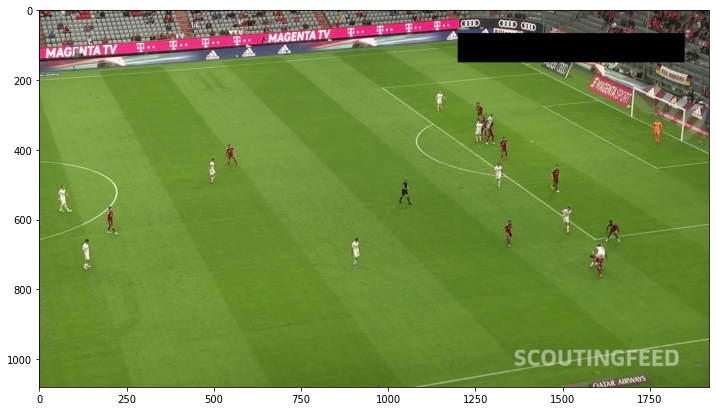

In [ ]:
idx = 135
img = tmp.loc[idx, 'image_path']
img = Image.open(img)
plt.figure(figsize=(12,8))
plt.imshow(img)

In [ ]:
# ====================================================
# Score 
# ====================================================
solution = df[['video_id', 'time', 'event']].copy()
event_names = ['challenge', 'throwin', 'play']
test_videos = test_folds.video_id.unique()
solution = solution['video_id'].isin(test_videos).reset_index(drop=True)

score = event_detection_ap(solution, valid_df[['video_id', 'time', 'event', 'score']], tolerances)

In [ ]:
config.model_names

['swin_large_patch4_window7_224',
 'beit_large_patch16_224',
 'swin_large_patch4_window12_384_in22k',
 'tf_efficientnet_b6_ns']

In [ ]:
# ==============================
# Dataset, Model 動作確認
# ==============================  

from torch.nn.parameter import Parameter

x_train = train.query('fold!=0')
y_train = x_train['target'].values
x_val = train.query('fold==0')
y_val = x_val.target.values


# Datasetの作成
train_dataset = ImageDataset(image_filepaths=x_train['image_path'].values, transform=image_transforms(IMG_SIZE=224, phase='train'), targets=y_train)

torch.Size([3, 224, 224])

In [ ]:
# ==============================
# Dataset, Model 動作確認
# ==============================  

from torch.nn.parameter import Parameter

x_train = train.query('fold!=0')
y_train = x_train['target'].values
x_val = train.query('fold==0')
y_val = x_val.target.values


# Datasetの作成
train_dataset = ImageDataset(image_filepaths=x_train['image_path'].values, transform=image_transforms(IMG_SIZE=224, phase='train'), targets=y_train)

# Dataloader
# num_workers = -1
train_loader = DataLoader(dataset=train_dataset, batch_size=16, shuffle=False)
# val_loader = DataLoader(dataset=val_, batch_size=BATCH_SIZE, shuffle=False, num_workers=num_workers)

# model
model_name = config.model_names[0]; fold = 0
model = ImageNet(model_name=model_name, pretrained=False)

# if save trained model :
model_param_dicts = torch.load(f"{SAVE_PATH}/{model_name}_fold{fold}_best.pth", map_location=torch.device(DEVICE))['model']
model.load_state_dict(model_param_dicts)

# optimizer
lr = 0.01
optimizer = AdamW(model.parameters(), lr=lr, betas=(0.9, 0.999))

# scheduler
n_epochs = 1
num_train_optimization_steps = int(len(train_loader) * n_epochs)
# scheduler = get_linear_schedule_with_warmup(optimizer,
#                                             num_warmup_steps=num_warmup_steps,
#                                             num_training_steps=num_train_optimization_steps)

# criterion
criterion = nn.CrossEntropyLoss()

# データの取り出し例
# 出力は、imgs_transformed, label, label_id, dir_path
index = 0
print(train_dataset.__getitem__(index)[0].shape)  # 画像たちのテンソル
print(train_dataset.__getitem__(index)[1])  # ラベル名

# ==============================
# Dataset, Model 動作確認
# ==============================  
prob = []
for i, d in enumerate(train_loader):
    x = d[0] # [batch, channel, w, h]
    y = d[1] # [batch]
    x, y = x.to(DEVICE), y.to(DEVICE)
    model.to(DEVICE)
    outputs = model(x)
    preds = nn.functional.softmax(outputs, dim=1).detach().cpu().numpy()
    prob.append(preds)

    loss = criterion(outputs, y.type(torch.long))
    preds = outputs.argmax(dim=1)

    loss.backward()
    optimizer.step()

    loss.item()

    if i>1:
        break

/usr/local/lib/python3.7/dist-packages/torch/functional.py:478: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2894.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


FileNotFoundError: ignored

In [ ]:
outputs

tensor([[ 0.0680, -2.6351,  1.7082,  1.9133],
        [ 0.1031, -2.6488,  1.7298,  1.9341],
        [-0.9674, -1.7651,  1.0275,  1.3825],
        [ 0.0689, -2.6361,  1.7092,  1.9145],
        [ 0.0694, -2.6367,  1.7098,  1.9151],
        [ 0.0692, -2.6338,  1.7088,  1.9137],
        [ 0.0695, -2.6369,  1.7099,  1.9153],
        [ 0.4496, -2.0441,  0.9001,  1.2159],
        [ 0.0687, -2.6358,  1.7090,  1.9142],
        [ 0.0768, -2.6475,  1.7210,  1.9282],
        [ 0.0739, -2.6397,  1.7160,  1.9215],
        [ 0.1034, -2.6456,  1.7288,  1.9325],
        [ 3.4655, -4.2497,  2.6056,  4.3729],
        [ 0.0677, -2.6347,  1.7078,  1.9129],
        [ 0.0733, -2.6391,  1.7154,  1.9208],
        [ 0.0689, -2.6365,  1.7093,  1.9146]], device='cuda:0',
       grad_fn=<AddmmBackward0>)

In [ ]:
pred = nn.functional.softmax(outputs, dim=1).detach().cpu().numpy()
# torch.sigmoid(outputs).detach().cpu().numpy()

array([[7.96623677e-02, 5.33699244e-03, 4.10747468e-01, 5.04253149e-01],
       [8.07060972e-02, 5.14954608e-03, 4.10545975e-01, 5.03598332e-01],
       [5.18485010e-02, 2.33517252e-02, 3.81188273e-01, 5.43611467e-01],
       [7.96456710e-02, 5.32587292e-03, 4.10728872e-01, 5.04299581e-01],
       [7.96393827e-02, 5.31942397e-03, 4.10713732e-01, 5.04327476e-01],
       [7.97157064e-02, 5.34130959e-03, 4.10781741e-01, 5.04161239e-01],
       [7.96377137e-02, 5.31775178e-03, 4.10708487e-01, 5.04335999e-01],
       [2.08181486e-01, 1.71971992e-02, 3.26656222e-01, 4.47965115e-01],
       [7.96545744e-02, 5.32933837e-03, 4.10734534e-01, 5.04281580e-01],
       [7.92953596e-02, 5.20103518e-03, 4.10485774e-01, 5.05017817e-01],
       [7.95091987e-02, 5.27121546e-03, 4.10754651e-01, 5.04464924e-01],
       [8.08207095e-02, 5.17231319e-03, 4.10624862e-01, 5.03382146e-01],
       [2.56297886e-01, 1.14310926e-04, 1.08468279e-01, 6.35119557e-01],
       [7.96672106e-02, 5.34119457e-03, 4.10754889e

In [ ]:
nn.Softmax(outputs)

Softmax(
  dim=tensor([[ 0.0680, -2.6351,  1.7082,  1.9133],
          [ 0.1031, -2.6488,  1.7298,  1.9341],
          [-0.9674, -1.7651,  1.0275,  1.3825],
          [ 0.0689, -2.6361,  1.7092,  1.9145],
          [ 0.0694, -2.6367,  1.7098,  1.9151],
          [ 0.0692, -2.6338,  1.7088,  1.9137],
          [ 0.0695, -2.6369,  1.7099,  1.9153],
          [ 0.4496, -2.0441,  0.9001,  1.2159],
          [ 0.0687, -2.6358,  1.7090,  1.9142],
          [ 0.0768, -2.6475,  1.7210,  1.9282],
          [ 0.0739, -2.6397,  1.7160,  1.9215],
          [ 0.1034, -2.6456,  1.7288,  1.9325],
          [ 3.4655, -4.2497,  2.6056,  4.3729],
          [ 0.0677, -2.6347,  1.7078,  1.9129],
          [ 0.0733, -2.6391,  1.7154,  1.9208],
          [ 0.0689, -2.6365,  1.7093,  1.9146]], device='cuda:0',
         grad_fn=<AddmmBackward0>)
)

In [ ]:
loss.item()

1.3141512870788574

In [ ]:
def make_train():
    csvs = glob.glob(OUTPUT_PATH+'/*.csv')
    datas = []
    for csv in csvs:
        tmp = pd.read_csv(csv)
        datas.append(tmp)
    train = pd.concat(datas).reset_index(drop=True)
    train = train.rename({'iamge_path':'image_path'}, axis=1)
    return train

In [ ]:
cnt = 0
not_exists = []
for path in tqdm(train['image_path'].values):
    if not os.path.exists(path):
        not_exists.append(path)
        cnt += 1

100%|██████████| 66140/66140 [00:12<00:00, 5428.04it/s]


In [ ]:
# ==============================
# ********** VIDEO ********** 
#  Transform, Dataset, Preprocess
# ==============================
class VideoTransform():
    """
    動画を画像にした画像ファイルの前処理クラス。学習時と推論時で異なる動作をします。
    動画を画像に分割しているため、分割された画像たちをまとめて前処理する点に注意してください。
    """

    def __init__(self, resize, crop_size, mean, std):
        self.data_transform = {
            'train': torchvision.transforms.Compose([
                # DataAugumentation()  # 今回は省略
                GroupResize(int(resize)),  # 画像をまとめてリサイズ　
                GroupCenterCrop(crop_size),  # 画像をまとめてセンタークロップ
                GroupToTensor(),  # データをPyTorchのテンソルに
                GroupImgNormalize(mean, std),  # データを標準化
                Stack()  # 複数画像をframes次元で結合させる
            ]),
            'val': torchvision.transforms.Compose([
                GroupResize(int(resize)),  # 画像をまとめてリサイズ　
                GroupCenterCrop(crop_size),  # 画像をまとめてセンタークロップ
                GroupToTensor(),  # データをPyTorchのテンソルに
                GroupImgNormalize(mean, std),  # データを標準化
                Stack()  # 複数画像をframes次元で結合させる
            ])
        }

    def __call__(self, img_group, phase):
        """
        Parameters
        ----------
        phase : 'train' or 'val'
            前処理のモードを指定。
        """
        return self.data_transform[phase](img_group)

class GroupResize():
    ''' 画像をまとめてリスケールするクラス。
    画像の短い方の辺の長さがresizeに変換される。
    アスペクト比は保たれる。
    '''

    def __init__(self, resize, interpolation=Image.BILINEAR):
        '''リスケールする処理を用意'''
        self.rescaler = torchvision.transforms.Resize(resize, interpolation)

    def __call__(self, img_group):
        '''リスケールをimg_group(リスト)内の各imgに実施'''
        return [self.rescaler(img) for img in img_group]


class GroupCenterCrop():
    ''' 画像をまとめてセンタークロップするクラス。
        （crop_size, crop_size）の画像を切り出す。
    '''

    def __init__(self, crop_size):
        '''センタークロップする処理を用意'''
        self.ccrop = torchvision.transforms.CenterCrop(crop_size)

    def __call__(self, img_group):
        '''センタークロップをimg_group(リスト)内の各imgに実施'''
        return [self.ccrop(img) for img in img_group]


class GroupToTensor():
    ''' 画像をまとめてテンソル化するクラス。
    '''

    def __init__(self):
        '''テンソル化する処理を用意'''
        self.to_tensor = torchvision.transforms.ToTensor()

    def __call__(self, img_group):
        '''テンソル化をimg_group(リスト)内の各imgに実施
        0から1ではなく、0から255で扱うため、255をかけ算する。
        0から255で扱うのは、学習済みデータの形式に合わせるため
        '''

        return [self.to_tensor(img)*255 for img in img_group]


class GroupImgNormalize():
    ''' 画像をまとめて標準化するクラス。
    '''

    def __init__(self, mean, std):
        '''標準化する処理を用意'''
        self.normlize = torchvision.transforms.Normalize(mean, std)

    def __call__(self, img_group):
        '''標準化をimg_group(リスト)内の各imgに実施'''
        return [self.normlize(img) for img in img_group]


class Stack():
    ''' 画像を一つのテンソルにまとめるクラス。
    '''

    def __call__(self, img_group):
        '''img_groupはtorch.Size([3, 224, 224])を要素とするリスト
        '''
        ret = torch.cat([(x.flip(dims=[0])).unsqueeze(dim=0).to(DEVICE)
                         for x in img_group], dim=0)  # frames次元で結合
        # x.flip(dims=[0])は色チャネルをRGBからBGRへと順番を変えています（元の学習データがBGRであったため）
        # unsqueeze(dim=0)はあらたにframes用の次元を作成しています

        return ret

class VideoDataset(torch.utils.data.Dataset):
    """
    動画のDataset
    """

    def __init__(self, video_list, label_id_dict, num_segments, phase, transform, img_tmpl='image_{:05d}.jpg'):
        self.video_list = video_list  # 動画画像のフォルダへのパスリスト
        self.label_id_dict = label_id_dict  # ラベル名をidに変換する辞書型変数
        self.num_segments = num_segments  # 動画を何分割して使用するのかを決める
        self.phase = phase  # train or val
        self.transform = transform  # 前処理
        self.img_tmpl = img_tmpl  # 読み込みたい画像のファイル名のテンプレート

    def __len__(self):
        '''動画の数を返す'''
        return len(self.video_list)

    def __getitem__(self, index):
        '''
        前処理をした画像たちのデータとラベル、ラベルIDを取得
        '''
        imgs_transformed, label, label_id, dir_path = self.pull_item(index)
        return imgs_transformed, label, label_id, dir_path

    def pull_item(self, index):
        '''前処理をした画像たちのデータとラベル、ラベルIDを取得'''

        # 1. 画像たちをリストに読み込む
        dir_path = self.video_list[index]  # 画像が格納されたフォルダ
        indices = self._get_indices(dir_path)  # 読み込む画像idxを求める
        img_group = self._load_imgs(
            dir_path, self.img_tmpl, indices)  # リストに読み込む

        # 2. ラベルの取得し、idに変換する
        label = (dir_path.split('/')[3].split('/')[0])
        label_id = self.label_id_dict[label] # idを取得

        # 3. 前処理を実施
        imgs_transformed = self.transform(img_group, phase=self.phase)

        return imgs_transformed, label, label_id, dir_path

    def _load_imgs(self, dir_path, img_tmpl, indices):
        '''画像をまとめて読み込み、リスト化する関数'''
        img_group = []  # 画像を格納するリスト

        for idx in indices:
            # 画像のパスを取得
            file_path = os.path.join(dir_path, img_tmpl.format(idx))

            # 画像を読み込む
            img = Image.open(file_path).convert('RGB')

            # リストに追加
            img_group.append(img)
        return img_group

    def _get_indices(self, dir_path):
        """
        動画全体をself.num_segmentに分割した際に取得する動画のidxのリストを取得する
        """
        # 動画のフレーム数を求める
        file_list = os.listdir(path=dir_path)
        num_frames = len(file_list)

        # 動画の取得間隔幅を求める
        tick = (num_frames) / float(self.num_segments)
        # 250 / 16 = 15.625
        # 動画の取得間隔幅で取り出す際のidxをリストで求める
        indices = np.array([int(tick / 2.0 + tick * x)
                            for x in range(self.num_segments)])+1
        # 250frameで16frame抽出の場合
        # indices = [  8  24  40  55  71  86 102 118 133 149 165 180 196 211 227 243]

        return indices


class VideoDataset(torch.utils.data.Dataset):
    """
    動画のDataset
    """
    def __init__(self, video_list, transform, target=None, phase='train', num=16):
        """
        video_list : video_path
        phase : train or val
        """

        self.video_list = video_list  # [batch, 1(video_path)] 動画画像のフォルダへのパスリスト
        self.target = target
        self.num = num
        self.phase = phase  # train or val
        self.transform = transform  # 前処理

    def __len__(self):
        '''動画の数を返す'''
        return len(self.video_list)

    def __getitem__(self, index):
        '''
        前処理をした画像たちのデータとラベル、ラベルIDを取得
        '''

        video_path = self.video_list[index]
        imgs = self._load_imgs(video_path)
        imgs = self.transform(imgs, self.phase)

        if self.target is not None:
            label = self.target[index]
            return imgs, label

        else:
            return imgs


    def _load_imgs(self, video_path):
        '''画像をまとめて読み込み、リスト化する関数'''
        
        cap = cv2.VideoCapture(video_path)
        now = 0
        images = []
        while now < self.num:
            ret, frame = cap.read()
            if ret:
                # frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
                frame = frame[:, :, ::-1]
                pil_image = Image.fromarray(frame) # torchvisionのtransformでPILの必要
                images.append(pil_image)

            else: # 読み込み異常時
                print(f'READING ERROR : {video_path}')
                tmp = np.zeros((1080, 1920, 3))
                pil_image = Image.fromarray(tmp) # torchvisionのtransformでPILの必要
                images.append(tmp)

            now += 1
        
        return images


In [ ]:
# ===============
# 動画の確認
# ===============    
file_name = '1606b0e6_0.mp4'
id = file_name.replace('.mp4', '')

file_name = INPUT_PATH+f'train/{file_name}'
pic_fname = OUTPUT_PATH + '/' + id + '/tmp.jpg'
video_fname = OUTPUT_PATH + '/' + id + '/tmp.mp4'
os.makedirs(OUTPUT_PATH+'/'+id, exist_ok=True)

cap = cv2.VideoCapture(file_name)
fps = cap.get(cv2.CAP_PROP_FPS)
frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
video_length = frame_count / fps         # 長さ（秒）を計算する
width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

ret, frame = cap.read()

In [ ]:
def extract_training_images(df_events, video_path, debug=False):

    df = df_events.copy()

    video_id = video_path.split('/')[-1].replace('.mp4', '')
    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        TODO
    fps = cap.get(cv2.CAP_PROP_FPS)
    time_interval = 1/fps

    df_video = df[df.video_id == video_id]
    df_video = df_video.sort_values(['video_id', 'time'])

    if debug:
        df_video = df_video.head(10)
    LOGGER.info(f'{video_id}, {df_video.shape}')

    #crr_statu => background, play, challenge, throwin
    arr = df_video[['time','event']].values

    rets = []
    background_step = 10

    exist_files = 0
    add_files = 0

    for idx in tqdm(range(len(arr)-1)):
        crr_time = arr[idx,0]
        nxt_time = arr[idx+1,0]
        crr_event = arr[idx,1]
        #print(crr_time, nxt_time, crr_event)

        crr_event = crr_event
        if crr_event == 'start':
            crr_status = 'background'
        elif crr_event == 'end':
            # should use as background?
            continue
        else:
            start_or_end, crr_status = crr_event.split('_', 1)
            if start_or_end == 'end':
                crr_status = 'background'

        result_dir = f"{OUTPUT_PATH}/{video_id}/{crr_status}"

        if not os.path.exists(result_dir):
            os.makedirs(result_dir, exist_ok=True)

        this_time = crr_time
        while this_time < nxt_time:
            frame_num = int(this_time*fps)

            out_file = f'{result_dir}/{video_id}_{frame_num:08}_{crr_status}.jpg'

            if os.path.exists(out_file):
                ret = {
                    "video_id": video_id,
                    "image_path": out_file,
                    "time": this_time,
                    "event": crr_status,
                    }
                rets.append(ret)
                exist_files += 1
                if crr_status == 'background':
                    this_time += time_interval*background_step
                else:
                    this_time += time_interval
                continue

            else:
                cap.set(cv2.CAP_PROP_POS_FRAMES, frame_num)
                ret, frame = cap.read()

                cv2.imwrite(out_file, frame)
                #print(out_file, arr[idx], arr[idx+1], this_time)

                ret = {
                    "video_id": video_id,
                    "image_path": out_file,
                    "time": this_time,
                    "event": crr_status,
                    }
                rets.append(ret)
                add_files += 1

                if crr_status == 'background':
                    this_time += time_interval*background_step
                else:
                    this_time += time_interval

    data = pd.DataFrame(rets)
    LOGGER.info(f'exist files : {exist_files}, add files : {add_files}')
    # data.to_csv(OUTPUT_PATH + f'/{video_id}_image_train_data.csv', index=False)

    return data


In [ ]:
video_paths = glob.glob(INPUT_PATH + '/train/*.mp4')
datas = []
for video_path in video_paths:
    data = extract_training_images(df_events, video_path, debug=False)
    datas.append(data)
print('done')

2022-08-17 09:12:39,486 - INFO - 1606b0e6_0, (1396, 4)
100%|██████████| 1395/1395 [44:18<00:00,  1.91s/it]
2022-08-17 09:56:58,457 - INFO - exist files : 5690, add files : 268
2022-08-17 09:56:59,125 - INFO - 1606b0e6_1, (1756, 4)
  0%|          | 0/1755 [00:02<?, ?it/s]


KeyboardInterrupt: ignored

In [ ]:
import glob
from bisect import bisect_left, bisect_right, insort

def save_non_event_movie(movie_path):
    """
    save 1sec event movies from (event_time - save_sec) to (event_time)
    """

    rets = []
    SAVE_PATH = OUTPUT_PATH + '/'+'non_event'
    os.makedirs(SAVE_PATH, exist_ok=True)

    for path in movie_path:
        id = path.split('/')[-1].replace('.mp4', '')
        
        cap = cv2.VideoCapture(path)
        frames = cap.get(cv2.CAP_PROP_FRAME_COUNT)# フレーム数を取得する
        fps = cap.get(cv2.CAP_PROP_FPS)          # フレームレートを取得する
        video_length = frames / fps         # 長さ（秒）を計算する
        video_length = int(video_length)

        events = df_rets.query('video_id == @id')['event_time'].values
        events = sorted(events.tolist())

        now = 0

        while now < video_length:

            l = bisect_left(events, now)

            if l==0:
                interval = 10
                pre = -10
                next = events[l]

            elif l==len(events):
                interval = 10
                pre = events[l-1]
                next = 10**9+7
            
            else:
                interval = 1.5
                pre = events[l-1]
                next = events[l]

            if abs(now - pre)<2 or abs(next - now)<2:
                now += interval
                continue

            save_path = SAVE_PATH + '/'+f'{id}_noevent_{now:.2f}.mp4'

            if os.path.exists(save_path):
                now += interval
                continue

            ret = {
                "video_id": id,
                "video_path": save_path,
                "start_time": now,
                "end_time": now+1.0,
                "event_time": -1,
                "event": 'No Event',
                }

            rets.append(ret)

            ffmpeg_extract_subclip(path, t1=now, t2=now+1, targetname=save_path)

            now += interval


    data = pd.DataFrame(rets)
    data.to_csv(OUTPUT_PATH + '/No_event_train_data.csv', index=False)

    return data

# train = save_event_movie(df_rets)

# movie_path = glob.glob(INPUT_PATH + '/train/*.mp4')
# data = save_non_event_movie(movie_path)

In [ ]:
# ===============
# ECO 2D Model
# ===============    

class BasicConv(nn.Module):
    '''ECOの2D Netモジュールの最初のモジュール'''

    def __init__(self):
        super(BasicConv, self).__init__()

        self.conv1_7x7_s2 = nn.Conv2d(3, 64, kernel_size=(
            7, 7), stride=(2, 2), padding=(3, 3))
        self.conv1_7x7_s2_bn = nn.BatchNorm2d(
            64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        self.conv1_relu_7x7 = nn.ReLU(inplace=True)
        self.pool1_3x3_s2 = nn.MaxPool2d(
            kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
        self.conv2_3x3_reduce = nn.Conv2d(
            64, 64, kernel_size=(1, 1), stride=(1, 1))
        self.conv2_3x3_reduce_bn = nn.BatchNorm2d(
            64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        self.conv2_relu_3x3_reduce = nn.ReLU(inplace=True)
        self.conv2_3x3 = nn.Conv2d(64, 192, kernel_size=(
            3, 3), stride=(1, 1), padding=(1, 1))
        self.conv2_3x3_bn = nn.BatchNorm2d(
            192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        self.conv2_relu_3x3 = nn.ReLU(inplace=True)
        self.pool2_3x3_s2 = nn.MaxPool2d(
            kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)

    def forward(self, x):
        out = self.conv1_7x7_s2(x)
        out = self.conv1_7x7_s2_bn(out)
        out = self.conv1_relu_7x7(out)
        out = self.pool1_3x3_s2(out)
        out = self.conv2_3x3_reduce(out)
        out = self.conv2_3x3_reduce_bn(out)
        out = self.conv2_relu_3x3_reduce(out)
        out = self.conv2_3x3(out)
        out = self.conv2_3x3_bn(out)
        out = self.conv2_relu_3x3(out)
        out = self.pool2_3x3_s2(out)
        return out

class InceptionA(nn.Module):
    '''InceptionA'''

    def __init__(self):
        super(InceptionA, self).__init__()

        self.inception_3a_1x1 = nn.Conv2d(
            192, 64, kernel_size=(1, 1), stride=(1, 1))
        self.inception_3a_1x1_bn = nn.BatchNorm2d(
            64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        self.inception_3a_relu_1x1 = nn.ReLU(inplace=True)

        self.inception_3a_3x3_reduce = nn.Conv2d(
            192, 64, kernel_size=(1, 1), stride=(1, 1))
        self.inception_3a_3x3_reduce_bn = nn.BatchNorm2d(
            64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        self.inception_3a_relu_3x3_reduce = nn.ReLU(inplace=True)
        self.inception_3a_3x3 = nn.Conv2d(
            64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        self.inception_3a_3x3_bn = nn.BatchNorm2d(
            64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        self.inception_3a_relu_3x3 = nn.ReLU(inplace=True)

        self.inception_3a_double_3x3_reduce = nn.Conv2d(
            192, 64, kernel_size=(1, 1), stride=(1, 1))
        self.inception_3a_double_3x3_reduce_bn = nn.BatchNorm2d(
            64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        self.inception_3a_relu_double_3x3_reduce = nn.ReLU(inplace=True)
        self.inception_3a_double_3x3_1 = nn.Conv2d(
            64, 96, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        self.inception_3a_double_3x3_1_bn = nn.BatchNorm2d(
            96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        self.inception_3a_relu_double_3x3_1 = nn.ReLU(inplace=True)
        self.inception_3a_double_3x3_2 = nn.Conv2d(
            96, 96, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        self.inception_3a_double_3x3_2_bn = nn.BatchNorm2d(
            96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        self.inception_3a_relu_double_3x3_2 = nn.ReLU(inplace=True)

        self.inception_3a_pool = nn.AvgPool2d(
            kernel_size=3, stride=1, padding=1)
        self.inception_3a_pool_proj = nn.Conv2d(
            192, 32, kernel_size=(1, 1), stride=(1, 1))
        self.inception_3a_pool_proj_bn = nn.BatchNorm2d(
            32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        self.inception_3a_relu_pool_proj = nn.ReLU(inplace=True)

    def forward(self, x):

        out1 = self.inception_3a_1x1(x)
        out1 = self.inception_3a_1x1_bn(out1)
        out1 = self.inception_3a_relu_1x1(out1)

        out2 = self.inception_3a_3x3_reduce(x)
        out2 = self.inception_3a_3x3_reduce_bn(out2)
        out2 = self.inception_3a_relu_3x3_reduce(out2)
        out2 = self.inception_3a_3x3(out2)
        out2 = self.inception_3a_3x3_bn(out2)
        out2 = self.inception_3a_relu_3x3(out2)

        out3 = self.inception_3a_double_3x3_reduce(x)
        out3 = self.inception_3a_double_3x3_reduce_bn(out3)
        out3 = self.inception_3a_relu_double_3x3_reduce(out3)
        out3 = self.inception_3a_double_3x3_1(out3)
        out3 = self.inception_3a_double_3x3_1_bn(out3)
        out3 = self.inception_3a_relu_double_3x3_1(out3)
        out3 = self.inception_3a_double_3x3_2(out3)
        out3 = self.inception_3a_double_3x3_2_bn(out3)
        out3 = self.inception_3a_relu_double_3x3_2(out3)

        out4 = self.inception_3a_pool(x)
        out4 = self.inception_3a_pool_proj(out4)
        out4 = self.inception_3a_pool_proj_bn(out4)
        out4 = self.inception_3a_relu_pool_proj(out4)

        outputs = [out1, out2, out3, out4]

        return torch.cat(outputs, 1)

class InceptionB(nn.Module):
    '''InceptionB'''

    def __init__(self):
        super(InceptionB, self).__init__()
        
        self.inception_3b_1x1 = nn.Conv2d(
            256, 64, kernel_size=(1, 1), stride=(1, 1))
        self.inception_3b_1x1_bn = nn.BatchNorm2d(
            64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        self.inception_3b_relu_1x1 = nn.ReLU(inplace=True)

        self.inception_3b_3x3_reduce = nn.Conv2d(
            256, 64, kernel_size=(1, 1), stride=(1, 1))
        self.inception_3b_3x3_reduce_bn = nn.BatchNorm2d(
            64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        self.inception_3b_relu_3x3_reduce = nn.ReLU(inplace=True)
        self.inception_3b_3x3 = nn.Conv2d(
            64, 96, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        self.inception_3b_3x3_bn = nn.BatchNorm2d(
            96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        self.inception_3b_relu_3x3 = nn.ReLU(inplace=True)

        self.inception_3b_double_3x3_reduce = nn.Conv2d(
            256, 64, kernel_size=(1, 1), stride=(1, 1))
        self.inception_3b_double_3x3_reduce_bn = nn.BatchNorm2d(
            64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        self.inception_3b_relu_double_3x3_reduce = nn.ReLU(inplace=True)
        self.inception_3b_double_3x3_1 = nn.Conv2d(
            64, 96, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        self.inception_3b_double_3x3_1_bn = nn.BatchNorm2d(
            96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        self.inception_3b_relu_double_3x3_1 = nn.ReLU(inplace=True)
        self.inception_3b_double_3x3_2 = nn.Conv2d(
            96, 96, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        self.inception_3b_double_3x3_2_bn = nn.BatchNorm2d(
            96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        self.inception_3b_relu_double_3x3_2 = nn.ReLU(inplace=True)

        self.inception_3b_pool = nn.AvgPool2d(
            kernel_size=3, stride=1, padding=1)
        self.inception_3b_pool_proj = nn.Conv2d(
            256, 64, kernel_size=(1, 1), stride=(1, 1))
        self.inception_3b_pool_proj_bn = nn.BatchNorm2d(
            64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        self.inception_3b_relu_pool_proj = nn.ReLU(inplace=True)

    def forward(self, x):
        
        out1 = self.inception_3b_1x1(x)
        out1 = self.inception_3b_1x1_bn(out1)
        out1 = self.inception_3b_relu_1x1(out1)

        out2 = self.inception_3b_3x3_reduce(x)
        out2 = self.inception_3b_3x3_reduce_bn(out2)
        out2 = self.inception_3b_relu_3x3_reduce(out2)
        out2 = self.inception_3b_3x3(out2)
        out2 = self.inception_3b_3x3_bn(out2)
        out2 = self.inception_3b_relu_3x3(out2)

        out3 = self.inception_3b_double_3x3_reduce(x)
        out3 = self.inception_3b_double_3x3_reduce_bn(out3)
        out3 = self.inception_3b_relu_double_3x3_reduce(out3)
        out3 = self.inception_3b_double_3x3_1(out3)
        out3 = self.inception_3b_double_3x3_1_bn(out3)
        out3 = self.inception_3b_relu_double_3x3_1(out3)
        out3 = self.inception_3b_double_3x3_2(out3)
        out3 = self.inception_3b_double_3x3_2_bn(out3)
        out3 = self.inception_3b_relu_double_3x3_2(out3)

        out4 = self.inception_3b_pool(x)
        out4 = self.inception_3b_pool_proj(out4)
        out4 = self.inception_3b_pool_proj_bn(out4)
        out4 = self.inception_3b_relu_pool_proj(out4)

        outputs = [out1, out2, out3, out4]

        return torch.cat(outputs, 1)

class InceptionC(nn.Module):
    '''InceptionC'''

    def __init__(self):
        super(InceptionC, self).__init__()

        self.inception_3c_double_3x3_reduce = nn.Conv2d(
            320, 64, kernel_size=(1, 1), stride=(1, 1))
        self.inception_3c_double_3x3_reduce_bn = nn.BatchNorm2d(
            64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        self.inception_3c_relu_double_3x3_reduce = nn.ReLU(inplace=True)
        self.inception_3c_double_3x3_1 = nn.Conv2d(
            64, 96, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        self.inception_3c_double_3x3_1_bn = nn.BatchNorm2d(
            96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        self.inception_3c_relu_double_3x3_1 = nn.ReLU(inplace=True)

    def forward(self, x):
        out = self.inception_3c_double_3x3_reduce(x)
        out = self.inception_3c_double_3x3_reduce_bn(out)
        out = self.inception_3c_relu_double_3x3_reduce(out)
        out = self.inception_3c_double_3x3_1(out)
        out = self.inception_3c_double_3x3_1_bn(out)
        out = self.inception_3c_relu_double_3x3_1(out)

        return out

# ===============
# ECO 3D Net Module
# ===============    

class Resnet_3D_3(nn.Module):
    '''Resnet_3D_3'''

    def __init__(self):
        super(Resnet_3D_3, self).__init__()
        
        self.res3a_2 = nn.Conv3d(96, 128, kernel_size=(
            3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
        
        self.res3a_bn = nn.BatchNorm3d(
            128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        self.res3a_relu = nn.ReLU(inplace=True)

        self.res3b_1 = nn.Conv3d(128, 128, kernel_size=(
            3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
        self.res3b_1_bn = nn.BatchNorm3d(
            128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        self.res3b_1_relu = nn.ReLU(inplace=True)
        self.res3b_2 = nn.Conv3d(128, 128, kernel_size=(
            3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
        
        self.res3b_bn = nn.BatchNorm3d(
            128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        self.res3b_relu = nn.ReLU(inplace=True)

    def forward(self, x):

        residual = self.res3a_2(x)
        out = self.res3a_bn(residual)
        out = self.res3a_relu(out)

        out = self.res3b_1(out)
        out = self.res3b_1_bn(out)
        out = self.res3b_relu(out)
        out = self.res3b_2(out)

        out += residual

        out = self.res3b_bn(out)
        out = self.res3b_relu(out)

        return out

class Resnet_3D_4(nn.Module):
    '''Resnet_3D_4'''

    def __init__(self):
        super(Resnet_3D_4, self).__init__()

        self.res4a_1 = nn.Conv3d(128, 256, kernel_size=(
            3, 3, 3), stride=(2, 2, 2), padding=(1, 1, 1))
        self.res4a_1_bn = nn.BatchNorm3d(
            256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        self.res4a_1_relu = nn.ReLU(inplace=True)
        self.res4a_2 = nn.Conv3d(256, 256, kernel_size=(
            3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
        
        self.res4a_down = nn.Conv3d(128, 256, kernel_size=(
            3, 3, 3), stride=(2, 2, 2), padding=(1, 1, 1))
        
        self.res4a_bn = nn.BatchNorm3d(
            256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        self.res4a_relu = nn.ReLU(inplace=True)
        
        self.res4b_1 = nn.Conv3d(256, 256, kernel_size=(
            3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
        self.res4b_1_bn = nn.BatchNorm3d(
            256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        self.res4b_1_relu = nn.ReLU(inplace=True)
        self.res4b_2 = nn.Conv3d(256, 256, kernel_size=(
            3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
        
        self.res4b_bn = nn.BatchNorm3d(
            256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        self.res4b_relu = nn.ReLU(inplace=True)

    def forward(self, x):
        residual = self.res4a_down(x)

        out = self.res4a_1(x)
        out = self.res4a_1_bn(out)
        out = self.res4a_1_relu(out)

        out = self.res4a_2(out)

        out += residual

        residual2 = out

        out = self.res4a_bn(out)
        out = self.res4a_relu(out)

        out = self.res4b_1(out)

        out = self.res4b_1_bn(out)
        out = self.res4b_1_relu(out)

        out = self.res4b_2(out)

        out += residual2

        out = self.res4b_bn(out)
        out = self.res4b_relu(out)

        return out

class Resnet_3D_5(nn.Module):
    '''Resnet_3D_5'''

    def __init__(self):
        super(Resnet_3D_5, self).__init__()
        
        self.res5a_1 = nn.Conv3d(256, 512, kernel_size=(
            3, 3, 3), stride=(2, 2, 2), padding=(1, 1, 1))
        self.res5a_1_bn = nn.BatchNorm3d(
            512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        self.res5a_1_relu = nn.ReLU(inplace=True)
        self.res5a_2 = nn.Conv3d(512, 512, kernel_size=(
            3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
        
        self.res5a_down = nn.Conv3d(256, 512, kernel_size=(
            3, 3, 3), stride=(2, 2, 2), padding=(1, 1, 1))
        
        self.res5a_bn = nn.BatchNorm3d(
            512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        self.res5a_relu = nn.ReLU(inplace=True)
        
        self.res5b_1 = nn.Conv3d(512, 512, kernel_size=(
            3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
        self.res5b_1_bn = nn.BatchNorm3d(
            512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        self.res5b_1_relu = nn.ReLU(inplace=True)
        self.res5b_2 = nn.Conv3d(512, 512, kernel_size=(
            3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
        
        self.res5b_bn = nn.BatchNorm3d(
            512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        self.res5b_relu = nn.ReLU(inplace=True)

    def forward(self, x):
        residual = self.res5a_down(x)

        out = self.res5a_1(x)
        out = self.res5a_1_bn(out)
        out = self.res5a_1_relu(out)

        out = self.res5a_2(out)

        out += residual  # res5a

        residual2 = out

        out = self.res5a_bn(out)
        out = self.res5a_relu(out)

        out = self.res5b_1(out)

        out = self.res5b_1_bn(out)
        out = self.res5b_1_relu(out)

        out = self.res5b_2(out)

        out += residual2  # res5b

        out = self.res5b_bn(out)
        out = self.res5b_relu(out)

        return out


class ECO_2D(nn.Module):
    def __init__(self):
        super(ECO_2D, self).__init__()

        # BasicConvモジュール
        self.basic_conv = BasicConv()

        # Inceptionモジュール
        self.inception_a = InceptionA()
        self.inception_b = InceptionB()
        self.inception_c = InceptionC()

    def forward(self, x):
        '''
        入力xのサイズtorch.Size([batch_num, 3, 224, 224]))
        '''
        out = self.basic_conv(x)
        out = self.inception_a(out)
        out = self.inception_b(out)
        out = self.inception_c(out)

        return out

class ECO_3D(nn.Module):
    def __init__(self):
        super(ECO_3D, self).__init__()

        # 3D_Resnetジュール
        self.res_3d_3 = Resnet_3D_3()
        self.res_3d_4 = Resnet_3D_4()
        self.res_3d_5 = Resnet_3D_5()

        # Global Average Pooling
        self.global_pool = nn.AvgPool3d(
            kernel_size=(4, 7, 7), stride=1, padding=0)

    def forward(self, x):
        '''
        入力xのサイズtorch.Size([batch_num,frames, 96, 28, 28]))
        '''
        out = torch.transpose(x, 1, 2)  # テンソルの順番入れ替え
        out = self.res_3d_3(out)
        out = self.res_3d_4(out)
        out = self.res_3d_5(out)
        out = self.global_pool(out)
        
        # テンソルサイズを変更
        # torch.Size([batch_num, 512, 1, 1, 1])からtorch.Size([batch_num, 512])へ
        out =out.view(out.size()[0], out.size()[1])
        
        return out


class ECO_Lite(nn.Module):
    def __init__(self):
        super(ECO_Lite, self).__init__()

        # 2D Netモジュール
        self.eco_2d = ECO_2D()

        # 3D Netモジュール
        self.eco_3d = ECO_3D()

        # クラス分類の全結合層
        self.fc_final = nn.Linear(in_features=512, out_features=400, bias=True)

    def forward(self, x):
        '''
        入力xはtorch.Size([batch_num, num_segments=16, 3, 224, 224]))
        '''

        # 入力xの各次元のサイズを取得する
        bs, ns, c, h, w = x.shape

        # xを(bs*ns, c, h, w)にサイズ変換する
        out = x.view(-1, c, h, w)
        # （注釈）
        # PyTorchのConv2Dは入力のサイズが(batch_num, c, h, w)しか受け付けないため
        # (batch_num, num_segments, c, h, w)は処理できない
        # 今は2次元画像を独立に処理するので、num_segmentsはbatch_numの次元に押し込んでも良いため
        # (batch_num×num_segments, c, h, w)にサイズを変換する

        # 2D Netモジュール 出力torch.Size([batch_num×16, 96, 28, 28])
        out = self.eco_2d(out)

        # 2次元画像をテンソルを3次元用に変換する
        # num_segmentsをbatch_numの次元に押し込んだものを元に戻す
        out = out.view(-1, ns, 96, 28, 28)

        # 3D Netモジュール 出力torch.Size([batch_num, 512])
        out = self.eco_3d(out)

        # クラス分類の全結合層　出力torch.Size([batch_num, class_num=400])
        out = self.fc_final(out)

        return out

In [ ]:
# ==============================
# Dataset, Model 動作確認
# ==============================  

def load_pretrained_ECO(model_dict, pretrained_model_dict):
    '''ECOの学習済みモデルをロードする関数
    今回構築したECOは学習済みモデルとレイヤーの順番は同じだが名前が異なる
    '''

    # 現在のネットワークモデルのパラメータ名
    param_names = []  # パラメータの名前を格納していく
    for name, param in model_dict.items():
        param_names.append(name)

    # 現在のネットワークの情報をコピーして新たなstate_dictを作成
    new_state_dict = model_dict.copy()

    # 新たなstate_dictに学習済みの値を代入
    # print("学習済みのパラメータをロードします")
    for index, (key_name, value) in enumerate(pretrained_model_dict.items()):
        name = param_names[index]  # 現在のネットワークでのパラメータ名を取得
        new_state_dict[name] = value  # 値を入れる

        # 何から何にロードされたのかを表示
        # print(str(key_name)+"→"+str(name))

    return new_state_dict

# pretrained model
eco_pretrained_params = torch.load(f'{WEIGHT_PATH}/ECO_Lite_rgb_model_Kinetics.pth.tar')# , map_location=torch.device(DEVICE))
eco_state_dict = eco_pretrained_params['state_dict']

# params name modified
model = ECO_Lite()
model_dict = model.state_dict()
eco_state_dict = load_pretrained_ECO(model_dict, eco_state_dict)

# model load parameters
model.load_state_dict(eco_state_dict)

# add classifier layer
model.fc_final = nn.Linear(in_features=model.fc_final.in_features, out_features=4)

In [ ]:
# ==============================
# Dataset, Model 動作確認
# ==============================  

from torch.nn.parameter import Parameter

x_train = train.query('fold!=0')
y_train = x_train['target'].values
x_val = train.query('fold==0')
y_val = x_val.target.values

# 前処理の設定
resize, crop_size = 224, 224
mean, std = [104, 117, 123], [1, 1, 1]
video_transform = VideoTransform(resize, crop_size, mean, std)

# Datasetの作成
train_dataset = VideoDataset(video_list=x_train['video_path'].values, transform=video_transform, target=y_train, phase='train')

# Dataloader
# num_workers = -1
train_loader = DataLoader(dataset=train_dataset, batch_size=8, shuffle=True)
# val_loader = DataLoader(dataset=val_, batch_size=BATCH_SIZE, shuffle=False, num_workers=num_workers)

# optimizer
lr = 0.01
optimizer = AdamW(model.parameters(), lr=lr, betas=(0.9, 0.999))

# scheduler
n_epochs = 1
num_train_optimization_steps = int(len(train_loader) * n_epochs)
# scheduler = get_linear_schedule_with_warmup(optimizer,
#                                             num_warmup_steps=num_warmup_steps,
#                                             num_training_steps=num_train_optimization_steps)

# criterion
criterion = nn.CrossEntropyLoss()

# データの取り出し例
# 出力は、imgs_transformed, label, label_id, dir_path
index = 0
print(train_dataset.__getitem__(index)[0].shape)  # 画像たちのテンソル
print(train_dataset.__getitem__(index)[1])  # ラベル名

/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:333: UserWarning: Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. Please use InterpolationMode enum.
  "Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. "
/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


torch.Size([16, 3, 224, 224])
0


In [ ]:
# ==============================
# Dataset, Model 動作確認
# ==============================  
for d in train_loader:
    x = d[0] # [batch, frames, channel, w, h]
    y = d[1] # [batch]
    x, y = x.to(DEVICE), y.to(DEVICE)
    model.to(DEVICE)
    outputs = model(x)

    loss = criterion(outputs, y)
    preds = outputs.argmax(dim=1)

    loss.backward()
    optimizer.step()

    loss.item()

    break

RuntimeError: ignored

In [ ]:
# ====================================================
# helper function
# ====================================================

def train_fn(fold, loader, model, criterion, optimizer, scheduler):
    losses, lrs = [], []
    model.to(device)
    model.train()
    optimizer.zero_grad()
    for step, (x, y) in enumerate(loader):
        x, y = x.to(device), y.to(device)
        batch_size = x.size(0)

        outputs = model(x)
        loss = criterion(outputs, y)

        preds = outputs.argmax(dim=1)
        
        losses.append(loss.item())
        step_lr = np.array([param_group["lr"] for param_group in optimizer.param_groups]).mean()
        lrs.append(step_lr)
        
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        scheduler.step()

        if step % config.print_freq == 0 or step == (len(loader)-1):
            LOGGER.info('Step: [{0}/{1}]  '
                        'Loss AVG: {loss_avg:.4f}) '
                        'LR: {lr:.6f}  '
                        .format(
                        step, len(loader),
                        loss_avg = np.array(losses).mean(),
                        lr=scheduler.get_lr()[0],
                        )
                        )
        # wandb.log({f"[fold{fold}] loss": losses.val,
        #            f"[fold{fold}] lr": scheduler.get_lr()[0]})

    return np.array(losses).mean(), np.array(lrs).mean()

def valid_fn(model, loader, criterion):
    losses, predicts = [], []
    model.to(device)
    model.eval()
    for step, (x, y) in enumerate(loader):
        x, y = x.to(device), y.to(device)
        batch_size = x.shape[0]
        with torch.no_grad():
            preds = model(x)
            preds = outputs.argmax(dim=1)

        loss = criterion(outputs, y)
        losses.append(loss.item())

        predicts.append(preds.reshape(-1).detach().cpu().numpy())

        if step % config.print_freq == 0 or step == (len(loader)-1):
            LOGGER.info('Step: [{0}/{1}]  '
                        'Loss AVG: {loss_avg:.4f}) '
                        .format(
                        step, len(loader),
                        loss_avg = np.array(losses).mean(),
                        )
                        )
    preds = np.concatenate(predicts)

    return np.array(losses).mean(), preds


def inference_fn(test_loader, model):
    model.eval()
    model.to(device)
    predicts = []
    tk0 = tqdm(enumerate(test_loader), total=len(test_loader))
    for step, (x, y) in tk0:
        x = x.to(device)
        with torch.no_grad():
            preds = model(x)
            preds = outputs.argmax(dim=1)
        predicts.append(preds.view(-1).detach().cpu().numpy())

    preds = np.concatenate(predicts)
    return preds


# ====================================================
# Scheduler
# Guide : https://www.kaggle.com/code/isbhargav/guide-to-pytorch-learning-rate-scheduling/notebook
# ====================================================
def get_scheduler(optimizer, num_train_steps):
    if config.scheduler=='linear':
        scheduler = get_linear_schedule_with_warmup(
            optimizer, num_warmup_steps=config.num_warmup_steps, num_training_steps=num_train_steps
        )
    elif config.scheduler=='cosine':
        scheduler = get_cosine_schedule_with_warmup(
            optimizer, num_warmup_steps=config.num_warmup_steps, num_training_steps=num_train_steps, num_cycles=config.num_cycles
        )
    elif config.scheduler=='ReduceLROnPlateau':
        scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=config.factor, patience=config.patience, verbose=True, eps=config.eps)
    elif config.scheduler=='CosineAnnealingLR':
        scheduler = CosineAnnealingLR(optimizer, T_max=config.T_max, eta_min=config.min_lr, last_epoch=-1)
    elif config.scheduler=='CosineAnnealingWarmRestarts':
        scheduler = CosineAnnealingWarmRestarts(optimizer, T_0=config.T_0, T_mult=1, eta_min=config.min_lr, last_epoch=-1)
    return scheduler


# ====================================================
# train loop
# ====================================================
def load_pretrained_ECO(model_dict, pretrained_model_dict):
    '''ECOの学習済みモデルをロードする関数
    今回構築したECOは学習済みモデルとレイヤーの順番は同じだが名前が異なる
    '''

    # 現在のネットワークモデルのパラメータ名
    param_names = []  # パラメータの名前を格納していく
    for name, param in model_dict.items():
        param_names.append(name)

    # 現在のネットワークの情報をコピーして新たなstate_dictを作成
    new_state_dict = model_dict.copy()

    # 新たなstate_dictに学習済みの値を代入
    # print("学習済みのパラメータをロードします")
    for index, (key_name, value) in enumerate(pretrained_model_dict.items()):
        name = param_names[index]  # 現在のネットワークでのパラメータ名を取得
        new_state_dict[name] = value  # 値を入れる

        # 何から何にロードされたのかを表示
        # print(str(key_name)+"→"+str(name))

    return new_state_dict

def train_loop(df, fold):

    LOGGER.info(f"========== fold: {fold} training ==========")

    # ====================================================
    # loader
    # ====================================================
    trn_idx = df[df['fold'] != fold].index
    val_idx = df[df['fold'] == fold].index
    
    train_folds = df.loc[trn_idx].reset_index(drop=True)
    valid_folds = df.loc[val_idx].reset_index(drop=True)
    # y_true = valid_folds['target'].values
    y_true = valid_folds.query('event!="No Event"')[['video_id', 'event_time', 'event']].reset_index(drop=True).rename({'event_time':'time'}, axis=1)
    y_pred = valid_folds[['video_id', 'event_time']].rename({'event_time':'time'}, axis=1)

    # 前処理の設定
    resize, crop_size = 224, 224
    mean, std = [104, 117, 123], [1, 1, 1]
    video_transform = VideoTransform(resize, crop_size, mean, std)

    # Datasetの作成
    train_dataset = VideoDataset(video_list=train_folds['video_path'].values, transform=video_transform, target=train_folds['target'].values, phase='train')
    valid_dataset = VideoDataset(video_list=valid_folds['video_path'].values, transform=video_transform, target=train_folds['target'].values, phase='val')

    # Dataloader
    train_loader = DataLoader(train_dataset,
                              batch_size=config.BATCH_SIZE,
                              shuffle=True,
                              drop_last=True)
                            #   num_workers=config.NUM_WORKERS, pin_memory=True, drop_last=True)
    valid_loader = DataLoader(valid_dataset,
                              batch_size=config.BATCH_SIZE,
                              shuffle=False,
                              drop_last=False)
                            #   num_workers=config.NUM_WORKERS, pin_memory=True, drop_last=False)

    # ====================================================
    # model & optimizer & scheduler & criterion
    # ====================================================

    # pretrained model
    eco_pretrained_params = torch.load(f'{WEIGHT_PATH}/ECO_Lite_rgb_model_Kinetics.pth.tar')# , map_location=torch.device(DEVICE))
    eco_state_dict = eco_pretrained_params['state_dict']

    # params name modified
    model = ECO_Lite()
    model_dict = model.state_dict()
    eco_state_dict = load_pretrained_ECO(model_dict, eco_state_dict)

    # model load parameters
    model.load_state_dict(eco_state_dict)

    # modify classifier layer
    model.fc_final = nn.Linear(in_features=model.fc_final.in_features, out_features=4)

    optimizer = AdamW(model.parameters(), lr=config.LR, weight_decay=config.WEIGHT_DECAY)

    num_train_steps = int(len(train_folds)*config.EPOCHS/config.BATCH_SIZE)
    
    scheduler = get_scheduler(optimizer, num_train_steps)

    criterion = nn.CrossEntropyLoss()

    # ====================================================
    # loop
    # ====================================================

    best_score = -1 * np.inf

    for epoch in range(config.EPOCHS):

        start_time = time.time()

        # train
        avg_loss, avg_lr = train_fn(fold, train_loader, model, criterion, optimizer, scheduler)

        # eval
        avg_val_loss, preds = valid_fn(model, valid_loader, criterion)
        
        if isinstance(scheduler, ReduceLROnPlateau):
            scheduler.step(avg_val_loss)
        elif isinstance(scheduler, CosineAnnealingLR):
            scheduler.step()
        elif isinstance(scheduler, CosineAnnealingWarmRestarts):
            scheduler.step()

        # scoring
        y_pred['target'] = preds
        y_pred['event'] = y_pred['target'].map(config.r_target_dic)
        y_pred = y_pred.drop(['target'], axis=1)
        y_pred['score'] = 1

        score = event_detection_ap(solution=y_true, submission=y_pred, tolerances=tolerances)

        ###################################
        # score = avg_val_loss
        ###################################

        elapsed = time.time() - start_time

        LOGGER.info(f'Epoch {epoch+1} - avg_train_loss: {avg_loss:.4f}  avg_val_loss: {avg_val_loss:.4f}  time: {elapsed:.0f}s')
        LOGGER.info(f'Epoch {epoch+1} - Score (without expiratory phase): {score:.4f}')
        # wandb.log({f"[fold{fold}] epoch": epoch+1, 
        #            f"[fold{fold}] avg_train_loss": avg_loss, 
        #            f"[fold{fold}] avg_val_loss": avg_val_loss,
        #            f"[fold{fold}] score": score})
        
        if score > best_score:
            best_score = score
            LOGGER.info(f'Epoch {epoch+1} - Save Best Score: {score:.4f} Model')
            torch.save({'model': model.state_dict(),
                        'preds': preds},
                        OUTPUT_PATH+f"/fold{fold}_best.pth")
            
    preds = torch.load(OUTPUT_PATH+f"/fold{fold}_best.pth", map_location=torch.device('cpu'))['preds']
    valid_folds['preds'] = preds

    # valid_folds.to_csv(OUTPUT_PATH+f"/{fold}_valid_folds.csv", index=False)

    torch.cuda.empty_cache()
    gc.collect()
    
    return valid_folds

# ====================================================
# main
# ====================================================
def main():
    
    """
    Prepare: 1.train 2.test
    """
    
    def get_result(result_df):
        y_true = result_df.query('event!="No Event"')[['video_id', 'event_time', 'event']].reset_index(drop=True).rename({'event_time':'time'}, axis=1)
        y_pred = result_df[['video_id', 'event_time', 'target']].rename({'event_time':'time'}, axis=1)

        y_pred['event'] = y_pred['target'].map(config.r_target_dic)
        y_pred = y_pred.drop(['target'], axis=1)
        y_pred['score'] = 1

        score = event_detection_ap(solution=y_true, submission=y_pred, tolerances=tolerances)
        LOGGER.info(f'Score (without expiratory phase): {score:<.4f}')
    
    if config.is_train:
        # train 
        oof_df = pd.DataFrame()
        for fold in range(config.N_FOLD):
            _oof_df = train_loop(train, fold)
            oof_df = pd.concat([oof_df, _oof_df])
            LOGGER.info(f"========== fold: {fold} result ==========")
            get_result(_oof_df)
        # CV result
        LOGGER.info(f"========== CV ==========")
        get_result(oof_df)
        # save result
        oof_df.to_csv(OUTPUT_PATH+'/oof_df.csv', index=False)
    
    # if config.is_inference:
    #     test_dataset = TestDataset(test)
    #     test_loader = DataLoader(test_dataset, batch_size=CFG.batch_size * 2, shuffle=False, num_workers=CFG.num_workers, pin_memory=True)
    #     for fold in CFG.trn_fold:
    #         model = CustomModel(CFG)
    #         path = OUTPUT_DIR+f"fold{fold}_best.pth"
    #         state = torch.load(path, map_location=torch.device('cpu'))
    #         model.load_state_dict(state['model'])
    #         predictions = inference_fn(test_loader, model, device)
    #         test[f'fold{fold}'] = predictions
    #         del state, predictions; gc.collect()
    #         torch.cuda.empty_cache()
    #     # submission
    #     test['pressure'] = test[[f'fold{fold}' for fold in range(CFG.n_fold)]].mean(1)
    #     test[['id', 'pressure']+[f'fold{fold}' for fold in range(CFG.n_fold)]].to_csv(OUTPUT_DIR+'raw_submission.csv', index=False)
    #     test[['id', 'pressure']].to_csv(OUTPUT_DIR+'submission.csv', index=False)
    
    # # wandb.finish()


if __name__ == "__main__":
    main()

2022-08-15 14:00:27,771 - INFO - ========== fold: 0 training ==========
/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:333: UserWarning: Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. Please use InterpolationMode enum.
  "Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. "
/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:729: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)


Step: [0/2660]  Loss AVG: 1.2201) LR: 0.004990  
Step: [20/2660]  Loss AVG: 1.6073) LR: 0.002978  
Step: [40/2660]  Loss AVG: 1.3517) LR: 0.000318  
Step: [60/2660]  Loss AVG: 1.2533) LR: 0.000690  


KeyboardInterrupt: ignored

In [ ]:
for path in tqdm(train['video_path'].values):
    if not os.path.exists(path):
        print(path)

100%|██████████| 32102/32102 [00:46<00:00, 692.49it/s] 


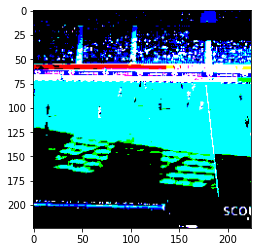

In [ ]:
plt.imshow(x[0][0].numpy().transpose(1,2,0))

<All keys matched successfully>

In [ ]:
# ===============
# 動画の確認
# ===============    
file_name = '1606b0e6_0.mp4'
id = file_name.replace('.mp4', '')

file_name = INPUT_PATH+f'train/{file_name}'
pic_fname = OUTPUT_PATH + '/' + id + '/tmp.jpg'
video_fname = OUTPUT_PATH + '/' + id + '/tmp.mp4'
os.makedirs(OUTPUT_PATH+'/'+id, exist_ok=True)

cap = cv2.VideoCapture(file_name)
fps = cap.get(cv2.CAP_PROP_FPS)
frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
video_length = frame_count / fps         # 長さ（秒）を計算する
width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

idx = 0
fourcc = cv2.VideoWriter_fourcc(*"VP90")
# save movie
# writer = cv2.VideoWriter(
#     filename=video_fname, 
#     fourcc=fourcc, 
#     fps=int(fps),
#     frameSize=(width, height + 150+len(df_ret)*50),
# )

while True:
    ret, frame = cap.read()
    if not ret:
        break 
    break

In [ ]:
# ===============
# 動画の保存
# ===============  
def save_event_movie(df_rets):
    """
    save 1sec event movies from (event_time - save_sec) to (event_time)
    """

    import math
    frames = 16
    fps = 25
    save_sec = math.ceil(((frames-4)/fps)*10)/10
    save_cnt = int(save_sec * 10)
    save_duration = 1.0
    total = len(df_rets)

    rets = []

    for i, (id, event_time, event) in enumerate(df_rets[['video_id', 'event_time', 'event']].values):

        if i%200==0:
            print(f' ======== now {i} files finished =========')

        file_name = INPUT_PATH+f'train/{id}.mp4'
        os.makedirs(OUTPUT_PATH + '/'+id, exist_ok=True)

        for t in range(save_cnt):
            min_time = event_time - 0.1*t
            max_time = min_time + 1.0
            print(min_time, max_time, event)

            save_path = OUTPUT_PATH + '/'+id+f'/{event}_{min_time:.2f}.mp4'

            ret = {
                "video_id": id,
                "video_path": save_path,
                "start_time": min_time,
                "end_time": max_time,
                "event_time": event_time,
                "event": event,
                }
            rets.append(ret)

            if os.path.exists(save_path):
                continue

            ffmpeg_extract_subclip(file_name, t1=min_time, t2=max_time, targetname=save_path)

    data = pd.DataFrame(rets)
    data.to_csv(OUTPUT_PATH + '/train_data.csv', index=False)

    return data


In [ ]:
import glob
from bisect import bisect_left, bisect_right, insort

def save_non_event_movie(movie_path):
    """
    save 1sec event movies from (event_time - save_sec) to (event_time)
    """

    rets = []
    SAVE_PATH = OUTPUT_PATH + '/'+'non_event'
    os.makedirs(SAVE_PATH, exist_ok=True)

    for path in movie_path:
        id = path.split('/')[-1].replace('.mp4', '')
        
        cap = cv2.VideoCapture(path)
        frames = cap.get(cv2.CAP_PROP_FRAME_COUNT)# フレーム数を取得する
        fps = cap.get(cv2.CAP_PROP_FPS)          # フレームレートを取得する
        video_length = frames / fps         # 長さ（秒）を計算する
        video_length = int(video_length)

        events = df_rets.query('video_id == @id')['event_time'].values
        events = sorted(events.tolist())

        now = 0

        while now < video_length:

            l = bisect_left(events, now)

            if l==0:
                interval = 10
                pre = -10
                next = events[l]

            elif l==len(events):
                interval = 10
                pre = events[l-1]
                next = 10**9+7
            
            else:
                interval = 1.5
                pre = events[l-1]
                next = events[l]

            if abs(now - pre)<2 or abs(next - now)<2:
                now += interval
                continue

            save_path = SAVE_PATH + '/'+f'{id}_noevent_{now:.2f}.mp4'

            if os.path.exists(save_path):
                now += interval
                continue

            ret = {
                "video_id": id,
                "video_path": save_path,
                "start_time": now,
                "end_time": now+1.0,
                "event_time": -1,
                "event": 'No Event',
                }

            rets.append(ret)

            ffmpeg_extract_subclip(path, t1=now, t2=now+1, targetname=save_path)

            now += interval


    data = pd.DataFrame(rets)
    data.to_csv(OUTPUT_PATH + '/No_event_train_data.csv', index=False)

    return data

# train = save_event_movie(df_rets)

# movie_path = glob.glob(INPUT_PATH + '/train/*.mp4')
# data = save_non_event_movie(movie_path)

In [ ]:
# train = save_event_movie(df_rets)

# movie_path = glob.glob(INPUT_PATH + '/train/*.mp4')
# data = save_non_event_movie(movie_path)

In [ ]:
from matplotlib import animation, rc
rc('animation', html='jshtml')

def save_event_movie(df_rets):
    """
    save event movies
    """
    progress = 0
    total = len(df_rets)
    for i, (id, t, event) in enumerate(df_rets[['video_id', 'event_time', 'event']].values):

        if i%400:
            print(f'now {i} files finished')

        file_name = INPUT_PATH+f'train/{id}.mp4'
        os.makedirs(OUTPUT_PATH + '/'+id, exist_ok=True)

        min_time = t - min(tolerances[event])
        max_time = t + min(tolerances[event])
        print(min_time, max_time, event)

        target_name = OUTPUT_PATH + '/'+id+f'/{event}_{t}.mp4'

        ffmpeg_extract_subclip(file_name, t1=min_time, t2=max_time, targetname=target_name)


def save_interval_movie(path):
    """
    save event movies
    """
    cap = cv2.VideoCapture(path)
    frames = cap.get(cv2.CAP_PROP_FRAME_COUNT)# フレーム数を取得する
    fps = cap.get(cv2.CAP_PROP_FPS)          # フレームレートを取得する
    video_length = frames / fps         # 長さ（秒）を計算する
    video_length = int(video_length)
    print(video_length)
    
    id = path.split('/')[-1].replace('.mp4', '')
    
    for i in range(0, video_length, 1):

        if i%100==0:
            print(f'now {i} files finished')

        os.makedirs(OUTPUT_PATH + '/'+id, exist_ok=True)

        min_time = i
        max_time = i + 1

        target_name = OUTPUT_PATH + '/'+id+f'/{i}.mp4'

        ffmpeg_extract_subclip(path, t1=min_time, t2=max_time, targetname=target_name)
        


In [ ]:
# ===============
# 動作確認
# ===============    

# DataLoaderにします
batch_size = 8
val_dataloader = torch.utils.data.DataLoader(
    val_dataset, batch_size=batch_size, shuffle=False)

# 動作確認
batch_iterator = iter(val_dataloader)  # イテレータに変換
imgs_transformeds, labels, label_ids, dir_path = next(
    batch_iterator)  # 1番目の要素を取り出す
print(imgs_transformeds.shape)

In [ ]:
# 動作確認
# モデルの用意
net = ECO_2D()
net.train()

# モデルの用意
net = ECO_3D()
net.train()

In [ ]:
# 1. tensorboardXの保存クラスを呼び出します
from tensorboardX import SummaryWriter

# 2. フォルダ「tbX」に保存させるwriterを用意します
# フォルダ「tbX」はなければ自動で作成されます
writer = SummaryWriter("./tbX/")

# 3. ネットワークに流し込むダミーデータを作成します
batch_size = 1
dummy_img = torch.rand(batch_size, 16, 96, 28, 28)

# 4. netに対して、ダミーデータである
# dummy_imgを流したときのgraphをwriterに保存させます
writer.add_graph(net, (dummy_img, ))
writer.close()

In [ ]:
def create_animation(movie_path):

    cap = cv2.VideoCapture(movie_path)
    fps = cap.get(cv2.CAP_PROP_FPS)
    frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

    ims = []
    while True:
        ret, frame = cap.read()
        if not ret:
            break
        ims.append(frame)

    fig = plt.figure(figsize=(6, 6))
    plt.axis('off')
    im = plt.imshow(ims[0], cmap="gray")

    def animate_func(i):
        im.set_array(ims[i])
        return [im]

    return animation.FuncAnimation(fig, animate_func, frames=len(ims), interval=1000 // 24)

target_name = '/content/drive/MyDrive/Competitions/DFL/output/1606b0e6_0/challenge_497.23.mp4'
create_animation(target_name)

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
cap = cv2.VideoCapture(target_name)
ret, frame = cap.read()
ret

False

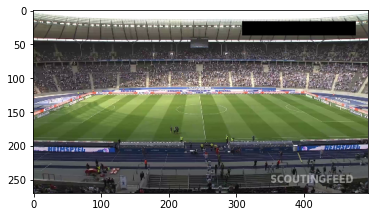

In [ ]:
from PIL import Image
img = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
# img = cv2.resize(img, (495, 270))
plt.imshow(img)

In [ ]:
frame_count, fps

(89750, 25.0)

## Easy Examples

In [ ]:
# Label data: play(time=1-3), throwin(time=11-13), challenge(time=21-23)
df_case1 = pd.DataFrame({
    "video_id": ["case1"] * 9, 
    "time": [1, 2, 3] + [11, 12, 13] + [21, 22, 23],
    "event": ["start", "play", "end"] + ["start", "challenge", "end"] + ["start", "throwin", "end"]
})
df_case1

,video_id,time,event
0,case1,1,start
1,case1,2,play
2,case1,3,end
3,case1,11,start
4,case1,12,challenge
5,case1,13,end
6,case1,21,start
7,case1,22,throwin
8,case1,23,end


### Prediction test case

## case1. perfect submission

In [ ]:
df_pred1

,video_id,time,event,score


In [ ]:
df_pred1 = pd.DataFrame({
    "video_id": ["case1"] * 3,
    "time": [2, 12, 22],
    # "event": ["play", "challenge", "throwin"],
    # "event": ["play", "challenge", "throwin"],
    "event": ["background", "background", "background"],
    "score": [1, 1, 1]
})
event_detection_ap(solution=df_case1, submission=df_pred1, tolerances=tolerances)

detection_matched: 
 Empty DataFrame
Columns: [event, tolerance, video_id, time, score, matched]
Index: []
ap_table: 
 Empty DataFrame
Columns: [event, tolerance, video_id, time, score, matched]
Index: []


ValueError: ignored

## case2. predict play -0.3sec

In [ ]:
# Average Precision = (1 + 1 + 0.2) / 3 = 0.7333
#   play: 0.2 (n_prediction=5, n_correct=1(failed to predict torelances [0.15, 0.20, 0.25, 0.30]))
#   challenge: 1
#   throwin: 1

# [Example] In case of event "play" or "throwin", if answer is time=2:
#   get 1.0(5/5) score if you predict play time 1.85 ~ 2.15
#   get 0.8(4/5) score if you predict play time 1.80 ~ 1.85 or 2.15 ~ 2.20
#   get 0.6(3/5) score if you predict play time 1.75 ~ 1.80 or 2.20 ~ 2.25
#   get 0.4(2/5) score if you predict play time 1.70 ~ 1.75 or 2.25 ~ 2.30
#   get 0.2(1/5) score if you predict play time 1.65 ~ 1.70 or 2.30 ~ 2.35
#   get 0.0(0/5) score if you predict play time ~ 1.65 or 2.35 ~

df_pred1 = pd.DataFrame({
    "video_id": ["case1"] * 4,
    "time": [1.7, 2.0, 12, 22],
    "event": ["play", "play", "challenge", "throwin"],
    "score": [1, 1, 1, 1]
})
event_detection_ap(solution=df_case1, submission=df_pred1, tolerances=tolerances)

detection_matched: 
         event  tolerance video_id  time  score  matched
0   challenge       0.30    case1  12.0      1     True
1   challenge       0.40    case1  12.0      1     True
2   challenge       0.50    case1  12.0      1     True
3   challenge       0.60    case1  12.0      1     True
4   challenge       0.70    case1  12.0      1     True
5        play       0.15    case1   1.7      1    False
6        play       0.15    case1   2.0      1     True
7        play       0.20    case1   1.7      1    False
8        play       0.20    case1   2.0      1     True
9        play       0.25    case1   1.7      1    False
10       play       0.25    case1   2.0      1     True
11       play       0.30    case1   1.7      1    False
12       play       0.30    case1   2.0      1     True
13       play       0.35    case1   1.7      1     True
14       play       0.35    case1   2.0      1    False
15    throwin       0.15    case1  22.0      1     True
16    throwin       0.20   

0.8333333333333334

## case3. predict challenge +0.4sec

In [ ]:
# Average Precision = (1 + 1 + 0.6) / 3 = 0.8667
#   play: 1 
#   challenge: 0.6 (n_prediction=5, n_correct=3(failed to predict torelances [0.3, 0.4]))
#   throwin: 1

# [Example] In case of event "challenge", if answer is time=12:
#   get 1.0(5/5) score if you predict play time 11.7 ~ 12.3
#   get 0.8(4/5) score if you predict play time 11.6 ~ 11.7 or 12.3 ~ 12.4
#   get 0.6(3/5) score if you predict play time 11.5 ~ 11.6 or 12.4 ~ 12.5
#   get 0.4(2/5) score if you predict play time 11.4 ~ 11.5 or 12.5 ~ 12.6
#   get 0.2(1/5) score if you predict play time 11.3 ~ 11.4 or 12.6 ~ 12.7
#   get 0.0(0/5) score if you predict play time ~ 11.3 or 12.7 ~

df_pred1 = pd.DataFrame({
    "video_id": ["case1"] * 3,
    "time": [2, 12.4, 22],
    "event": ["play", "challenge", "throwin"],
    "score": [1, 1, 1]
})
event_detection_ap(solution=df_case1, submission=df_pred1, tolerances=tolerances)

detection_matched: 
         event  tolerance video_id  time  score  matched
0   challenge       0.30    case1  12.4      1    False
1   challenge       0.40    case1  12.4      1    False
2   challenge       0.50    case1  12.4      1     True
3   challenge       0.60    case1  12.4      1     True
4   challenge       0.70    case1  12.4      1     True
5        play       0.15    case1   2.0      1     True
6        play       0.20    case1   2.0      1     True
7        play       0.25    case1   2.0      1     True
8        play       0.30    case1   2.0      1     True
9        play       0.35    case1   2.0      1     True
10    throwin       0.15    case1  22.0      1     True
11    throwin       0.20    case1  22.0      1     True
12    throwin       0.25    case1  22.0      1     True
13    throwin       0.30    case1  22.0      1     True
14    throwin       0.35    case1  22.0      1     True
ap_table: 
 event      tolerance
challenge  0.30        -0.0
           0.40       

0.8666666666666667

## case4. perfect prediction + out of [start, end] range (time=25, event=play)

In [ ]:
# Only prediction between start and end is evaluated, so this prediction does not affect the score.

df_pred1 = pd.DataFrame({
    "video_id": ["case1"] * 4,
    "time": [2, 12, 22, 2.5],
    "event": ["play", "challenge", "throwin", "play"],
    "score": [1, 1, 1, 1]
})
event_detection_ap(solution=df_case1, submission=df_pred1, tolerances=tolerances)

detection_matched: 
         event  tolerance video_id  time  score  matched
0   challenge       0.30    case1  12.0      1     True
1   challenge       0.40    case1  12.0      1     True
2   challenge       0.50    case1  12.0      1     True
3   challenge       0.60    case1  12.0      1     True
4   challenge       0.70    case1  12.0      1     True
5        play       0.15    case1   2.0      1     True
6        play       0.15    case1   2.5      1    False
7        play       0.20    case1   2.0      1     True
8        play       0.20    case1   2.5      1    False
9        play       0.25    case1   2.0      1     True
10       play       0.25    case1   2.5      1    False
11       play       0.30    case1   2.0      1     True
12       play       0.30    case1   2.5      1    False
13       play       0.35    case1   2.0      1     True
14       play       0.35    case1   2.5      1    False
15    throwin       0.15    case1  22.0      1     True
16    throwin       0.20   

0.8333333333333334

## case5. perfect prediction + miss prediction(event=play, time=12)

In [ ]:
#  Average Precision = (1 + 1 + 0.5) / 3 = 0.8333
#    play: 0.5 (n_prediction=10, n_correct=5(event=play, time=12 is wrong prediction))
#    challenge: 1 
#    throwin: 1

df_pred1 = pd.DataFrame({
    "video_id": ["case1"] * 4,
    "time": [2, 12, 22, 12],
    "event": ["play", "challenge", "throwin", "play"],
    "score": [1, 1, 1, 1]
})
event_detection_ap(solution=df_case1, submission=df_pred1, tolerances=tolerances)

detection_matched: 
         event  tolerance video_id  time  score  matched
0   challenge       0.30    case1    12      1     True
1   challenge       0.40    case1    12      1     True
2   challenge       0.50    case1    12      1     True
3   challenge       0.60    case1    12      1     True
4   challenge       0.70    case1    12      1     True
5        play       0.15    case1     2      1     True
6        play       0.15    case1    12      1    False
7        play       0.20    case1     2      1     True
8        play       0.20    case1    12      1    False
9        play       0.25    case1     2      1     True
10       play       0.25    case1    12      1    False
11       play       0.30    case1     2      1     True
12       play       0.30    case1    12      1    False
13       play       0.35    case1     2      1     True
14       play       0.35    case1    12      1    False
15    throwin       0.15    case1    22      1     True
16    throwin       0.20   

0.8333333333333334

## case6. perfect submisson, score = 0.5 for play

In [ ]:
# TODO: add explanation
df_pred1 = pd.DataFrame({
    "video_id": ["case1"] * 3,
    "time": [2, 12, 22],
    "event": ["play", "challenge", "throwin"],
    "score": [0.5, 1, 1]
})
event_detection_ap(solution=df_case1, submission=df_pred1, tolerances=tolerances)

detection_matched: 
         event  tolerance video_id  time  score  matched
0   challenge       0.30    case1    12    1.0     True
1   challenge       0.40    case1    12    1.0     True
2   challenge       0.50    case1    12    1.0     True
3   challenge       0.60    case1    12    1.0     True
4   challenge       0.70    case1    12    1.0     True
5        play       0.15    case1     2    0.5     True
6        play       0.20    case1     2    0.5     True
7        play       0.25    case1     2    0.5     True
8        play       0.30    case1     2    0.5     True
9        play       0.35    case1     2    0.5     True
10    throwin       0.15    case1    22    1.0     True
11    throwin       0.20    case1    22    1.0     True
12    throwin       0.25    case1    22    1.0     True
13    throwin       0.30    case1    22    1.0     True
14    throwin       0.35    case1    22    1.0     True
ap_table: 
 event      tolerance
challenge  0.30         1.0
           0.40       

1.0

In [ ]:
from sklearn.metrics import precision_recall_curve as prcurve_sklearn
from sklearn.metrics import auc

In [ ]:
np.round(0.344, 2)

0.34

## case7. perfect submisson(score = 0.5 for play) + miss prediction(score=0.25)

# mAPなので確率が上位のものが合っていれば大丈夫。
# ただ、下位まで合わずに外し続けた場合は地獄。

In [ ]:
def prauc(true, pred):
    # for this competition metric
    p = 1  # count of play labels. in this testcase, always 1. This variable is what makes it different from the sklearn precision_recall_curve functions.
    precision, recall, _ = precision_recall_curve(true, pred, p)
    print(precision, recall)
    # for general PRAUC
    # precision, recall, _ = precision_recall_curve(true, pred)
    prauc = auc(recall, precision)
    return prauc

In [ ]:
play_matched = np.array([
    True,  # time = 2
    False  # time = 12
])
play_score = np.array([
    0.5,   # time = 2
    0.75   # time = 12
])
ap_for_play = prauc(play_matched, play_score)
print(f"play_ap = {ap_for_play}, total_ap = {(1 + 1 + ap_for_play) / 3}")

[0.5 0.  1. ] [1. 0. 0.]
play_ap = 0.25, total_ap = 0.75


In [ ]:
df_pred1 = pd.DataFrame({
    "video_id": ["case1"] * 4,
    "time": [2, 12, 22, 12],
    "event": ["play", "challenge", "throwin", "play"],
    "score": [0.5, 1, 1, 0.5]
})
event_detection_ap(solution=df_case1, submission=df_pred1, tolerances=tolerances)

detection_matched: 
         event  tolerance video_id  time  score  matched
0   challenge       0.30    case1    12    1.0     True
1   challenge       0.40    case1    12    1.0     True
2   challenge       0.50    case1    12    1.0     True
3   challenge       0.60    case1    12    1.0     True
4   challenge       0.70    case1    12    1.0     True
5        play       0.15    case1     2    0.5     True
6        play       0.15    case1    12    0.5    False
7        play       0.20    case1     2    0.5     True
8        play       0.20    case1    12    0.5    False
9        play       0.25    case1     2    0.5     True
10       play       0.25    case1    12    0.5    False
11       play       0.30    case1     2    0.5     True
12       play       0.30    case1    12    0.5    False
13       play       0.35    case1     2    0.5     True
14       play       0.35    case1    12    0.5    False
15    throwin       0.15    case1    22    1.0     True
16    throwin       0.20   

0.8333333333333334

## case8 perfect submisson(score = 0.5 for play) + miss prediction(score=0.75)

In [ ]:
play_matched = np.array([
    True,  # time = 2
    False  # time = 12
])
play_score = np.array([
    0.5,   # time = 2
    0.75   # time = 12
])
ap_for_play = prauc(play_matched, play_score)
print(f"play_ap = {ap_for_play}, total_ap = {(1 + 1 + ap_for_play) / 3}")

[0.5 0.  1. ] [1. 0. 0.]
play_ap = 0.25, total_ap = 0.75


In [ ]:
# I expect AP=0.75, but actual AP=0.833. This difference seems to stem from a different way of thinking about the auc function.
df_pred1 = pd.DataFrame({
    "video_id": ["case1"] * 4,
    "time": [2, 12, 22, 12],
    "event": ["play", "challenge", "throwin", "play"],
    "score": [0.25, 1, 1, 0.75]
})

event_detection_ap(solution=df_case1, submission=df_pred1, tolerances=tolerances)

detection_matched: 
         event  tolerance video_id  time  score  matched
0   challenge       0.30    case1    12   1.00     True
1   challenge       0.40    case1    12   1.00     True
2   challenge       0.50    case1    12   1.00     True
3   challenge       0.60    case1    12   1.00     True
4   challenge       0.70    case1    12   1.00     True
6        play       0.15    case1    12   0.75    False
5        play       0.15    case1     2   0.25     True
8        play       0.20    case1    12   0.75    False
7        play       0.20    case1     2   0.25     True
10       play       0.25    case1    12   0.75    False
9        play       0.25    case1     2   0.25     True
12       play       0.30    case1    12   0.75    False
11       play       0.30    case1     2   0.25     True
14       play       0.35    case1    12   0.75    False
13       play       0.35    case1     2   0.25     True
15    throwin       0.15    case1    22   1.00     True
16    throwin       0.20   

0.8333333333333334

### Explanation between DFL (Average Precision) and Sklearn PRAUC

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.patches as pat

In [ ]:
def auc_dfl(recall, precision):
    return -np.sum(np.diff(recall) * np.array(precision)[:-1])

def auc_sklearn(recall, precision):
    return -np.sum(np.diff(recall) * (precision[:-1] + precision[1:]) / 2)

In [ ]:
# Let's see difference between dfl auc and sklearn auc
recall = np.array([1, 0.5, 0])
precision = np.array([1, 0.75, 0])

In [ ]:
print(f"dfl_auc: {auc_dfl(recall, precision)}, sklearn_auc: {auc_sklearn(recall, precision)}")

dfl_auc: 0.875, sklearn_auc: 0.625


In [ ]:
def draw_pr_curve_auc(xy, title, xy_point):
    # https://python.atelierkobato.com/polygon/
    fig = plt.figure(figsize=(7, 7))
    ax = fig.add_subplot(111)
    p = pat.Polygon(xy=xy, fc="pink", ec="black")
    ax.add_patch(p)
    plt.scatter(xy_point[:, 0], xy_point[:, 1], s=24, color="red", label="pr_point")
    plt.xlabel("recall", fontsize=16)
    plt.ylabel("precision", fontsize=16)
    plt.title(title, fontsize=20)
    plt.legend(fontsize=12)
    plt.show()

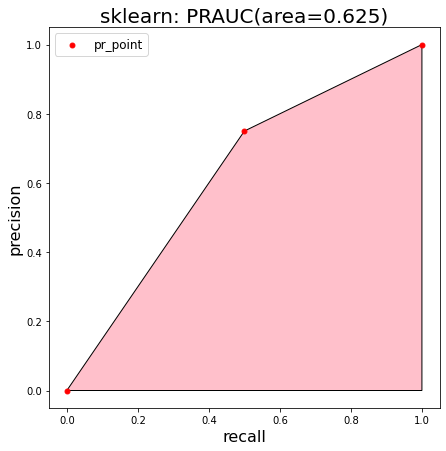

In [ ]:
draw_pr_curve_auc(xy=[(1, 1), (0.5, 0.75), (0, 0), (1, 0)], title=f"sklearn: PRAUC(area={auc_sklearn(recall, precision)})", xy_point=np.array([[1, 1], [0.5, 0.75], [0, 0]]))

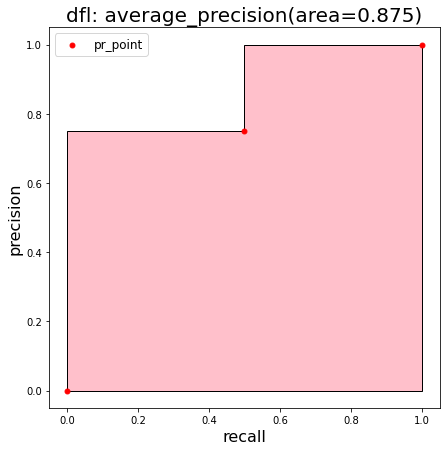

In [ ]:
draw_pr_curve_auc(xy=[(1, 1), (0.5, 1), (0.5, 0.75), (0, 0.75), (0, 0), (1, 0)], title=f"dfl: average_precision(area={auc_dfl(recall, precision)})", xy_point=np.array([[1, 1], [0.5, 0.75], [0, 0]]))

#### If the amount of data is large, maybe the error between the two is slight.

## case9 perfect submisson(score = 0.5 for play) + miss prediction(score=0.25, score=0.75)

In [ ]:
play_matched = np.array([
    True,  # time = 2
    False, # time = 12
    False  # time = 22
])
play_score = np.array([
    0.5,   # time = 2
    0.75,  # time = 12
    0.25,  # time = 22
])
ap_for_play = prauc(play_matched, play_score)
print(f"play_ap = {ap_for_play}, total_ap = {(1 + 1 + ap_for_play) / 3}")

play_ap = 0.25, total_ap = 0.75


In [ ]:
df_pred1 = pd.DataFrame({
    "video_id": ["case1"] * 5,
    "time": [2, 12, 22, 12, 22],
    "event": ["play", "challenge", "throwin", "play", "play"],
    "score": [0.5, 1, 1, 0.75, 0.25]
})
event_detection_ap(solution=df_case1, submission=df_pred1, tolerances=tolerances)

detection_matched: 
         event  tolerance video_id  time  score  matched
0   challenge       0.30    case1    12   1.00     True
1   challenge       0.40    case1    12   1.00     True
2   challenge       0.50    case1    12   1.00     True
3   challenge       0.60    case1    12   1.00     True
4   challenge       0.70    case1    12   1.00     True
6        play       0.15    case1    12   0.75    False
5        play       0.15    case1     2   0.50     True
7        play       0.15    case1    22   0.25    False
9        play       0.20    case1    12   0.75    False
8        play       0.20    case1     2   0.50     True
10       play       0.20    case1    22   0.25    False
12       play       0.25    case1    12   0.75    False
11       play       0.25    case1     2   0.50     True
13       play       0.25    case1    22   0.25    False
15       play       0.30    case1    12   0.75    False
14       play       0.30    case1     2   0.50     True
16       play       0.30   

0.8333333333333334

## case10 perfect submisson(score = 0.5 for play) + miss prediction(score=0.65, score=0.75)

In [ ]:
df_pred1 = pd.DataFrame({
    "video_id": ["case1"] * 5,
    "time": [2, 12, 22, 12, 22],
    "event": ["play", "challenge", "throwin", "play", "play"],
    "score": [0.5, 1, 1, 0.75, 0.65]
})
event_detection_ap(solution=df_case1, submission=df_pred1, tolerances=tolerances)

detection_matched: 
         event  tolerance video_id  time  score  matched
0   challenge       0.30    case1    12   1.00     True
1   challenge       0.40    case1    12   1.00     True
2   challenge       0.50    case1    12   1.00     True
3   challenge       0.60    case1    12   1.00     True
4   challenge       0.70    case1    12   1.00     True
6        play       0.15    case1    12   0.75    False
7        play       0.15    case1    22   0.65    False
5        play       0.15    case1     2   0.50     True
9        play       0.20    case1    12   0.75    False
10       play       0.20    case1    22   0.65    False
8        play       0.20    case1     2   0.50     True
12       play       0.25    case1    12   0.75    False
13       play       0.25    case1    22   0.65    False
11       play       0.25    case1     2   0.50     True
15       play       0.30    case1    12   0.75    False
16       play       0.30    case1    22   0.65    False
14       play       0.30   

0.7777777777777777

## case11 perfect submisson(score=0.5, score=0.55 for play) + miss prediction(score=0.25, score=0.75) 

In [ ]:
df_pred1 = pd.DataFrame({
    "video_id": ["case1"] * 6,
    "time": [2, 12, 22, 12, 22, 2.02],
    "event": ["play", "challenge", "throwin", "play", "play", "play"],
    "score": [0.5, 1, 1, 0.75, 0.25, 0.55]
})
event_detection_ap(solution=df_case1, submission=df_pred1, tolerances=tolerances)

detection_matched: 
         event  tolerance video_id   time  score  matched
0   challenge       0.30    case1  12.00   1.00     True
1   challenge       0.40    case1  12.00   1.00     True
2   challenge       0.50    case1  12.00   1.00     True
3   challenge       0.60    case1  12.00   1.00     True
4   challenge       0.70    case1  12.00   1.00     True
6        play       0.15    case1  12.00   0.75    False
8        play       0.15    case1   2.02   0.55     True
5        play       0.15    case1   2.00   0.50    False
7        play       0.15    case1  22.00   0.25    False
10       play       0.20    case1  12.00   0.75    False
12       play       0.20    case1   2.02   0.55     True
9        play       0.20    case1   2.00   0.50    False
11       play       0.20    case1  22.00   0.25    False
14       play       0.25    case1  12.00   0.75    False
16       play       0.25    case1   2.02   0.55     True
13       play       0.25    case1   2.00   0.50    False
15       p

0.8333333333333334

## case12 1 correct and 1 wrong prediction exist in one terms(from start to end)

In [ ]:
df_pred1 = pd.DataFrame({
    "video_id": ["case1"] * 4,
    "time": [2, 12, 22, 2.5],
    "event": ["play", "challenge", "throwin", "play"],
    "score": [1, 1, 1, 1]
})
event_detection_ap(solution=df_case1, submission=df_pred1, tolerances=tolerances)

detection_matched: 
         event  tolerance video_id  time  score  matched
0   challenge       0.30    case1  12.0      1     True
1   challenge       0.40    case1  12.0      1     True
2   challenge       0.50    case1  12.0      1     True
3   challenge       0.60    case1  12.0      1     True
4   challenge       0.70    case1  12.0      1     True
5        play       0.15    case1   2.0      1     True
6        play       0.15    case1   2.5      1    False
7        play       0.20    case1   2.0      1     True
8        play       0.20    case1   2.5      1    False
9        play       0.25    case1   2.0      1     True
10       play       0.25    case1   2.5      1    False
11       play       0.30    case1   2.0      1     True
12       play       0.30    case1   2.5      1    False
13       play       0.35    case1   2.0      1     True
14       play       0.35    case1   2.5      1    False
15    throwin       0.15    case1  22.0      1     True
16    throwin       0.20   

0.8333333333333334

## case13 1 correct and 2 wrong predictions exist in one terms(from start to end)

In [ ]:
df_pred1 = pd.DataFrame({
    "video_id": ["case1"] * 5,
    "time": [2, 12, 22, 2.5, 2.6],
    "event": ["play", "challenge", "throwin", "play", "play"],
    "score": [1, 1, 1, 1, 1]
})
event_detection_ap(solution=df_case1, submission=df_pred1, tolerances=tolerances)

detection_matched: 
         event  tolerance video_id  time  score  matched
0   challenge       0.30    case1  12.0      1     True
1   challenge       0.40    case1  12.0      1     True
2   challenge       0.50    case1  12.0      1     True
3   challenge       0.60    case1  12.0      1     True
4   challenge       0.70    case1  12.0      1     True
5        play       0.15    case1   2.0      1     True
6        play       0.15    case1   2.5      1    False
7        play       0.15    case1   2.6      1    False
8        play       0.20    case1   2.0      1     True
9        play       0.20    case1   2.5      1    False
10       play       0.20    case1   2.6      1    False
11       play       0.25    case1   2.0      1     True
12       play       0.25    case1   2.5      1    False
13       play       0.25    case1   2.6      1    False
14       play       0.30    case1   2.0      1     True
15       play       0.30    case1   2.5      1    False
16       play       0.30   

0.7777777777777777

## case14 perfect predictions 2 times.

In [ ]:
# Only the first predictions is treated as "correct". After the second predicitions, it is treated as "wrong". 
df_pred1 = pd.DataFrame({
    "video_id": ["case1"] * 3 * 2,
    "time": [2, 12, 22] * 2,
    "event": ["play", "challenge", "throwin"] * 2,
    "score": [1, 1, 1] * 2
})
event_detection_ap(solution=df_case1, submission=df_pred1, tolerances=tolerances)

detection_matched: 
         event  tolerance video_id  time  score  matched
0   challenge       0.30    case1    12      1     True
1   challenge       0.30    case1    12      1    False
2   challenge       0.40    case1    12      1     True
3   challenge       0.40    case1    12      1    False
4   challenge       0.50    case1    12      1     True
5   challenge       0.50    case1    12      1    False
6   challenge       0.60    case1    12      1     True
7   challenge       0.60    case1    12      1    False
8   challenge       0.70    case1    12      1     True
9   challenge       0.70    case1    12      1    False
10       play       0.15    case1     2      1     True
11       play       0.15    case1     2      1    False
12       play       0.20    case1     2      1     True
13       play       0.20    case1     2      1    False
14       play       0.25    case1     2      1     True
15       play       0.25    case1     2      1    False
16       play       0.30   

0.5

## case15 perfect submission only challenge, throwin
AP achieve 1.0!?<br> 

In [ ]:
df_pred1 = pd.DataFrame({
    "video_id": ["case1"] * 2,
    "time": [12, 22],
    "event": ["challenge", "throwin"],
    "score": [1, 1]
})
event_detection_ap(solution=df_case1, submission=df_pred1, tolerances=tolerances)

detection_matched: 
         event  tolerance video_id  time  score  matched
0   challenge       0.30    case1  12.0    1.0     True
1   challenge       0.40    case1  12.0    1.0     True
2   challenge       0.50    case1  12.0    1.0     True
3   challenge       0.60    case1  12.0    1.0     True
4   challenge       0.70    case1  12.0    1.0     True
10    throwin       0.15    case1  22.0    1.0     True
11    throwin       0.20    case1  22.0    1.0     True
12    throwin       0.25    case1  22.0    1.0     True
13    throwin       0.30    case1  22.0    1.0     True
14    throwin       0.35    case1  22.0    1.0     True
ap_table: 
 event      tolerance
challenge  0.30         1.0
           0.40         1.0
           0.50         1.0
           0.60         1.0
           0.70         1.0
throwin    0.15         1.0
           0.20         1.0
           0.25         1.0
           0.30         1.0
           0.35         1.0
dtype: float64


1.0

In [ ]:
# you can add example here!